<a href="https://colab.research.google.com/github/josbex/HS-detection_in_social_media_posts/blob/master/Interpretation_of_BERT_using_captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretation of BertForSequenceClassification in captum

The orignial notebook this is based on can be found here:
https://colab.research.google.com/drive/1Lw3JTZio03VwPvSVFzLJmZ52oBRpo9ZM 

In [1]:
# Install dependencies
!pip install transformers
!pip install captum

In [2]:
import captum
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox

In [3]:
import pandas as pd
import numpy as np
import csv

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Load a trained model and vocabulary that you have fine-tuned
def load_model(dir):
  output_dir = "./gdrive/My Drive/thesis/model/" + dir
  model = BertForSequenceClassification.from_pretrained(output_dir, output_attentions=True)
  tokenizer = BertTokenizer.from_pretrained(output_dir)
  # Copy the model to the GPU.
  model.to(device)
  model.eval()
  model.zero_grad()
  return model, tokenizer

In [7]:
# load model and tokenizer
#model, tokenizer = load_model("/learn_rate_5/model_save") # model with 0.827 f1 score
model, tokenizer = load_model("new_training_round/best_model/model_save") # model with 0.819 f1 score

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model(inputs)[0]

In [9]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [10]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [11]:
def custom_forward(inputs):
    preds = predict(inputs)
    #return torch.softmax(preds, dim = 1)[:, 0] # for negative attribution, 
    return torch.softmax(preds, dim = 1)[:, 1] #<- for positive attribution

In [12]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [13]:
def get_dataset(filename):
  df = pd.read_csv("/content/gdrive/My Drive/thesis/" + filename + ".tsv", sep="\t") 
  return df

In [14]:
def get_test_tweet_by_index(index):
  df = get_dataset("dataset/test_data")
  tweets = df.tweet.values
  labels = df.label.values
  #print("tweet: " + str(tweets[index]) + " label: " + str(labels[index]))
  return tweets[index], labels[index]

def get_prediction_type_indices(df):
  tp_indices = df.loc[df['Type'] == 'tp'].Index.values
  tn_indices = df.loc[df['Type'] == 'tn'].Index.values
  fp_indices = df.loc[df['Type'] == 'fp'].Index.values
  fn_indices = df.loc[df['Type'] == 'fn'].Index.values
  return tp_indices, tn_indices, fp_indices, fn_indices

def get_accurate_predictions(path):
  df = get_dataset("model/predictions/" + path)
  return df.Index.values

In [15]:
def tokenize_tweet(tweet):
  input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tweet, ref_token_id, sep_token_id, cls_token_id)
  token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
  position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
  attention_mask = construct_attention_mask(input_ids)
  indices = input_ids[0].detach().tolist()
  all_tokens = tokenizer.convert_ids_to_tokens(indices)
  return input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens

In [16]:
df = get_dataset("model/predictions/pred_indices")
tp_indices, tn_indices, fp_indices, fn_indices = get_prediction_type_indices(df)

In [16]:
def get_attributions(input_ids, ref_input_ids):
  attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=5,
                                    return_convergence_delta=True)
  return attributions, delta

In [17]:
def print_tweet_with_prediction(tweet, score):
  print('Tweet: ', tweet)
  print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
        ', Probability positive: ' + str(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()))

In [18]:
def get_accurate_prediction_indices(tweet_index_list, limit):
  accurate_predictions = []
  for i in range(len(tweet_index_list)):
    tweet, true_label = get_test_tweet_by_index(tweet_index_list[i])
    input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
    score = predict(input_ids)
    if int(torch.argmax(score[0]).cpu().numpy()) == 0:
      if (1.0 - float(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy())) >= limit:
        accurate_predictions.append(tweet_index_list[i])
    elif float(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()) >= limit:
      accurate_predictions.append(tweet_index_list[i])
  return accurate_predictions

In [19]:
def save_accurate_prediction_indices(accurate_predictions, pred_type):
  with open('/content/gdrive/My Drive/thesis/model/predictions/' + pred_type + '_accurate_predictions.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['Index'])
    for index in accurate_predictions:
      tsv_writer.writerow([index])
  out_file.close()

##Extract the most accurate predictions 
from the true positive and true negative results, here the limit is set to only save the tweets where there is an at least 90% certainty the the prediction is correct.

In [ ]:
accurate_predictions = get_accurate_prediction_indices(tn_indices, 0.90) #change to tp_indices to save the true positive tweets, 0.90 is the ceratinty limit 
for i in accurate_predictions:
  tweet, true_label = get_test_tweet_by_index(i)
  input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
  score = predict(input_ids)
  print_tweet_with_prediction(tweet, score)
save_accurate_prediction_indices(accurate_predictions, 'tn') #if tp_inidices is used, this needs to change to tp

Tweet:  constitution day is revered by conservatives , hated by progressives / socialist / democrats that want to change it .
Sentiment: 0, Probability positive: 0.04677921
Tweet:  fox news nra maga potus trump 2 nd amendment rnc usmc veterans @user @user @user @user @user fake reporting theswamp dnc liberals @user @user fake outrage @user first , it reduces the ca url
Sentiment: 0, Probability positive: 0.072102465
Tweet:  watching boomer getting the news that she is still up for parole always makes me smile . wentworth finale . . . @user is such a treasure . url
Sentiment: 0, Probability positive: 0.030327082
Tweet:  <number> tips to enhance audience connection on facebook url @user social media smm url
Sentiment: 0, Probability positive: 0.014982273
Tweet:  bigg boss tamil janani won the task . she is going to first final list
Sentiment: 0, Probability positive: 0.01261972
Tweet:  conservatives - the party of low taxation tories tory url
Sentiment: 0, Probability positive: 0.0196419

In [20]:
def summarize_attributions(attributions):
  attributions = attributions.sum(dim=-1).squeeze(0)
  attributions = attributions / torch.norm(attributions)
  return attributions

In [21]:
def save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta):
  # storing couple samples in an array for visualization purposes
  score_vis = viz.VisualizationDataRecord(attributions_sum,
                                          torch.softmax(score, dim = 1)[0][0],
                                          torch.argmax(torch.softmax(score, dim = 1)[0]),
                                          true_label,
                                          tweet,
                                          attributions_sum.sum(),       
                                          all_tokens,
                                          delta)
  return score_vis

In [ ]:
print('fp: ' + str(len(fp_indices)))
print('tp: ' + str(len(tp_indices)))
print('fn: ' + str(len(fn_indices)))
print('tn: ' + str(len(tn_indices)))

fp: 57
tp: 172
fn: 68
tn: 563


##Plot attributions

In [22]:
def get_attribution_per_token(all_tokens, attributions_sum, index):
  return all_tokens[index], attributions_sum[index]

def get_nth_top_tokens(n, attributions_sum):
  lst = pd.Series(attributions_sum)
  i = lst.nlargest(n)
  return i.index.values.tolist()

def get_nth_bottom_tokens(n, attributions_sum):
  lst = pd.Series(attributions_sum)
  i = lst.nsmallest(n)
  return i.index.values.tolist()

def get_negative_attributions(attribution_sum, token_indices):
  negative_indices = []
  for i in token_indices:
    if(attribution_sum[i] < 0):
      negative_indices.append(i)
  return negative_indices

def get_positive_attributions(attribution_sum, token_indices):
  positive_indices = []
  for i in token_indices:
    if(attribution_sum[i] > 0):
      positive_indices.append(i)
  return positive_indices

def get_n_attributions_and_tokens(n, attributions_sum, all_tokens):
  n_attributions = []
  n_tokens = []
  n_top_tokens = get_nth_top_tokens(n, attributions_sum)
  n_top_tokens = get_positive_attributions(attributions_sum, n_top_tokens)
  nr_of_top_tokens = len(n_top_tokens)
  n_bottom_tokens = get_nth_bottom_tokens(n, attributions_sum)
  n_bottom_tokens = get_negative_attributions(attributions_sum, n_bottom_tokens)
  n_top_tokens.extend(n_bottom_tokens) #Save all indices we need in one list
  for i in n_top_tokens:
    n_attributions.append(attributions_sum[i])
    n_tokens.append(all_tokens[i])
  return n_attributions, n_tokens, nr_of_top_tokens

def get_colors(n, n_attributions, c1, c2):
  col = []
  for i in range(len(n_attributions)):
    if i < n:
      col.append(c1)
    else:
      col.append(c2)
  return col

In [23]:
def plot_top_attributions(n, n_attributions, n_tokens, ylabel, title, name):
  fig = plt.figure(figsize=(19.20,10.80))
  index = np.arange(len(n_tokens))
  col = get_colors(n, n_attributions, 'grey', 'black')
  bars = plt.bar(index, n_attributions, color = col)
  plt.axhline(y=0,linewidth=2, color='k')
  plt.ylabel(ylabel, fontsize=24)
  plt.yticks(fontsize=22)
  plt.xticks(index, n_tokens, fontsize=22, rotation=90)
  plt.title(title, fontsize=22)
  plt.tight_layout()
  plt.show()
  fig.savefig("/content/gdrive/My Drive/thesis/interpret_plots/" + name + ".pdf")

In [24]:
def create_file(pred_type):
  with open('/content/gdrive/My Drive/thesis/interpret_plots/attributions_' + pred_type + '.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['Token', 'Attribution', 'Tweet Index'])
  out_file.close() 

def save_attributions_and_tokens(tokens, attributions, pred_type, tweet_index):
  with open('/content/gdrive/My Drive/thesis/interpret_plots/attributions_' + pred_type + '.tsv', 'a+') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    #tsv_writer.writerow(['Token', 'Attribution', 'Tweet Index'])
    for (token_i, attri_i) in zip(tokens, attributions):
      tsv_writer.writerow([token_i, attri_i, tweet_index])
  out_file.close()

In [25]:
def analyze_tweets(index_list, nr_of_tweets, title_of_prediction, pred_type):
  vis = []
  create_file(pred_type)
  for i in range(nr_of_tweets):
    tweet, true_label = get_test_tweet_by_index(index_list[i])
    input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
    attributions, delta = get_attributions(input_ids, ref_input_ids)
    attributions_sum = summarize_attributions(attributions)
    score = predict(input_ids)
    vis.append(save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta))
    n_attributions, n_tokens, nr_of_top_tokens = get_n_attributions_and_tokens(7, attributions_sum.detach().cpu().numpy(), np.array(all_tokens))
    plot_top_attributions(nr_of_top_tokens, n_attributions, n_tokens, 'Attributions',  '', pred_type + '_tweet_index_' + str(index_list[i]))
    save_attributions_and_tokens(n_tokens, n_attributions, pred_type, index_list[i])

  print('\033[1m', 'Visualization For Score ' + title_of_prediction, '\033[0m')
  for i in range(nr_of_tweets):
    viz.visualize_text([vis[i]])


##Analysing 30 sample tweets from each category

In [ ]:
index_lists = [fp_indices, tp_indices, fn_indices, tn_indices]
prediction_titles = ['False positive predictions', 'True positive predictions', 'False negative predictions', 'True negative predictions']
pred_type = ['fp', 'tp', 'fn', 'tn']

for i_list, title, p_type in zip(index_lists, prediction_titles, pred_type):
  analyze_tweets(i_list, 30, title, p_type)

##Analsing the tweets the model made the most accurate predictions on
i.e. the true positive and negative tweets that it was the most sure of being correct.

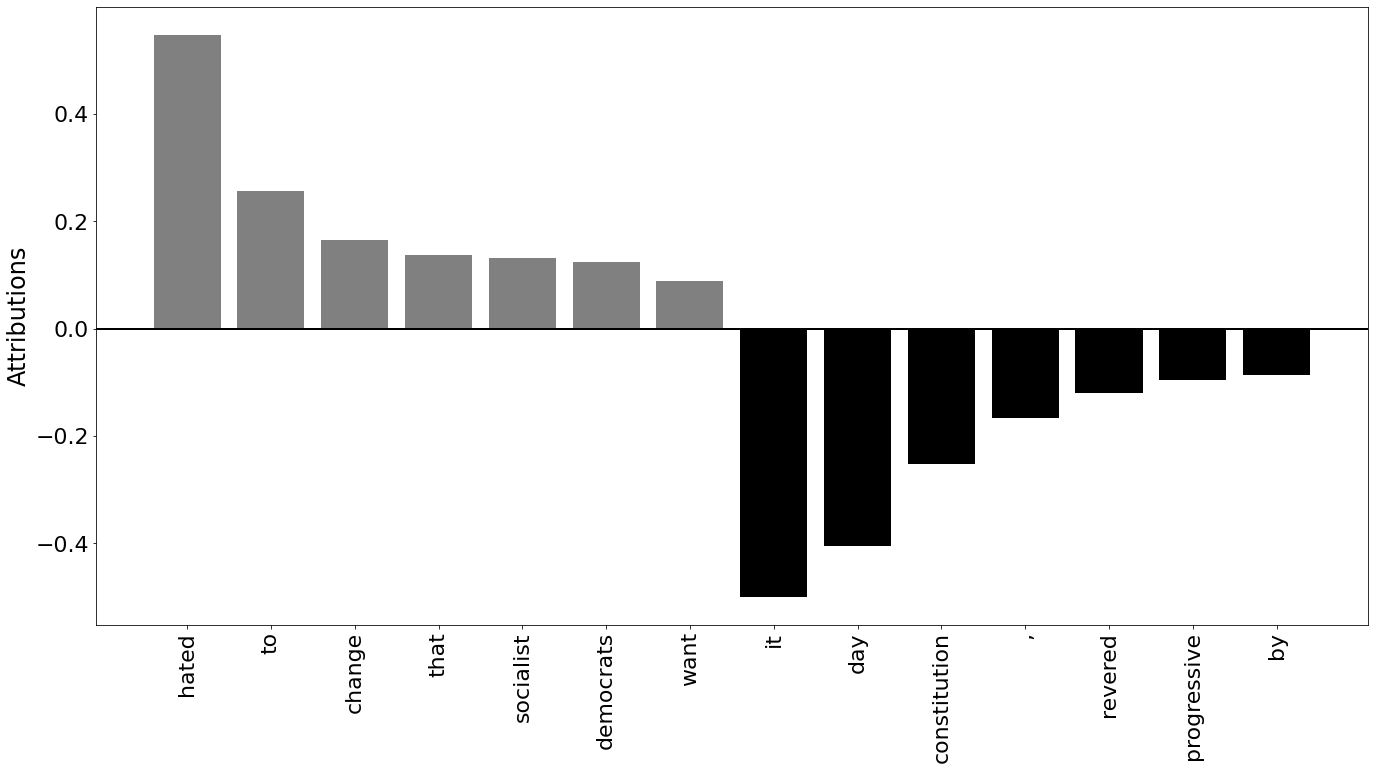

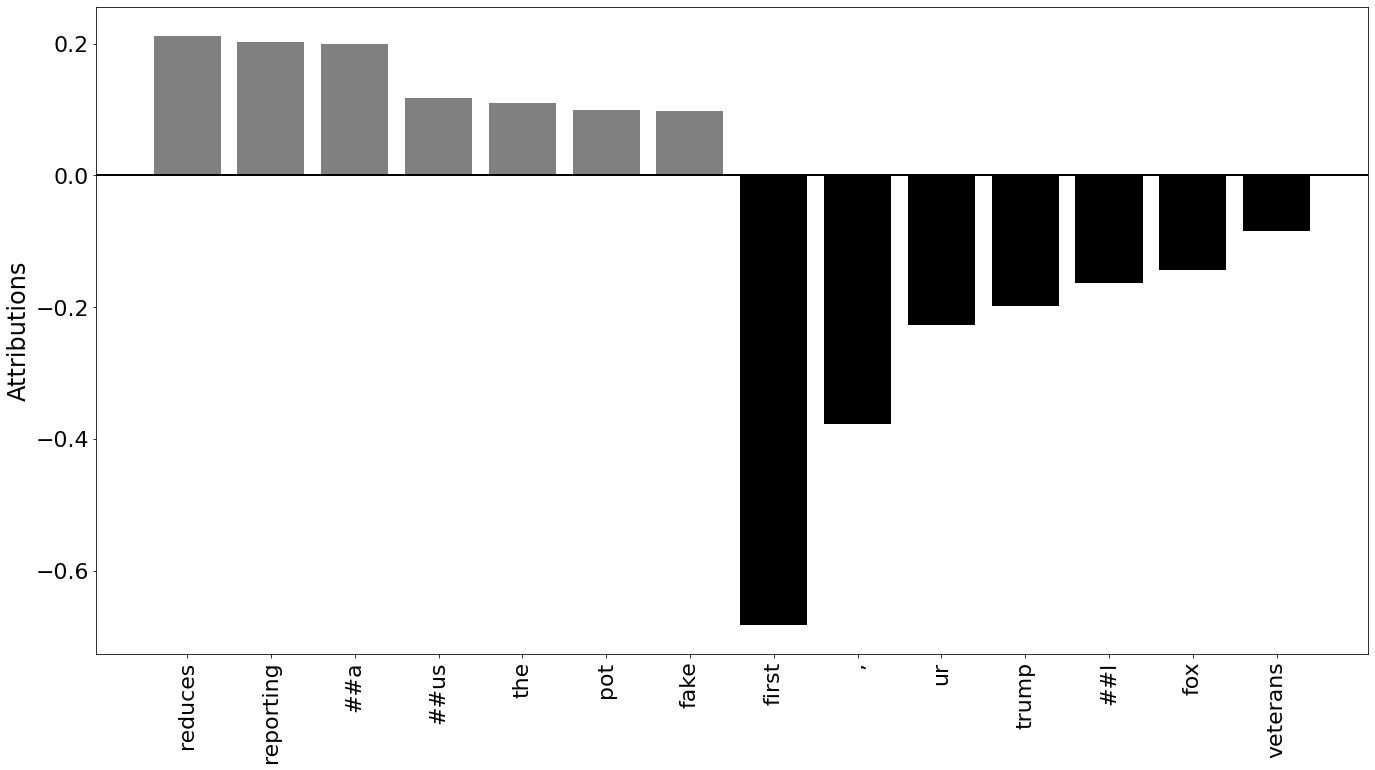

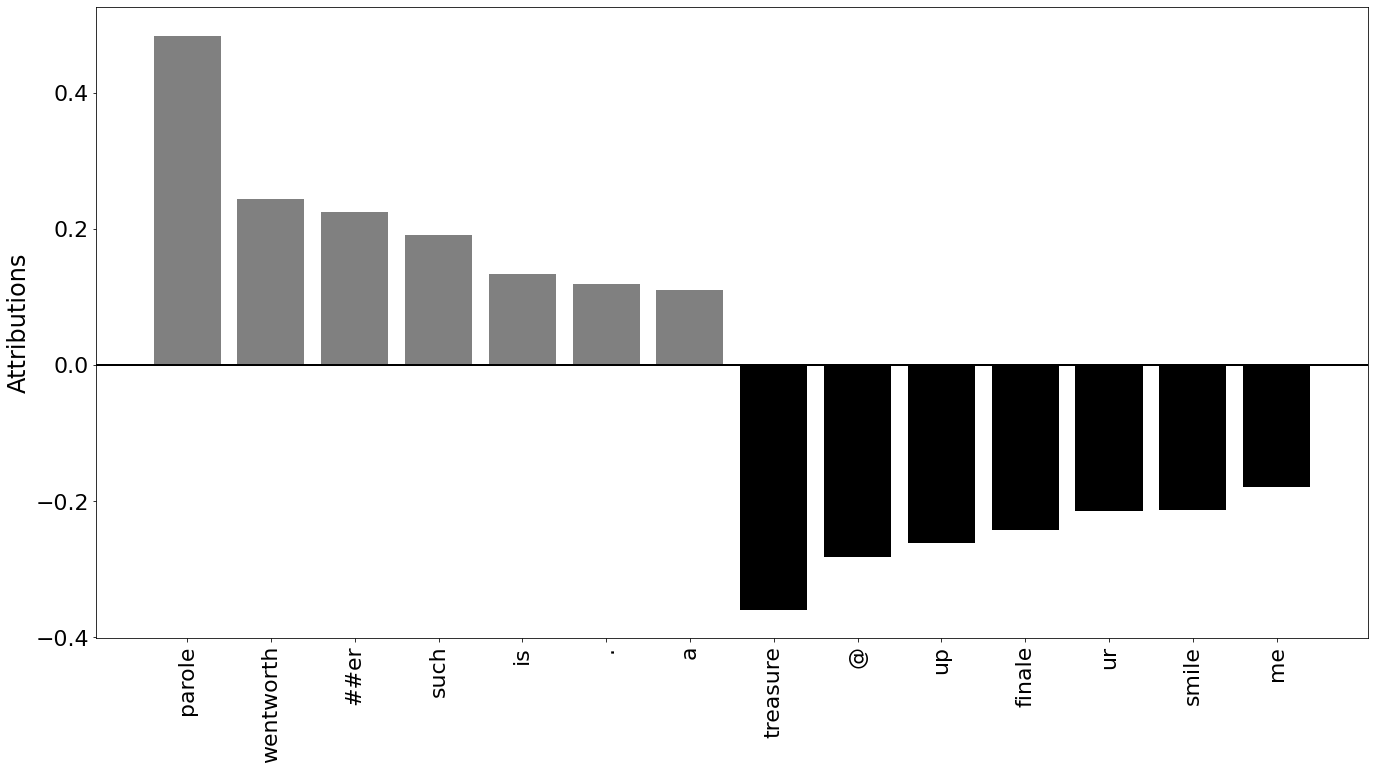

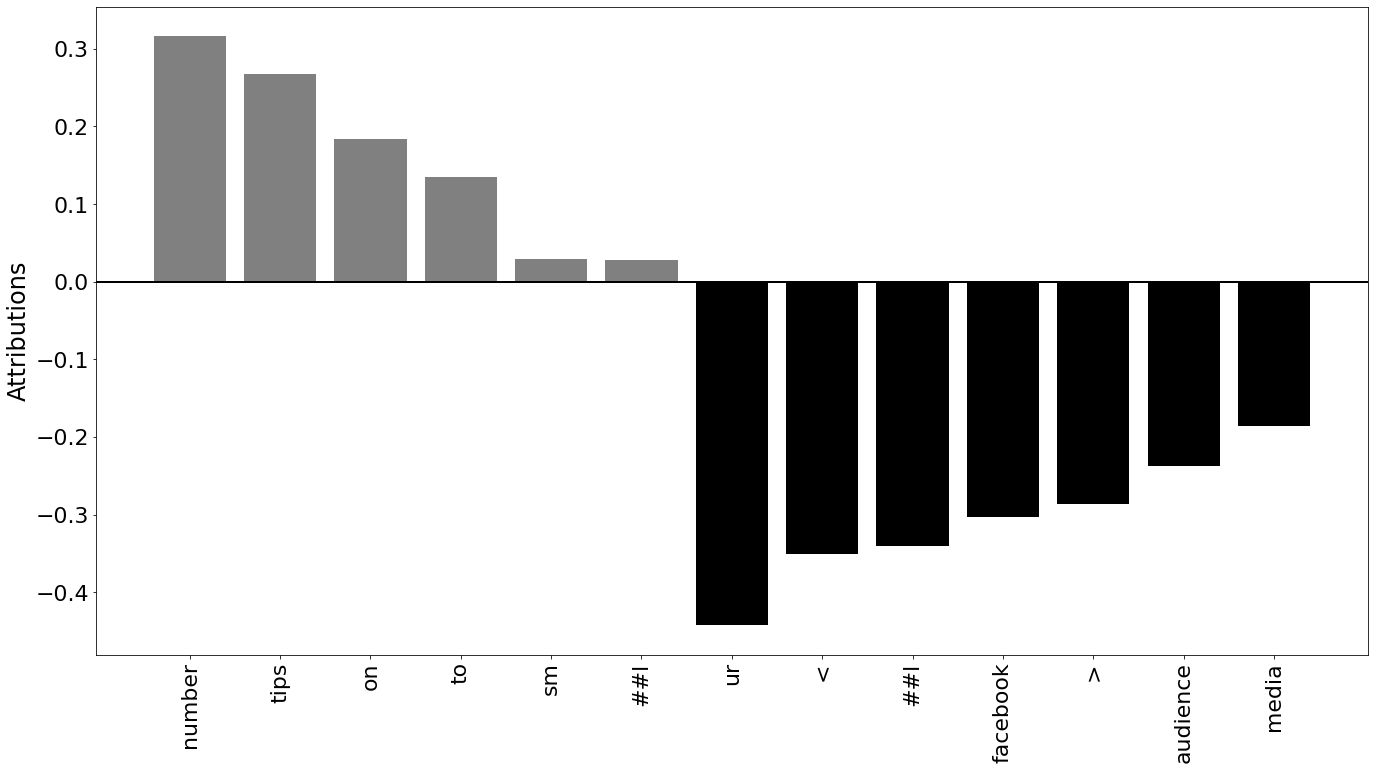

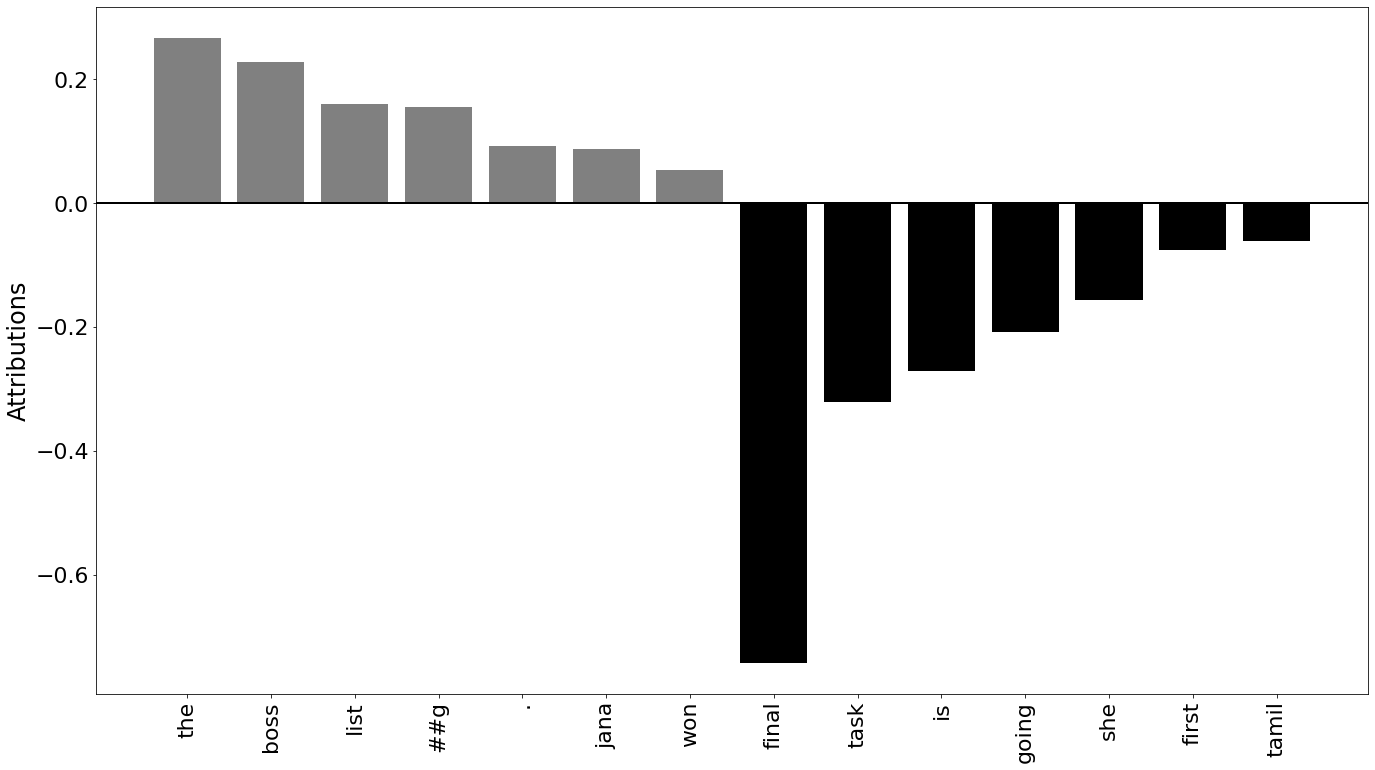

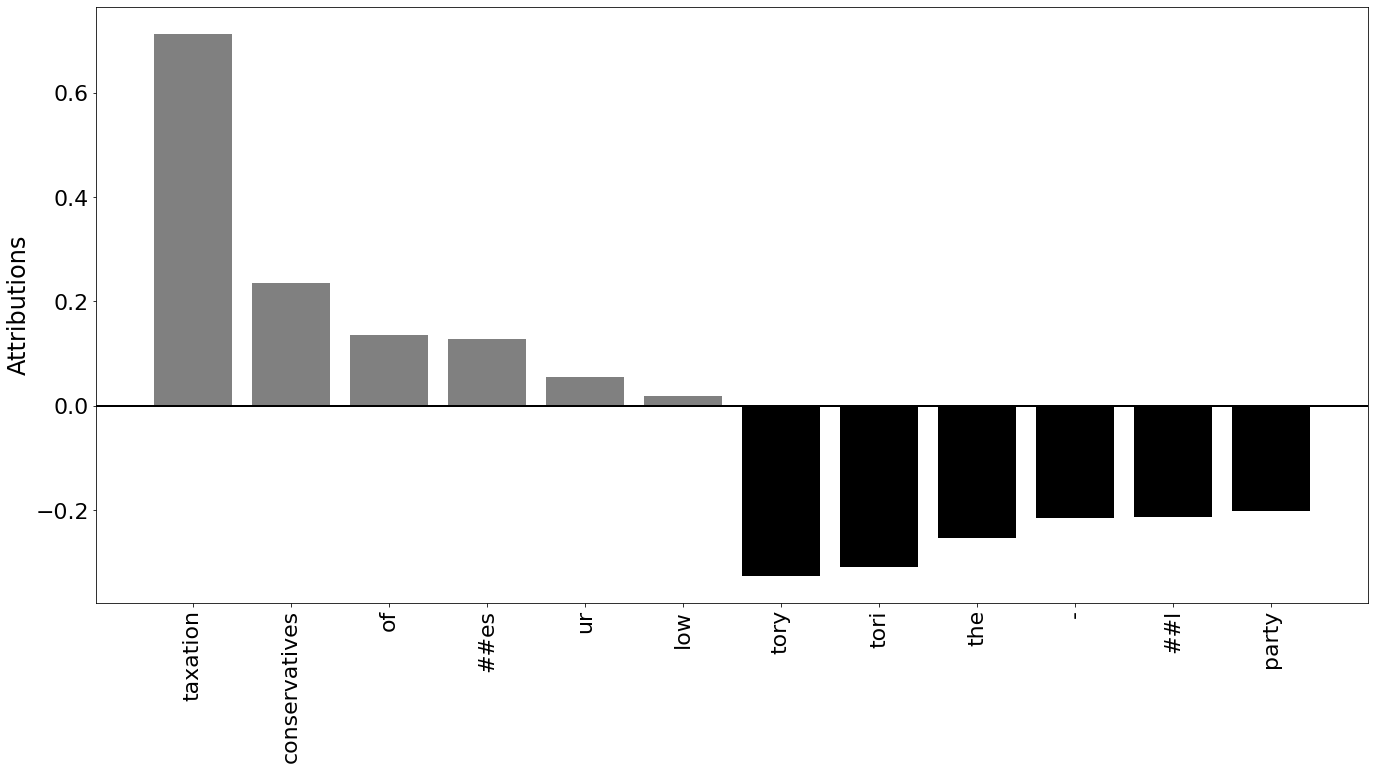

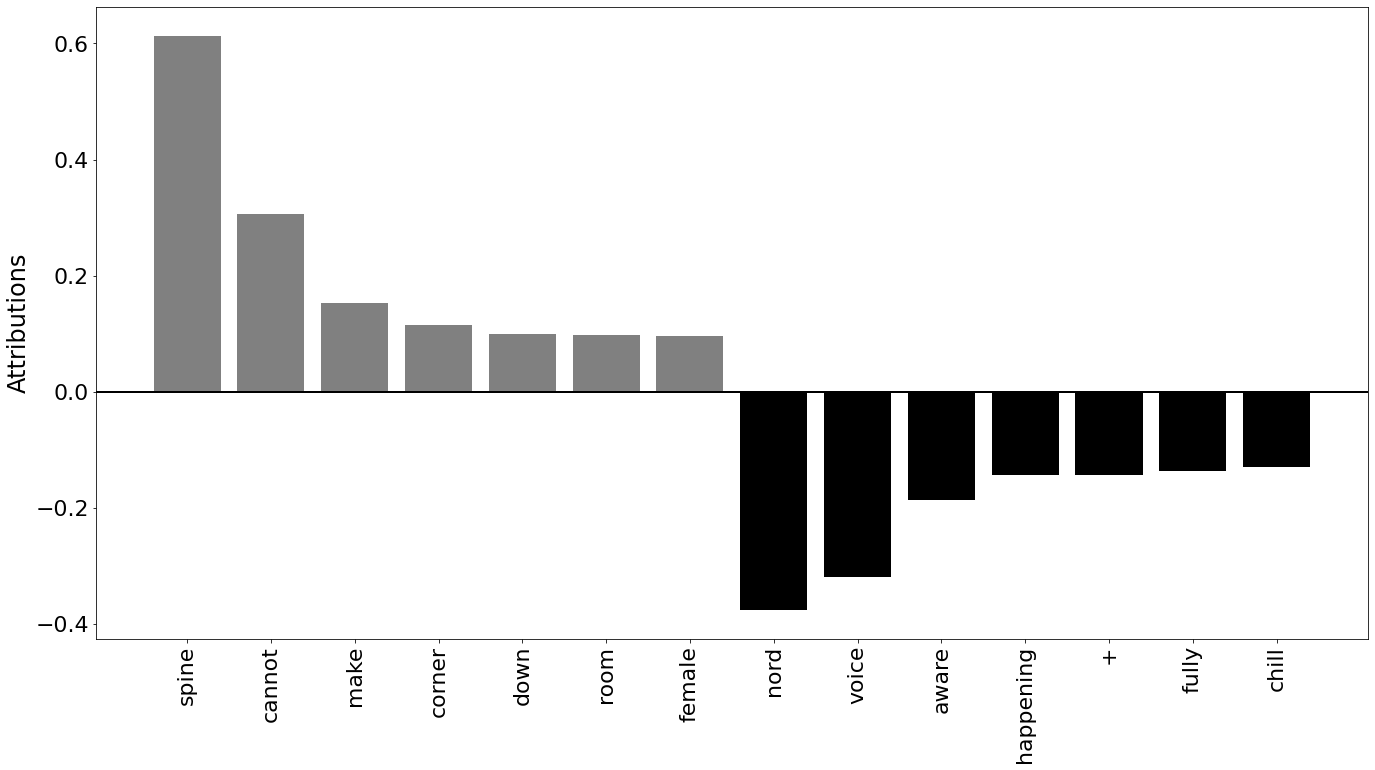

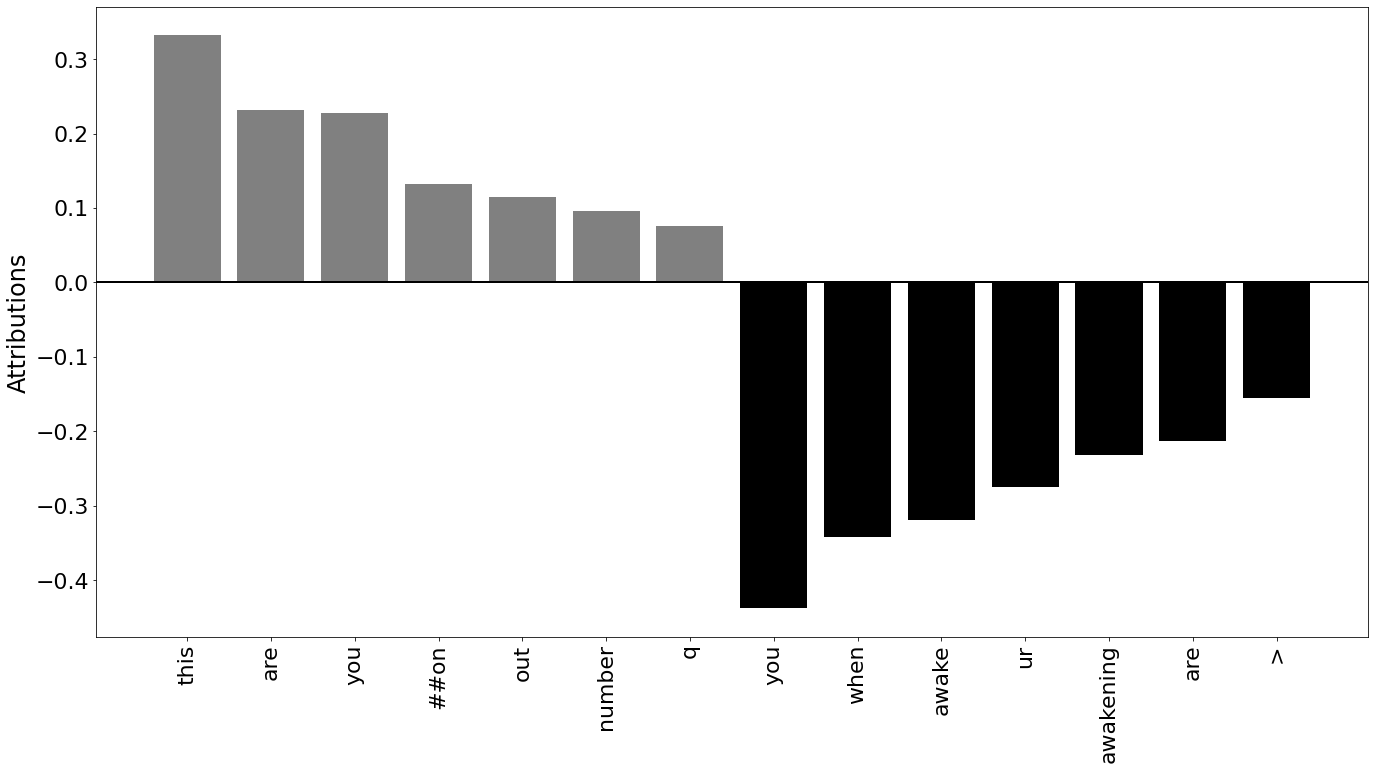

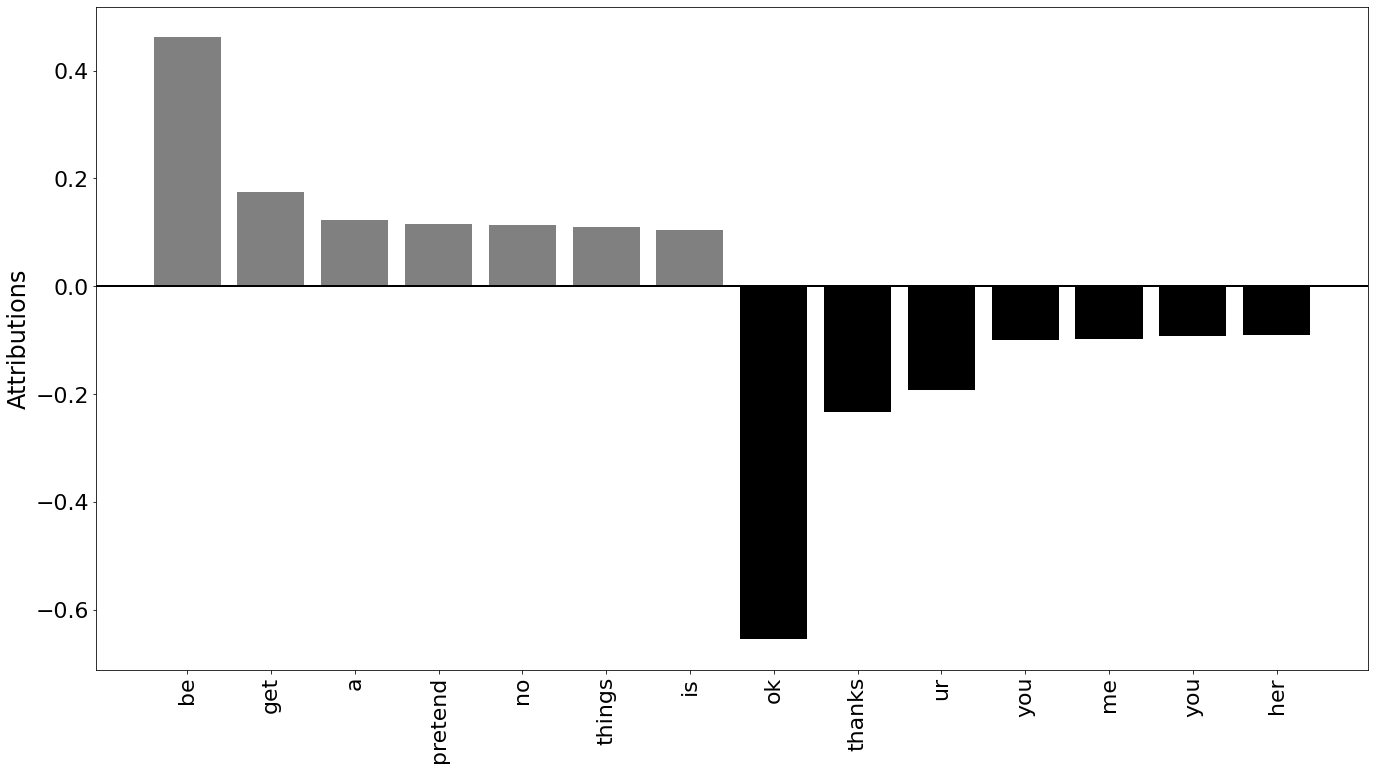

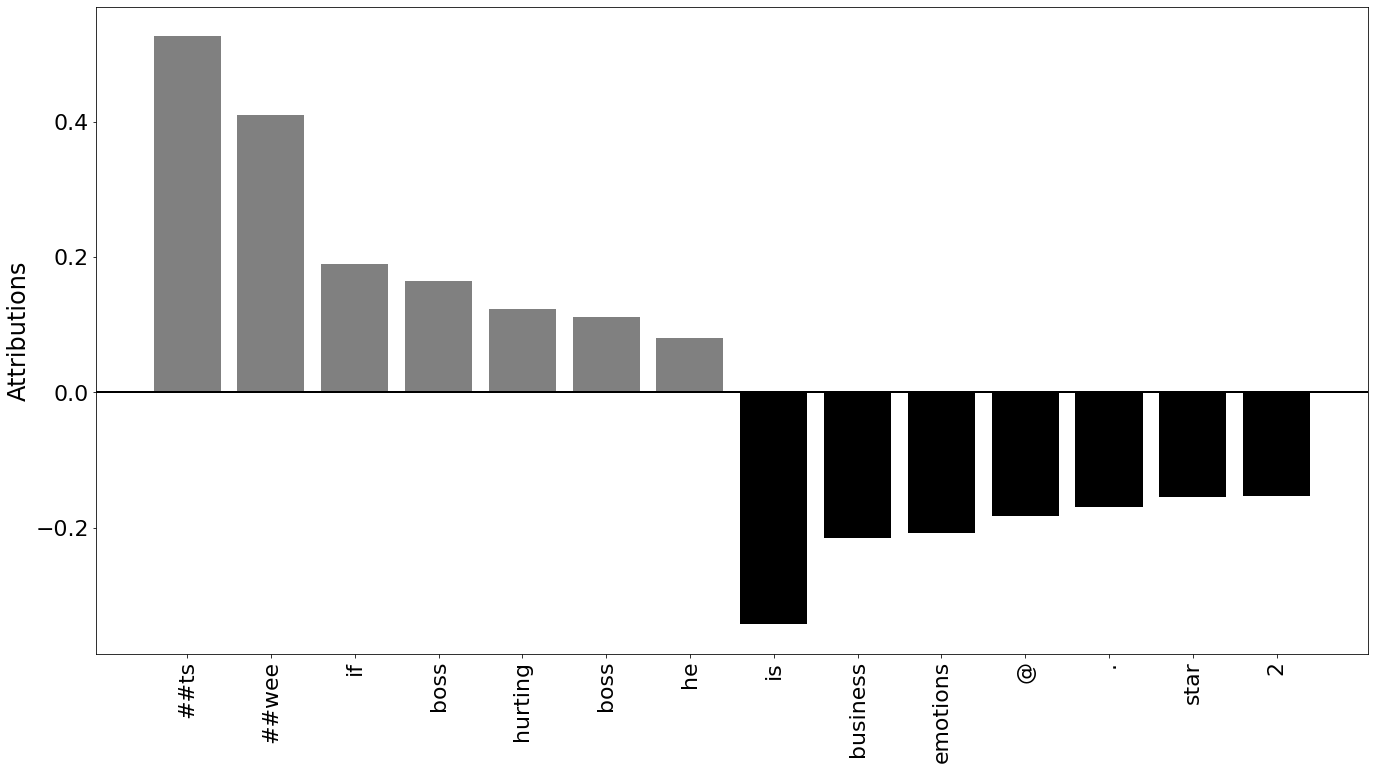

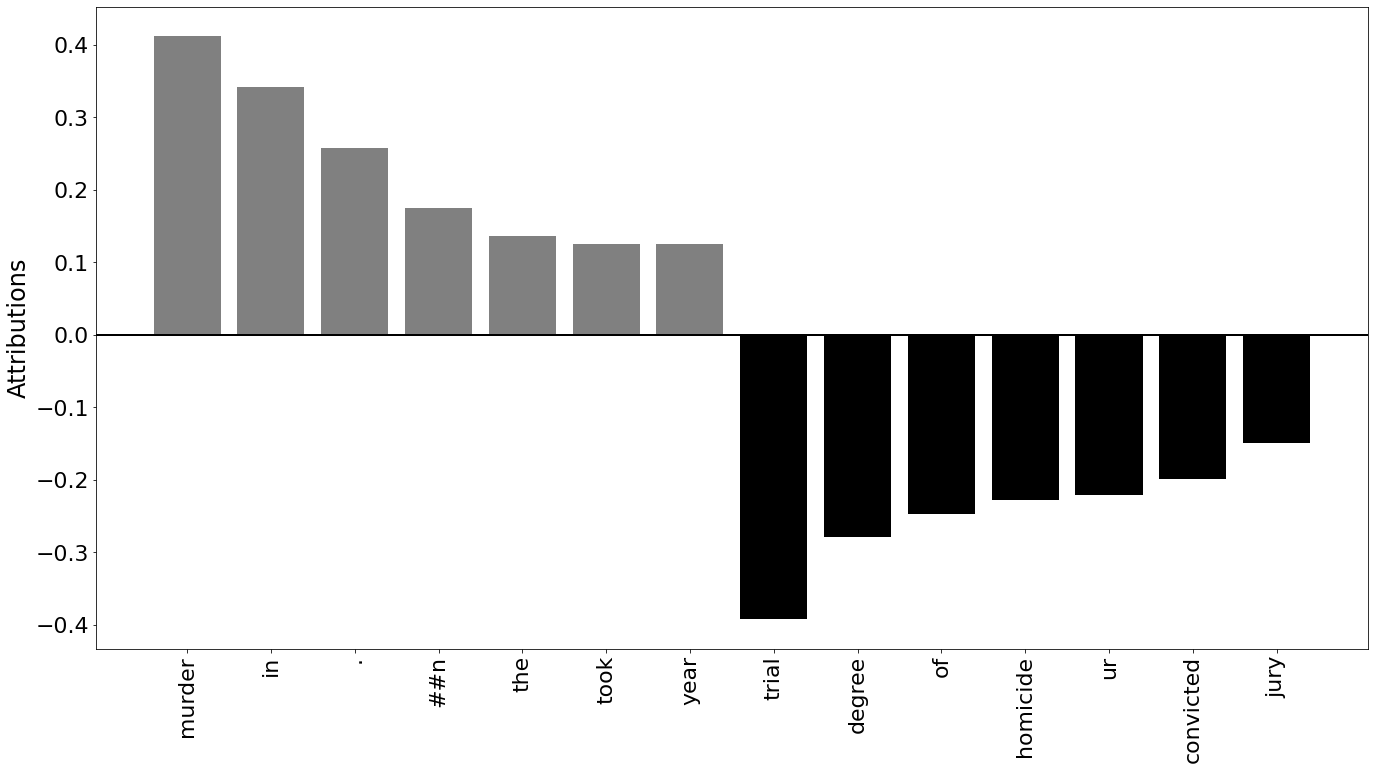

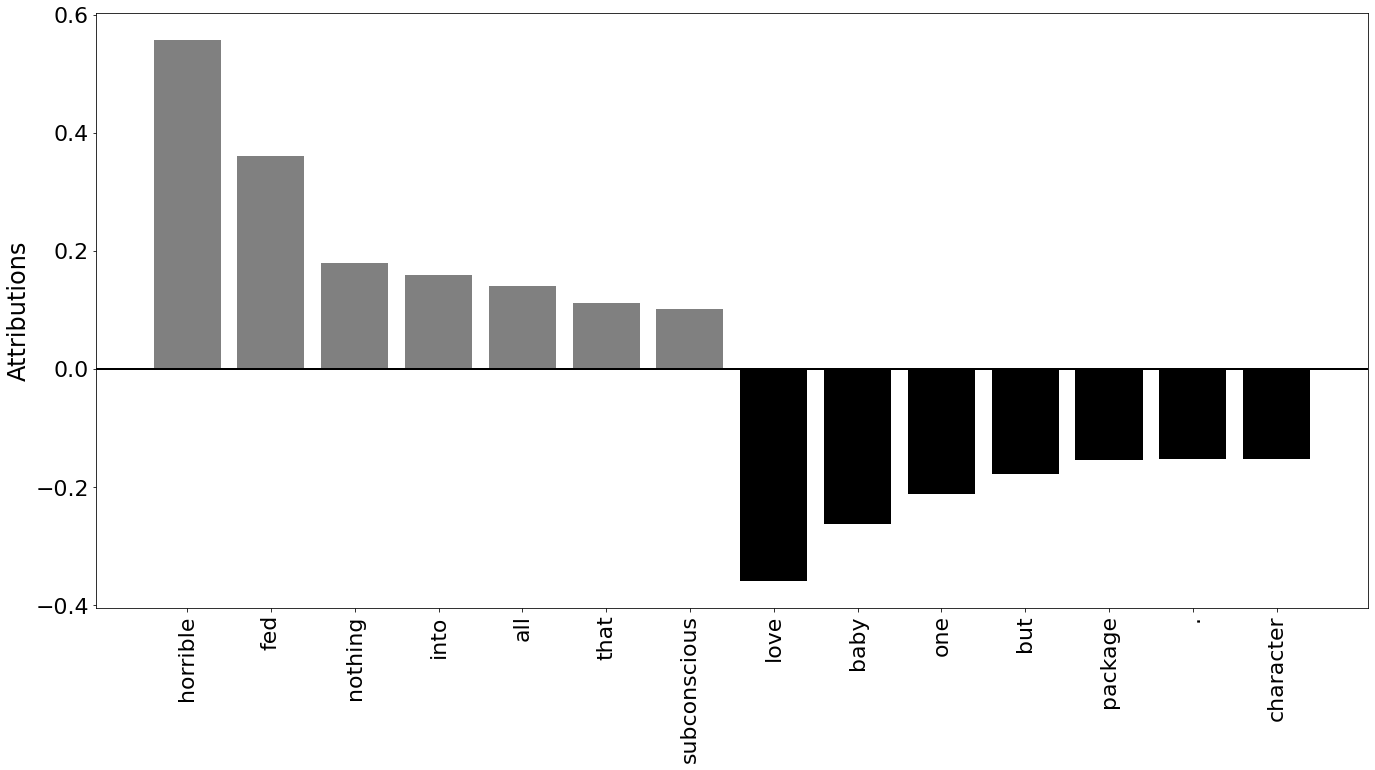

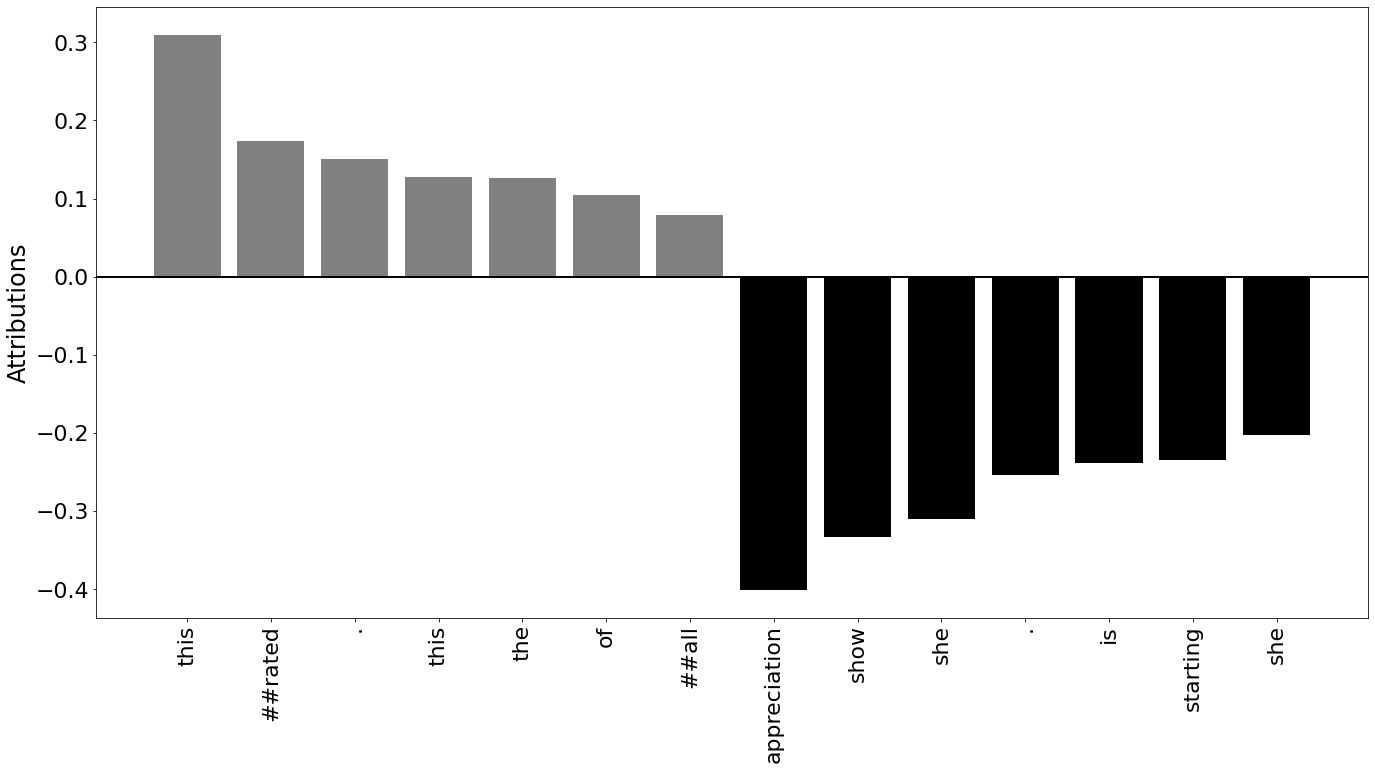

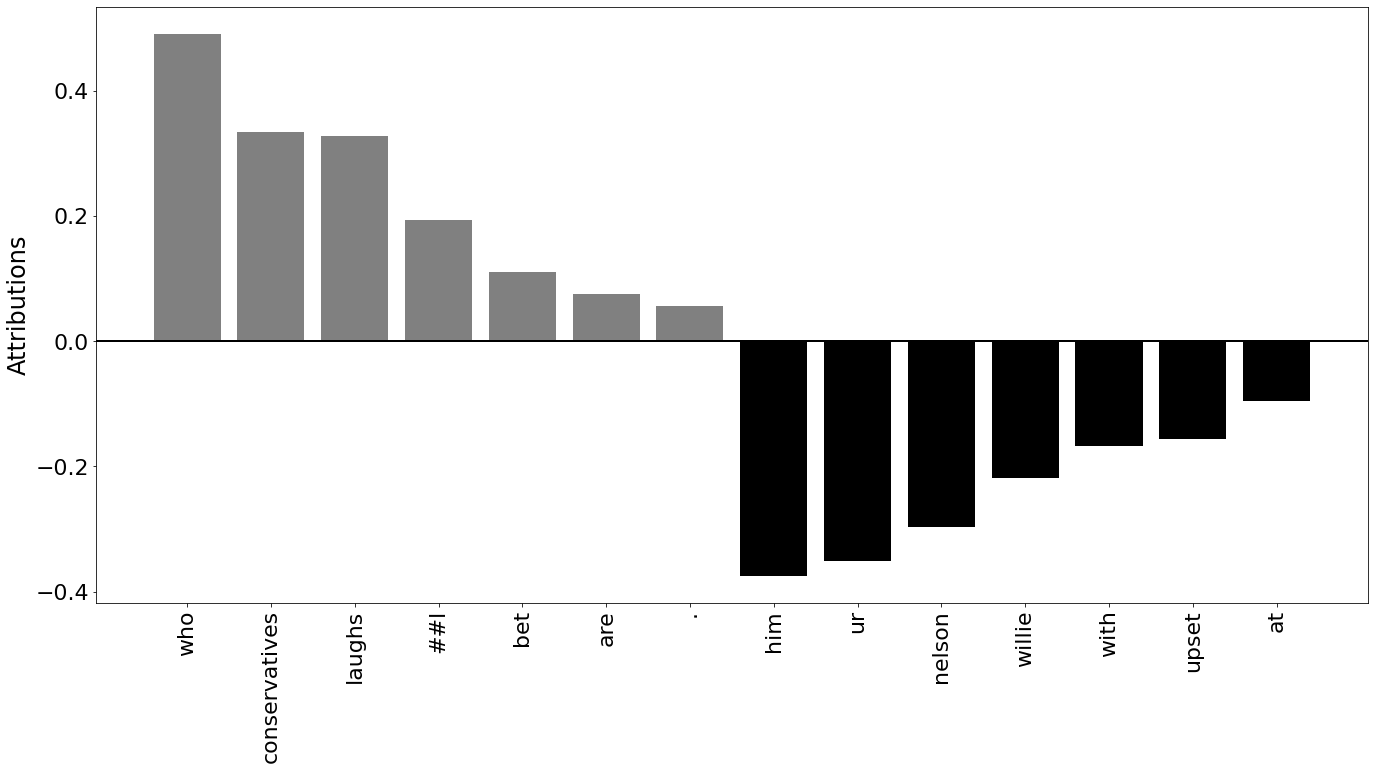

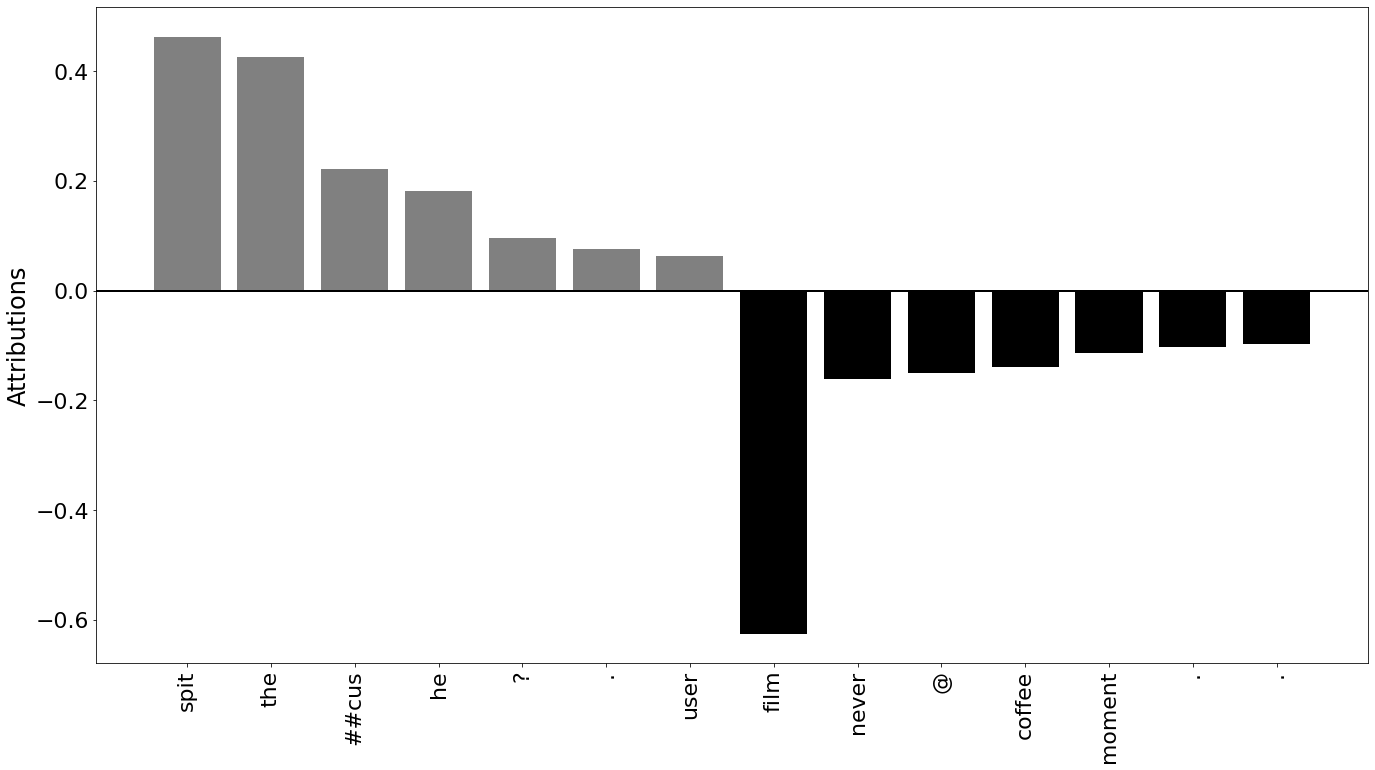

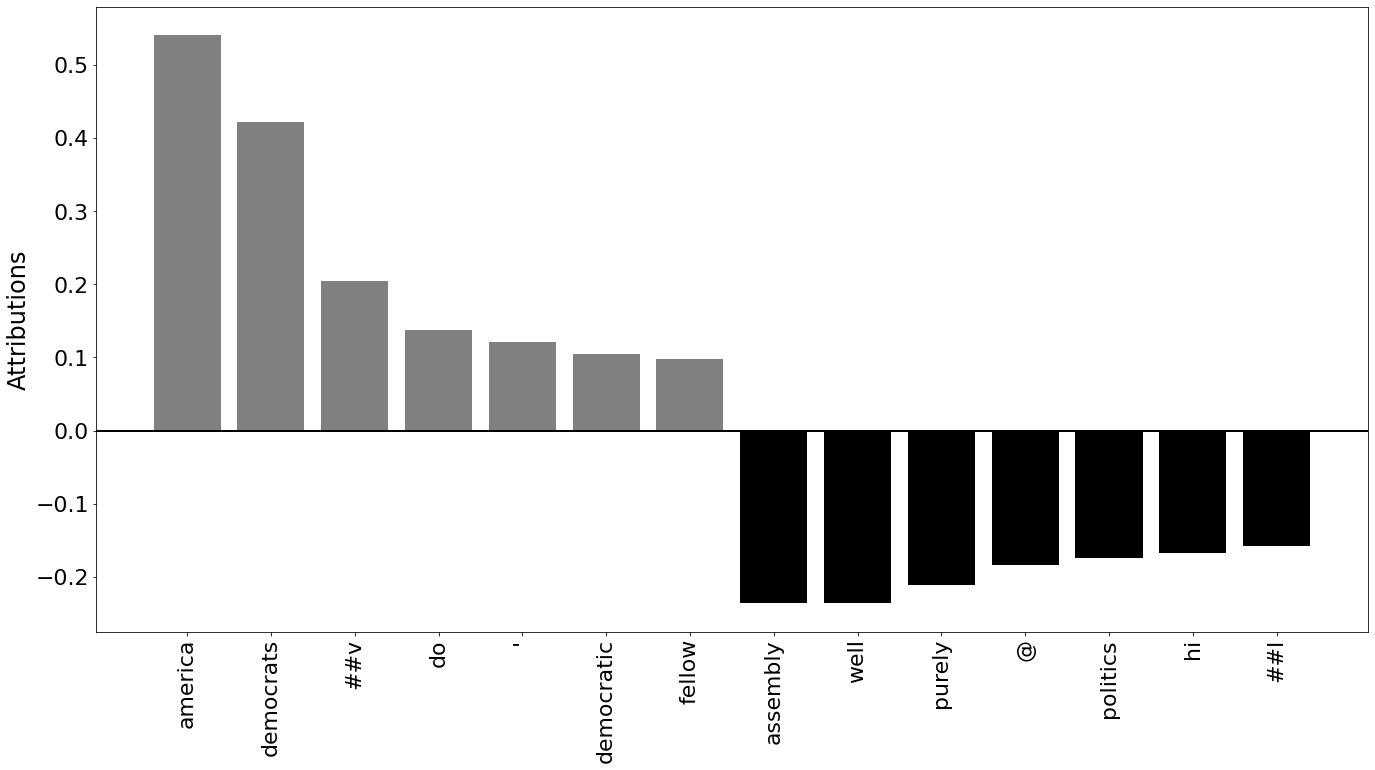

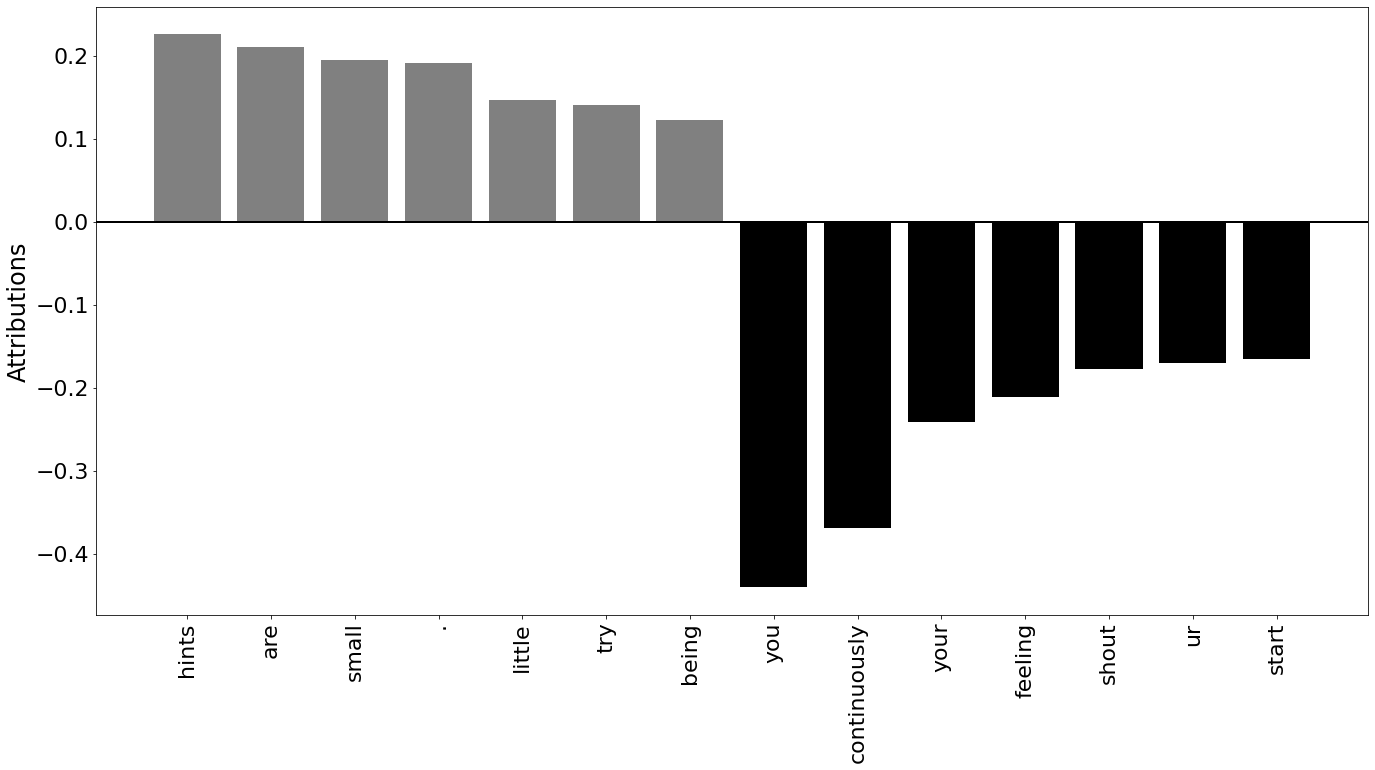

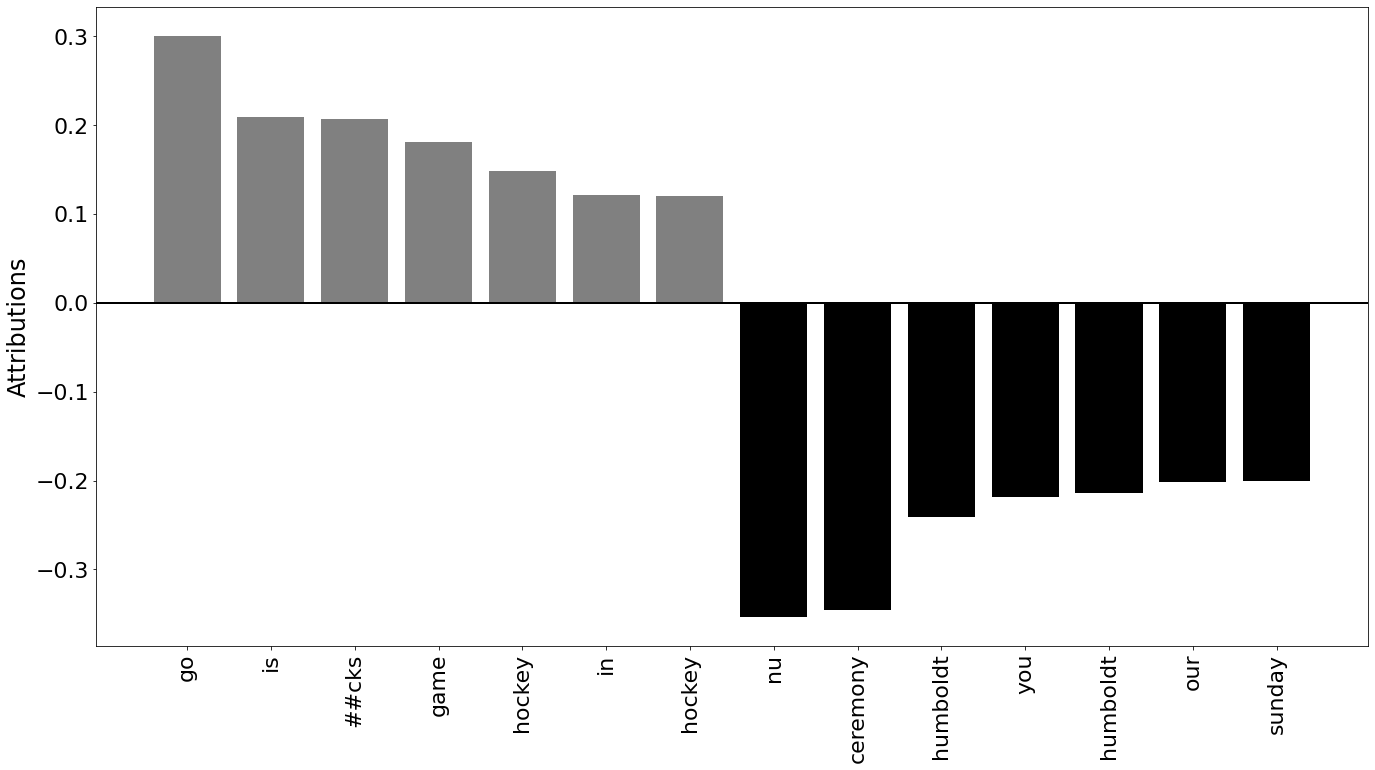

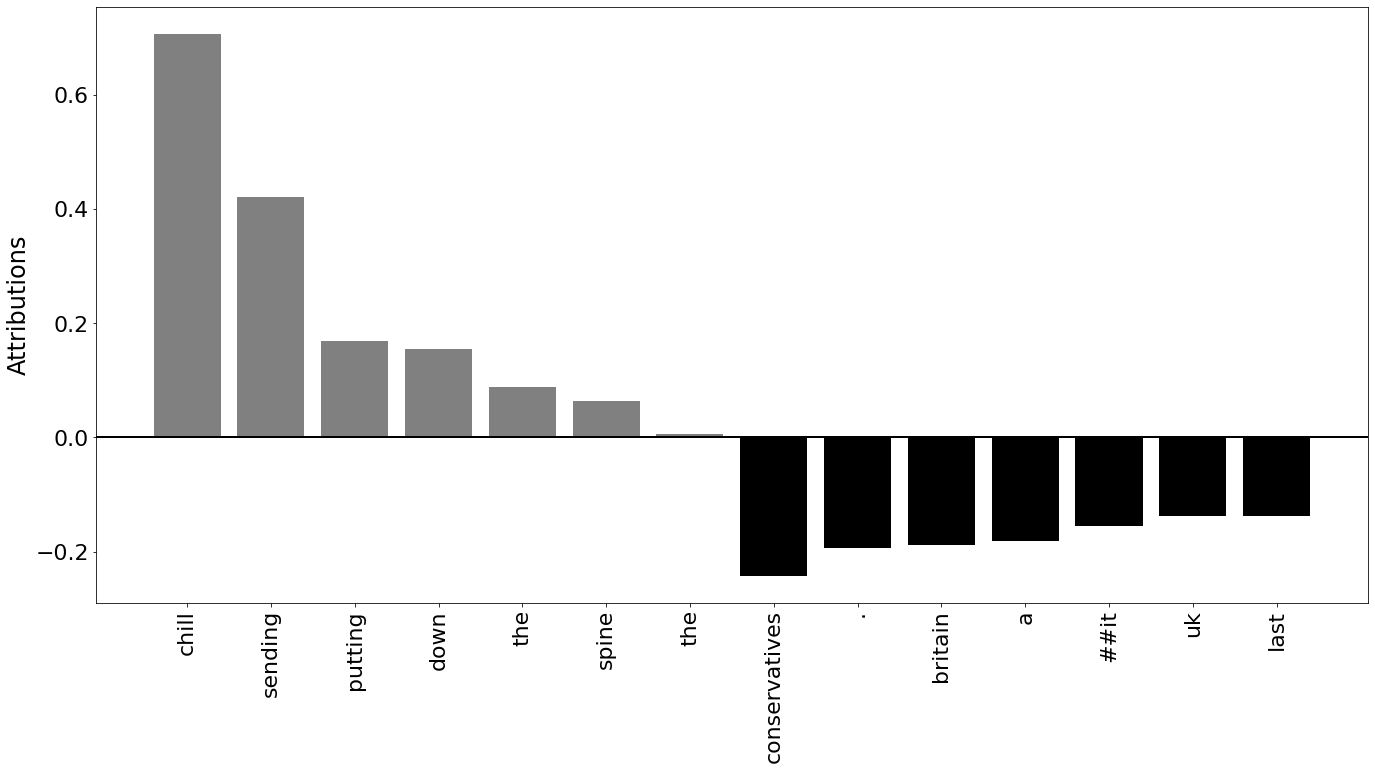

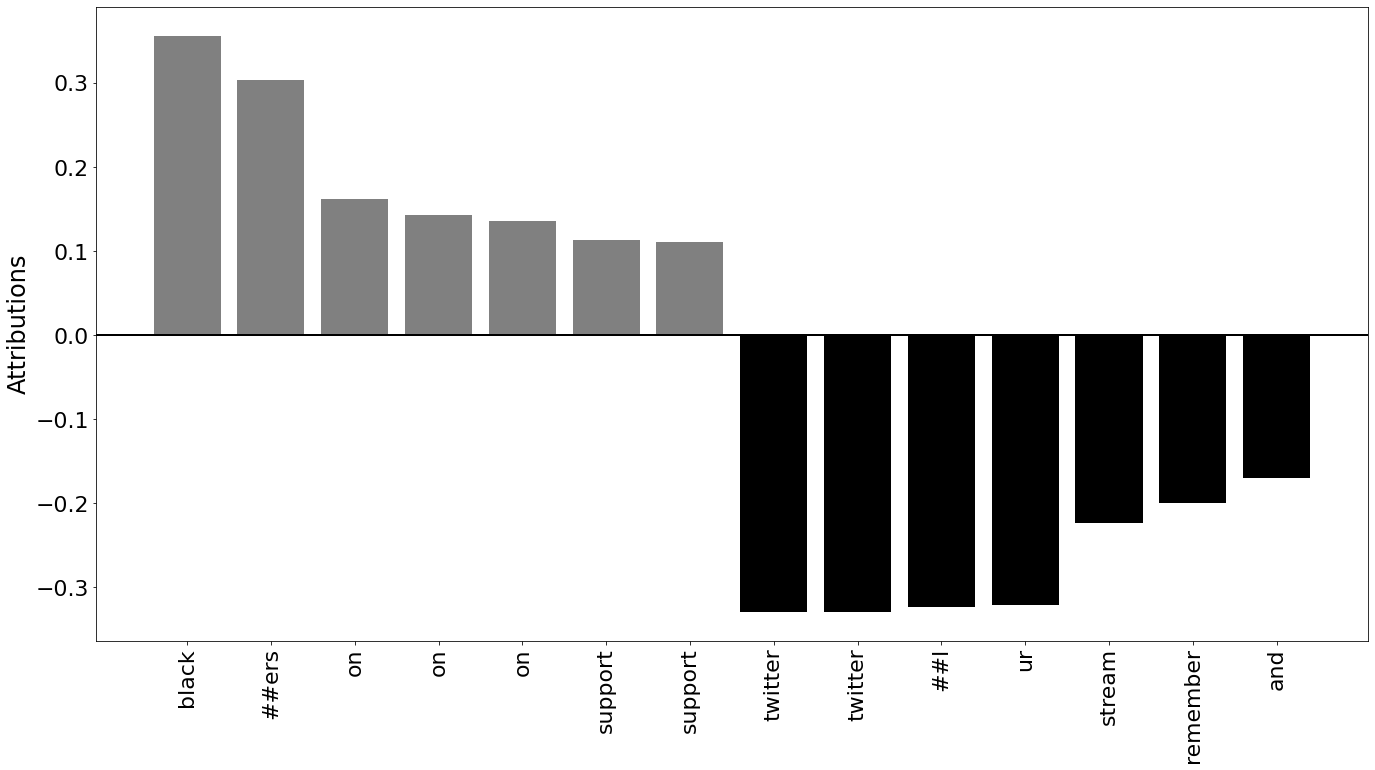

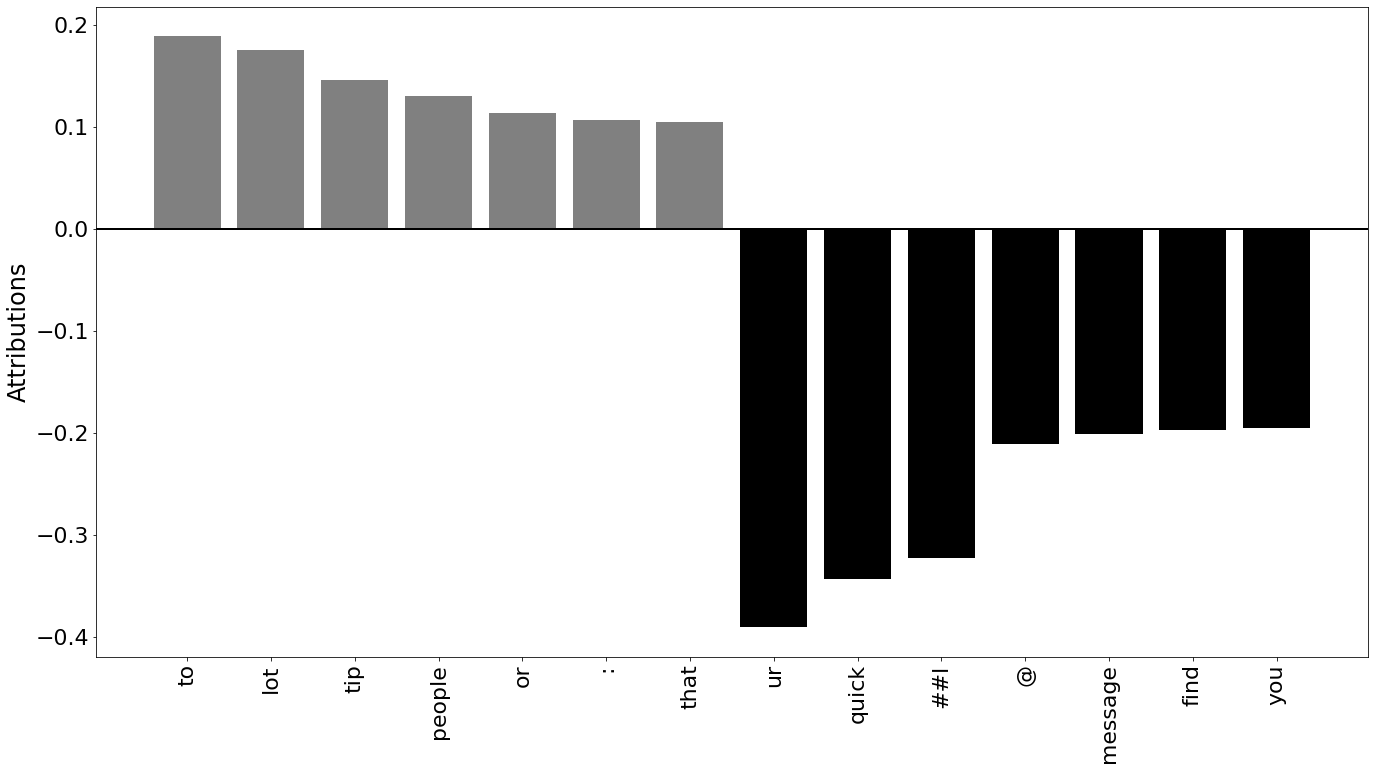

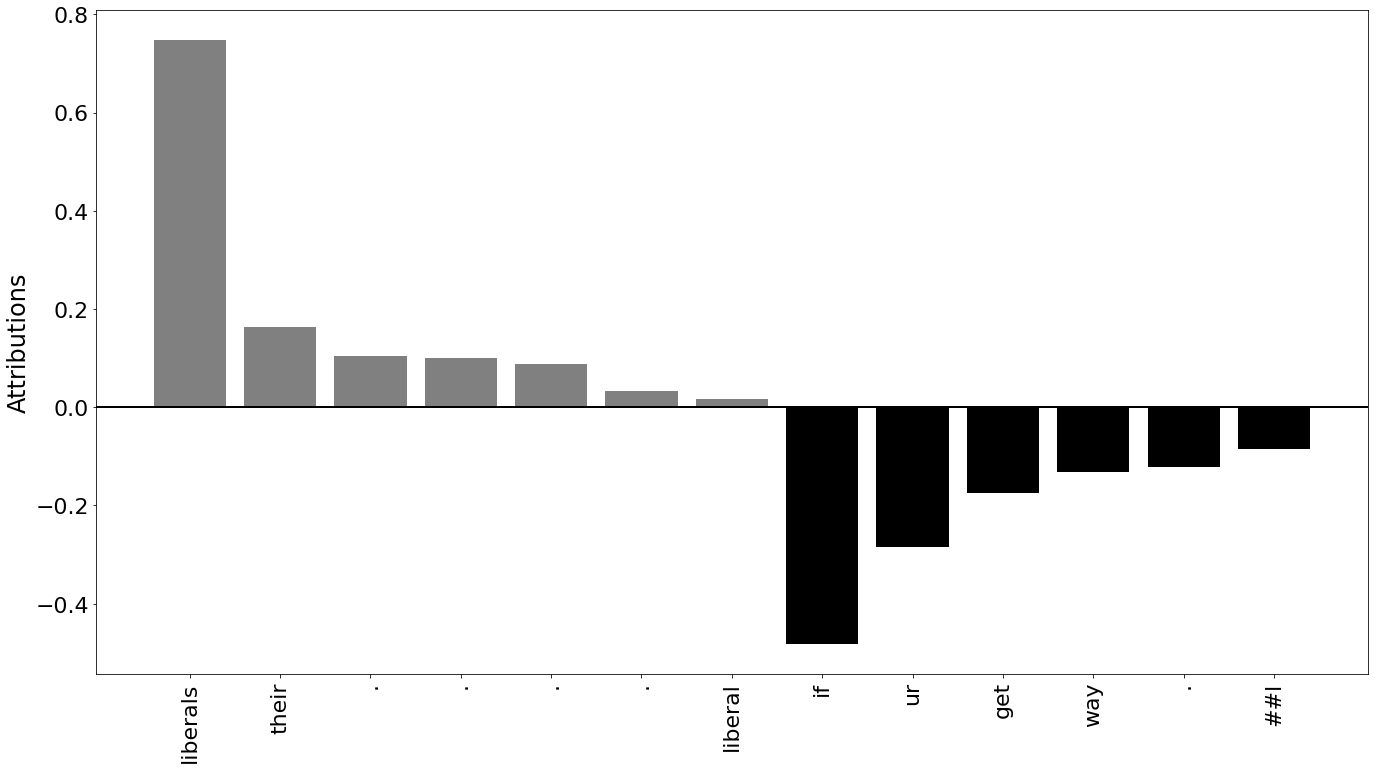

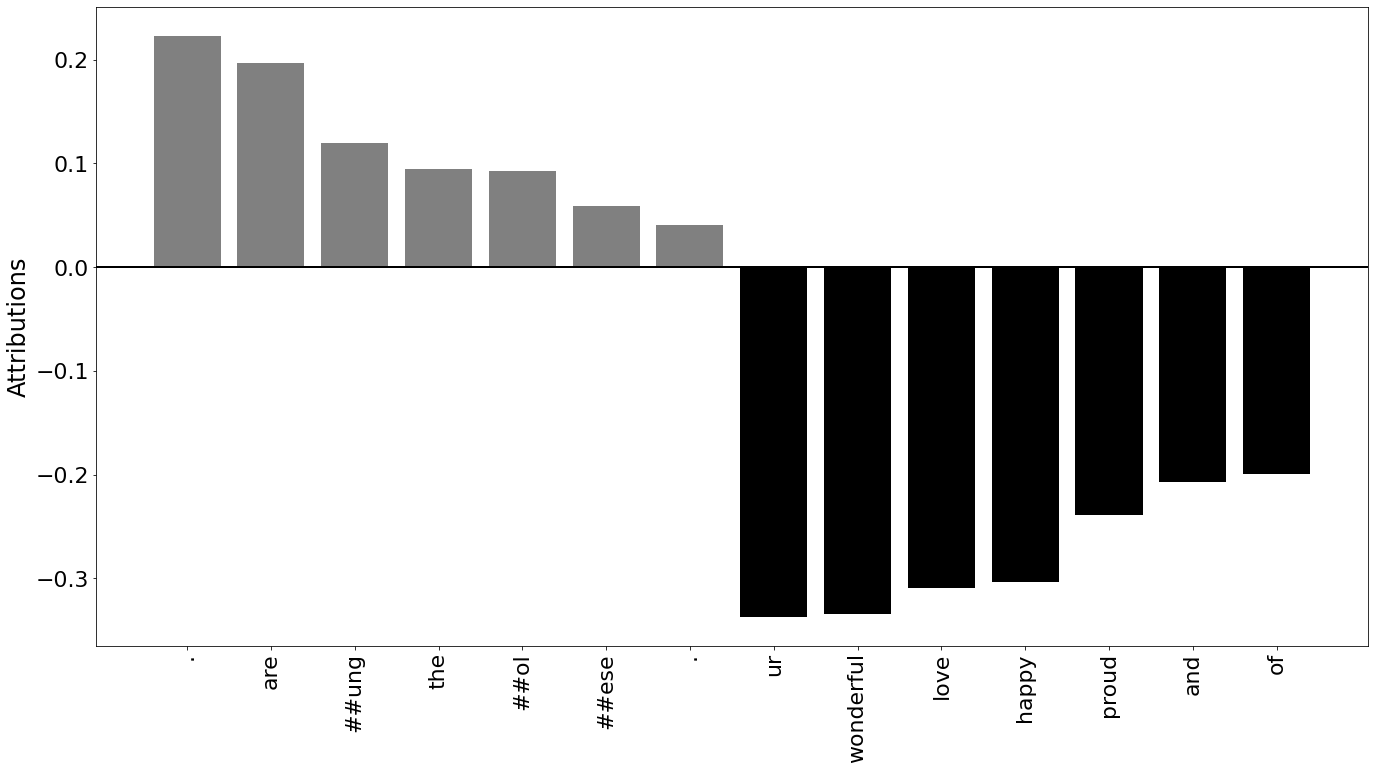

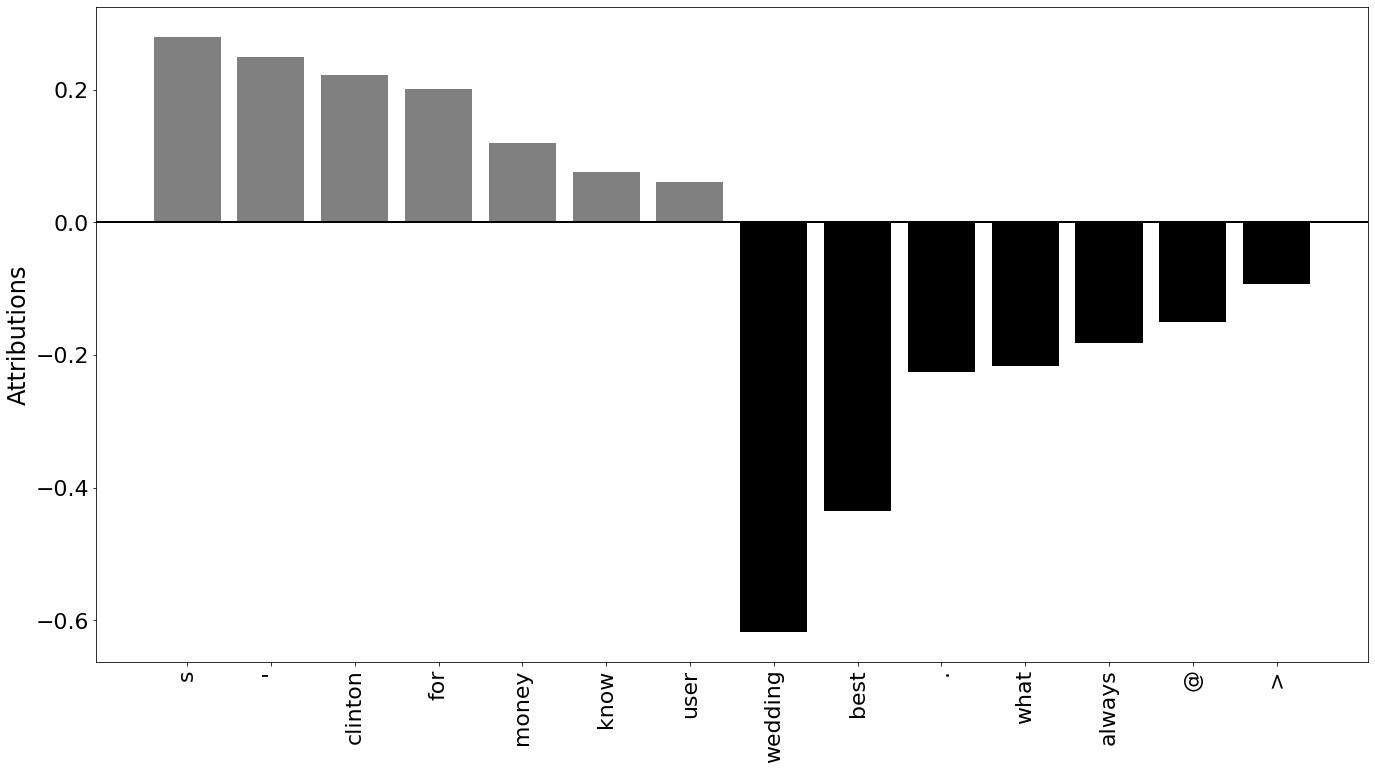

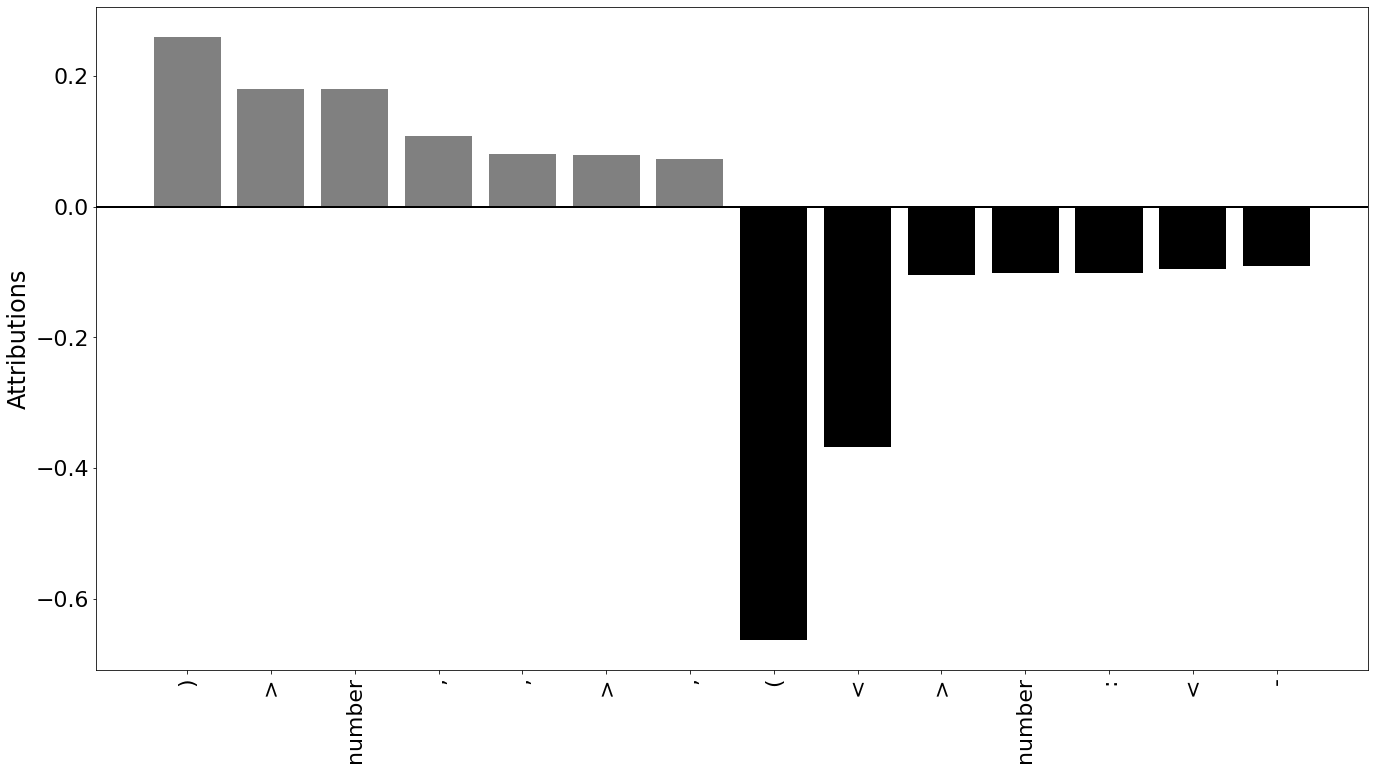

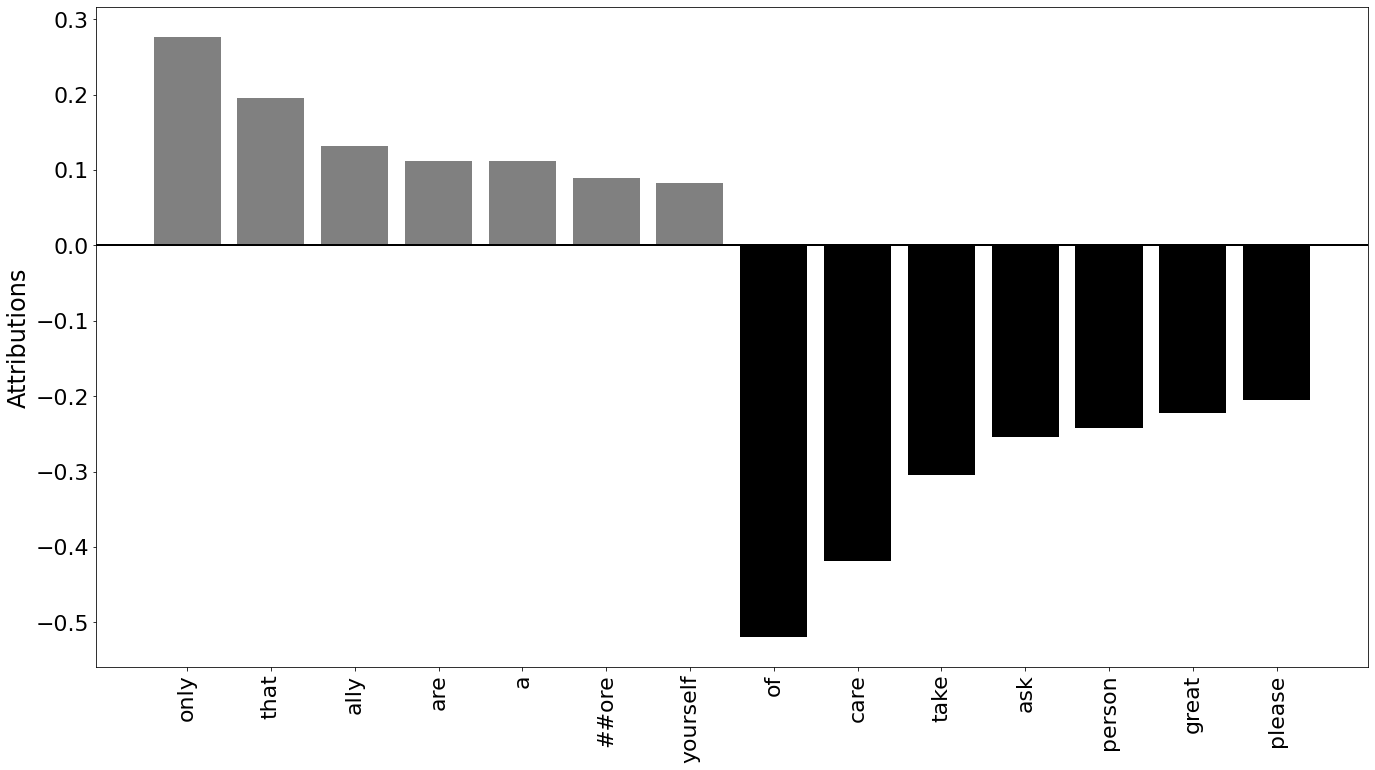

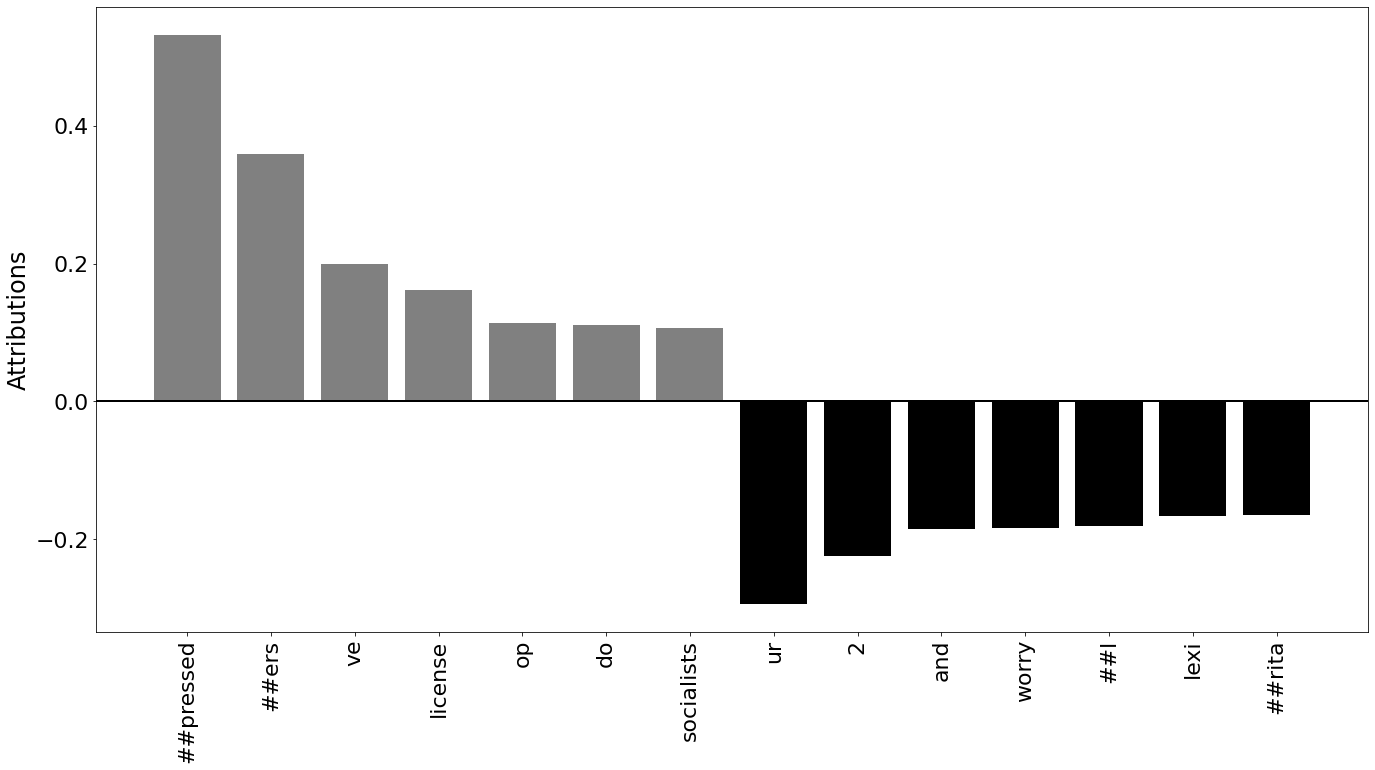

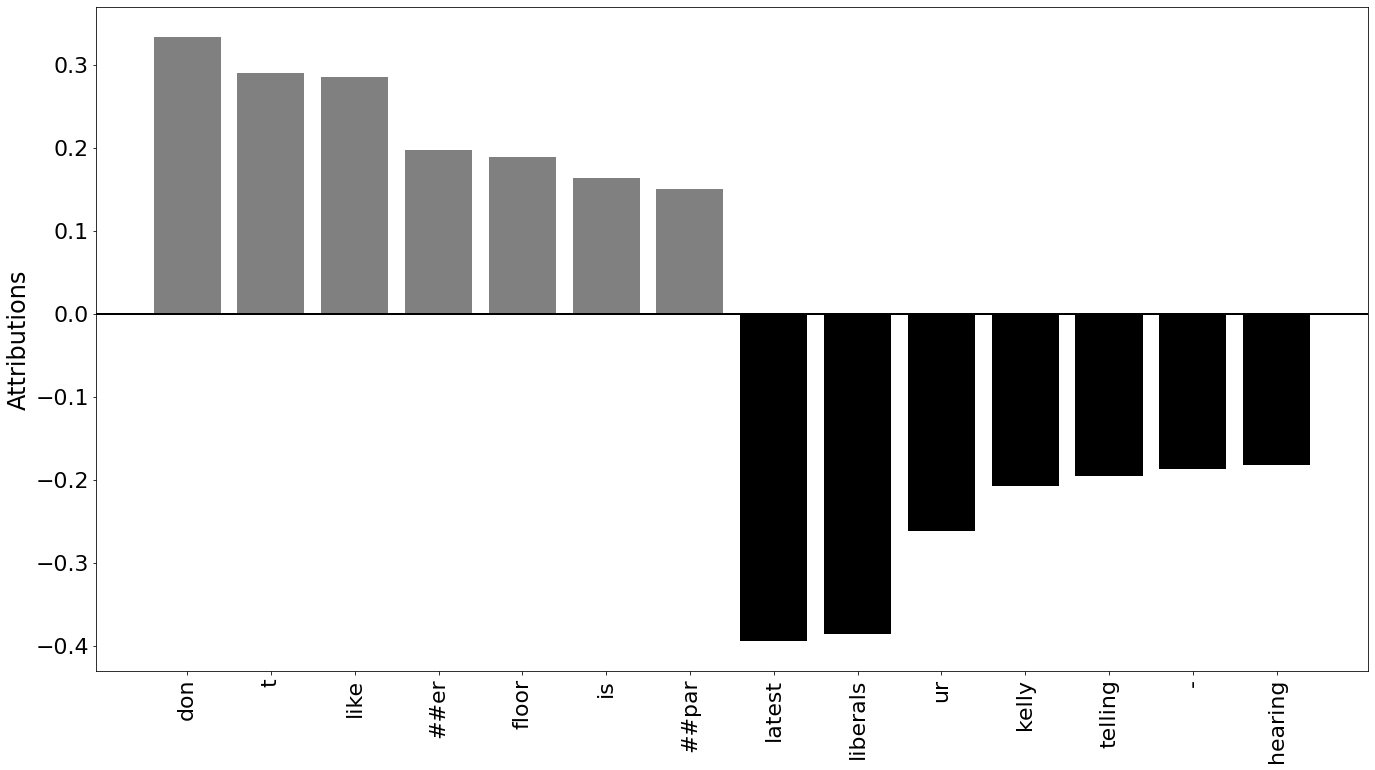

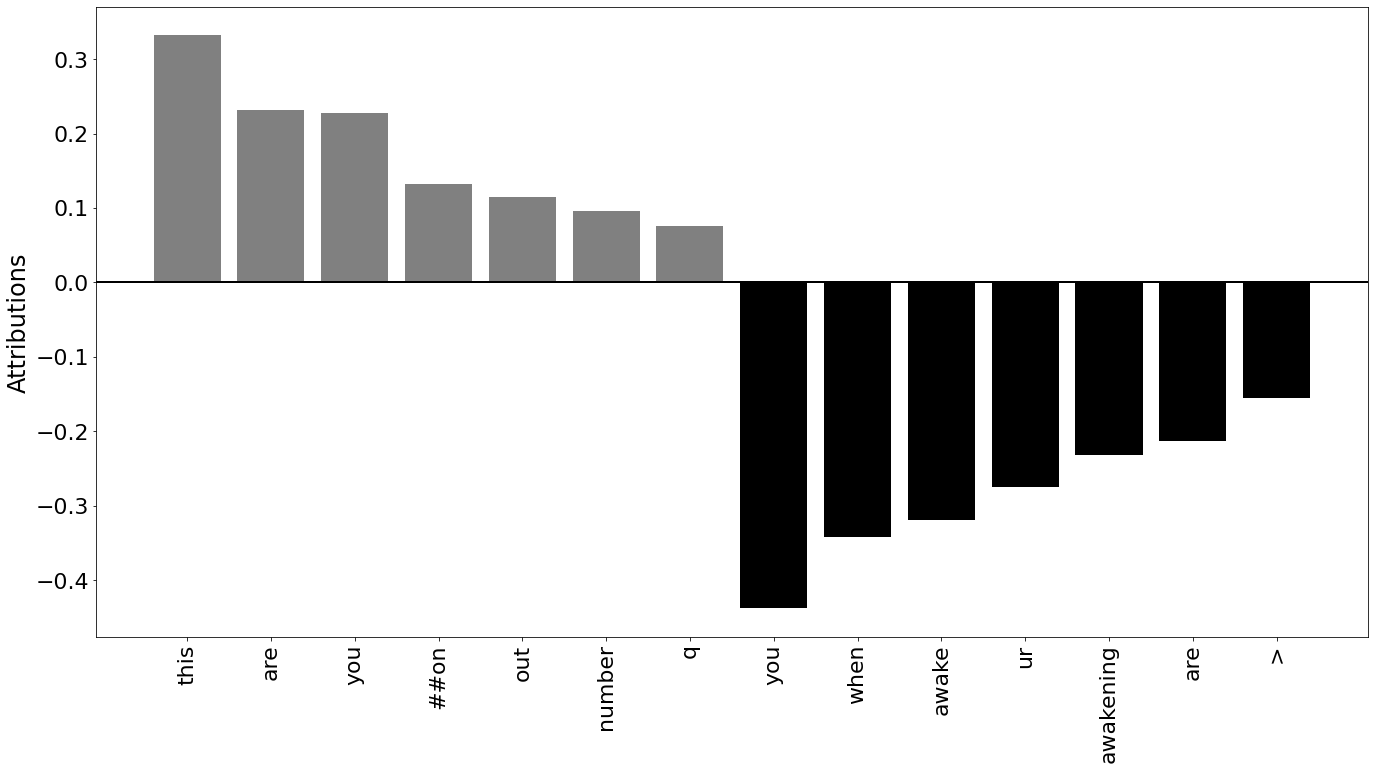

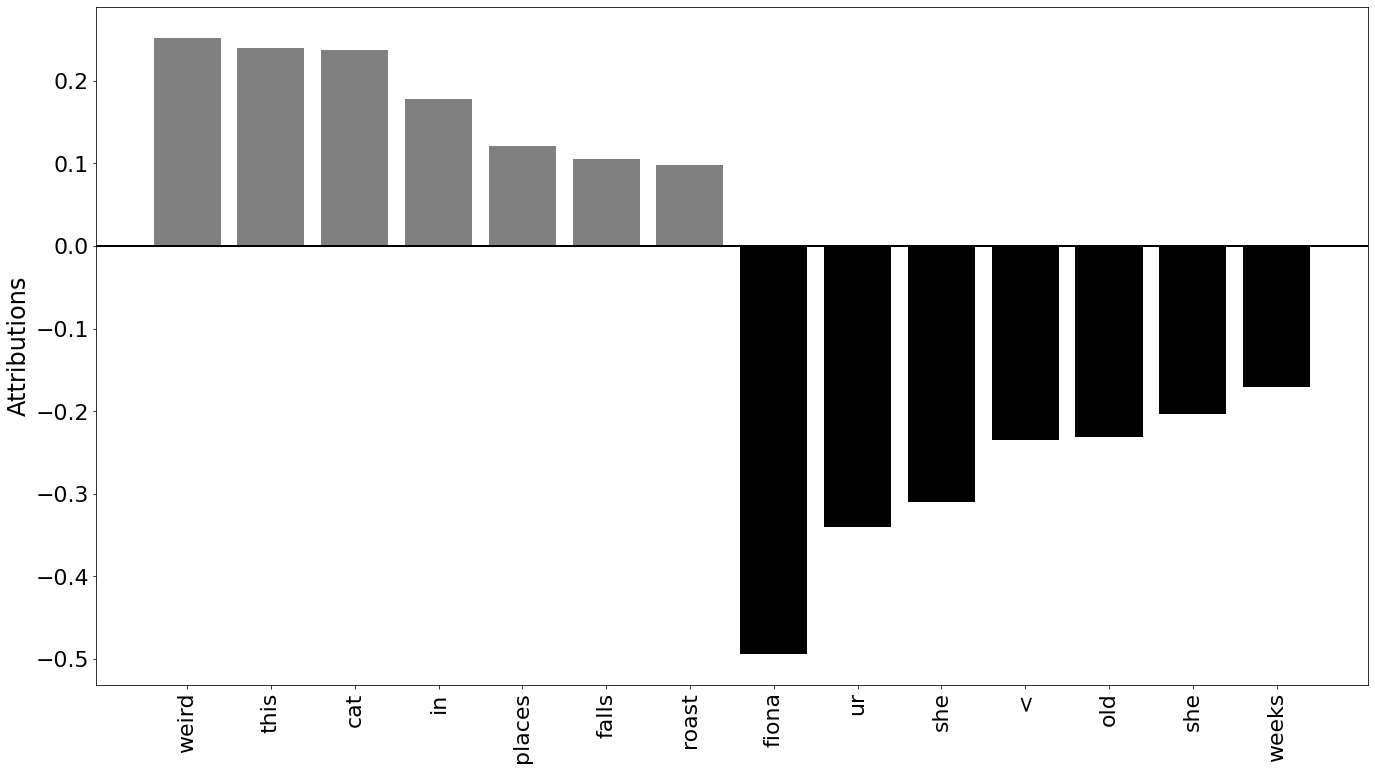

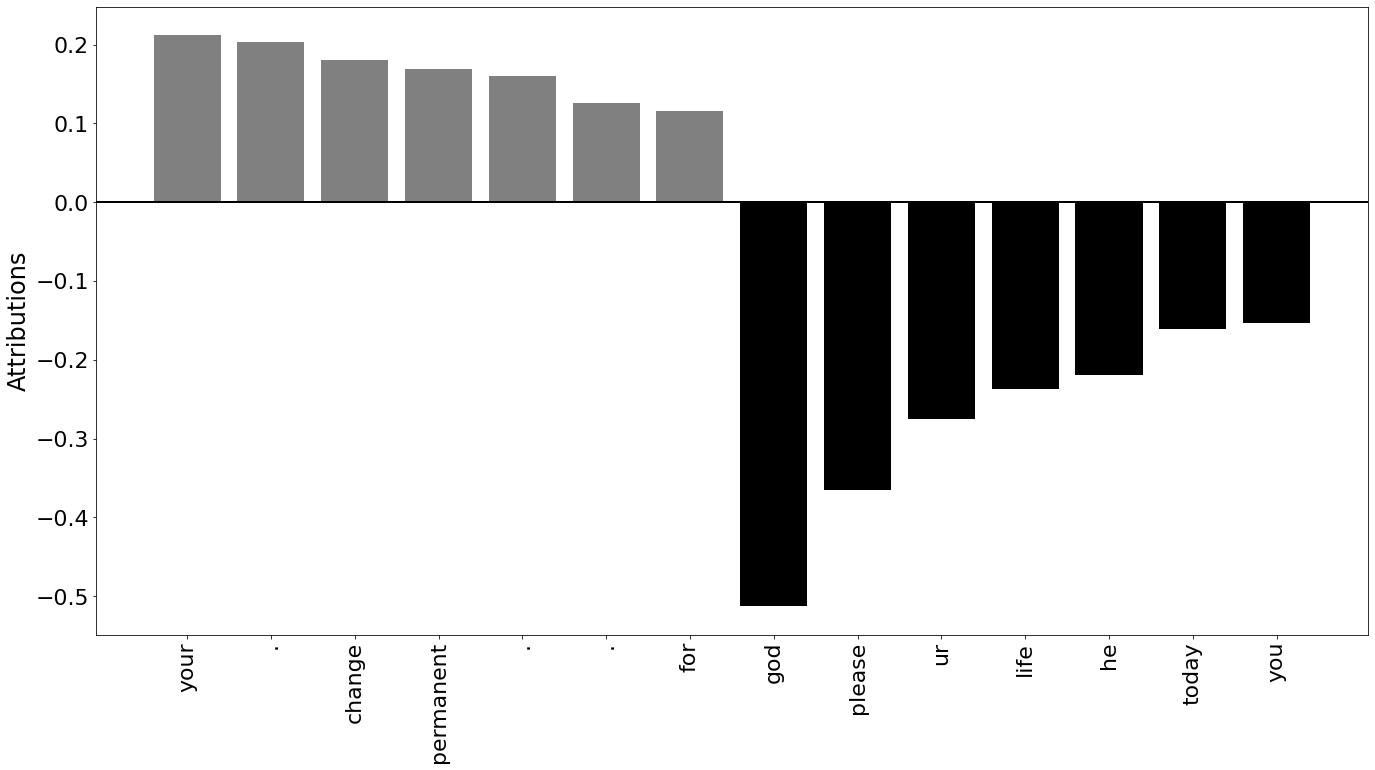

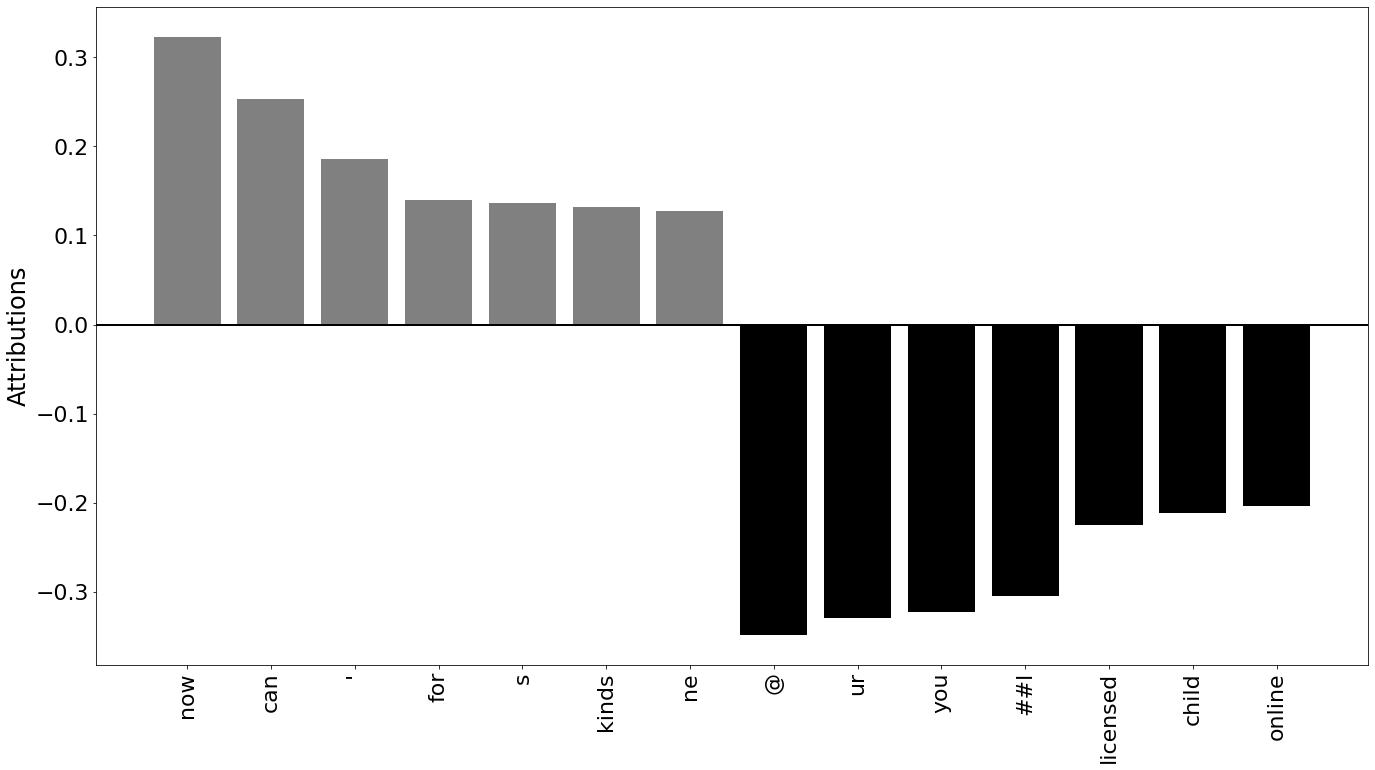

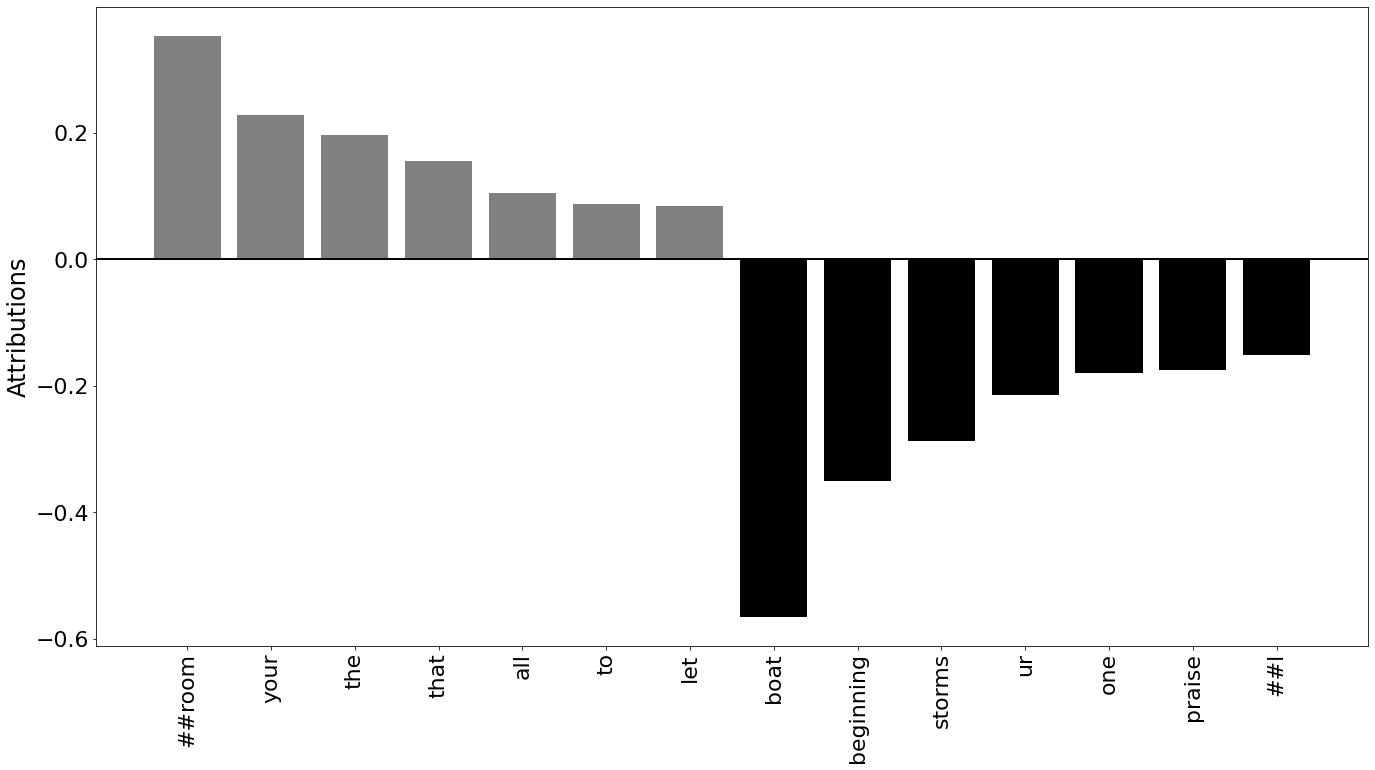

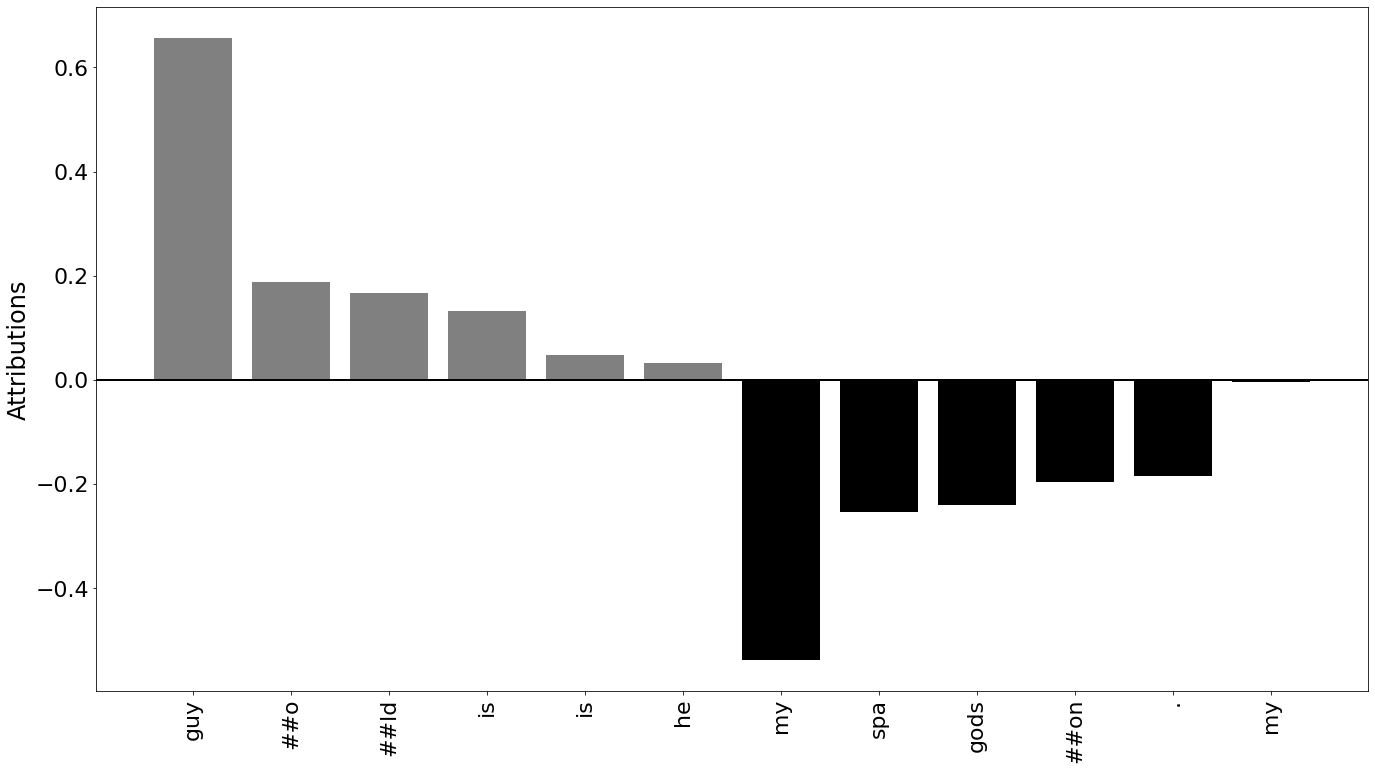

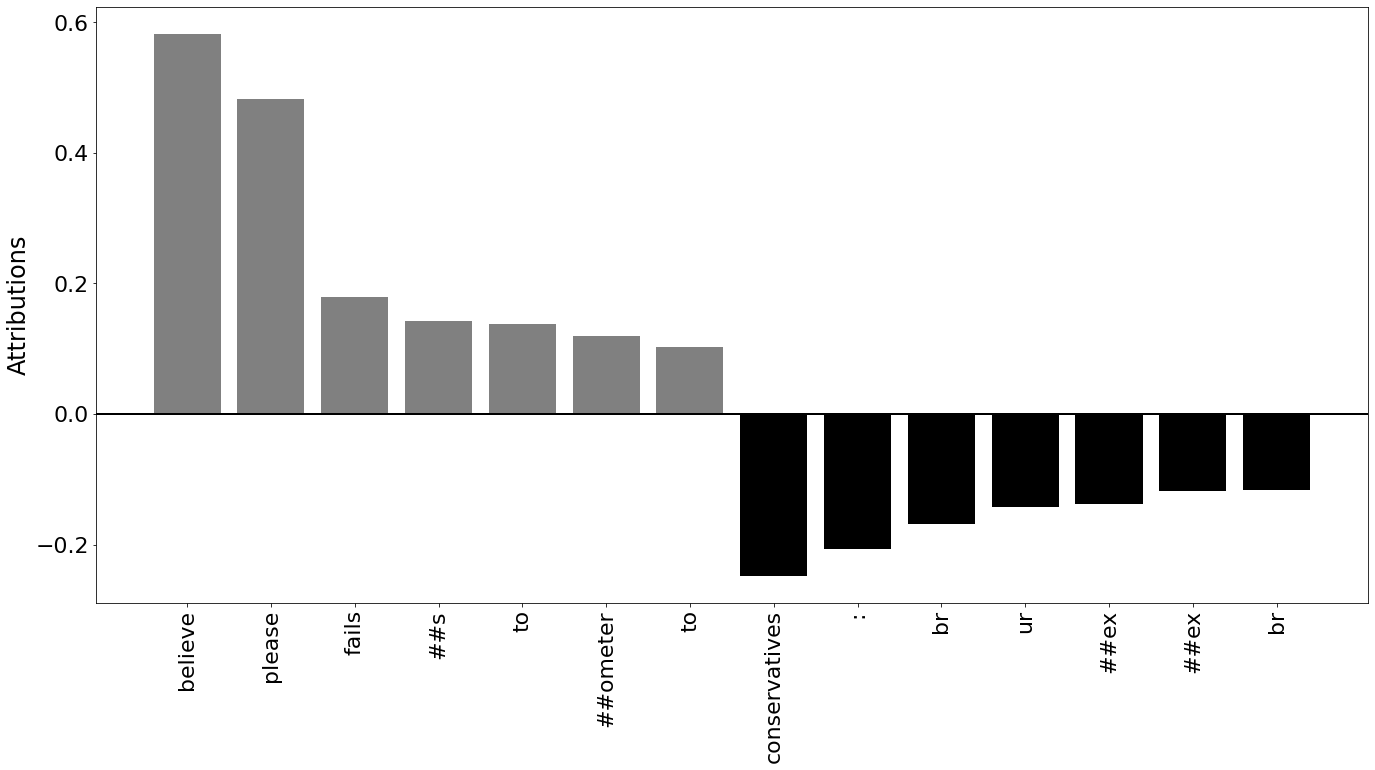

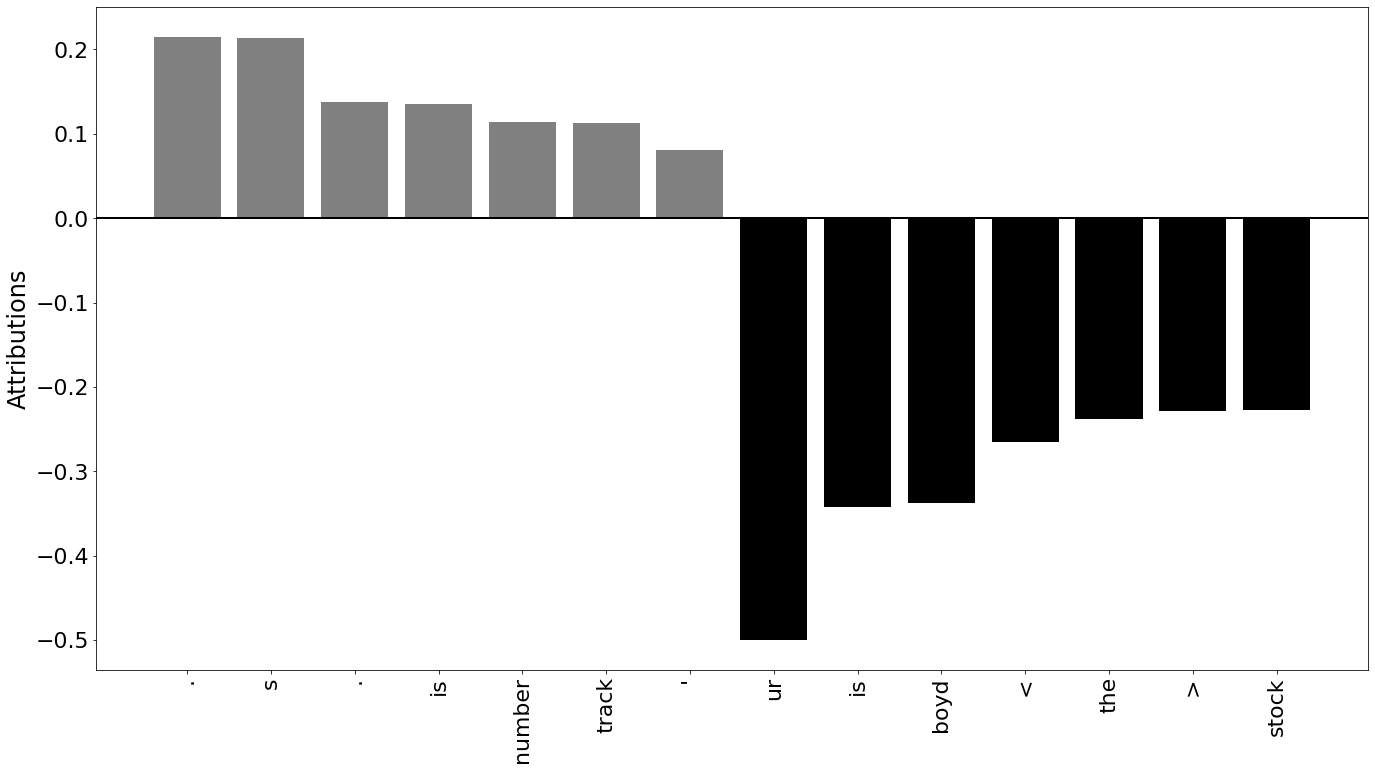

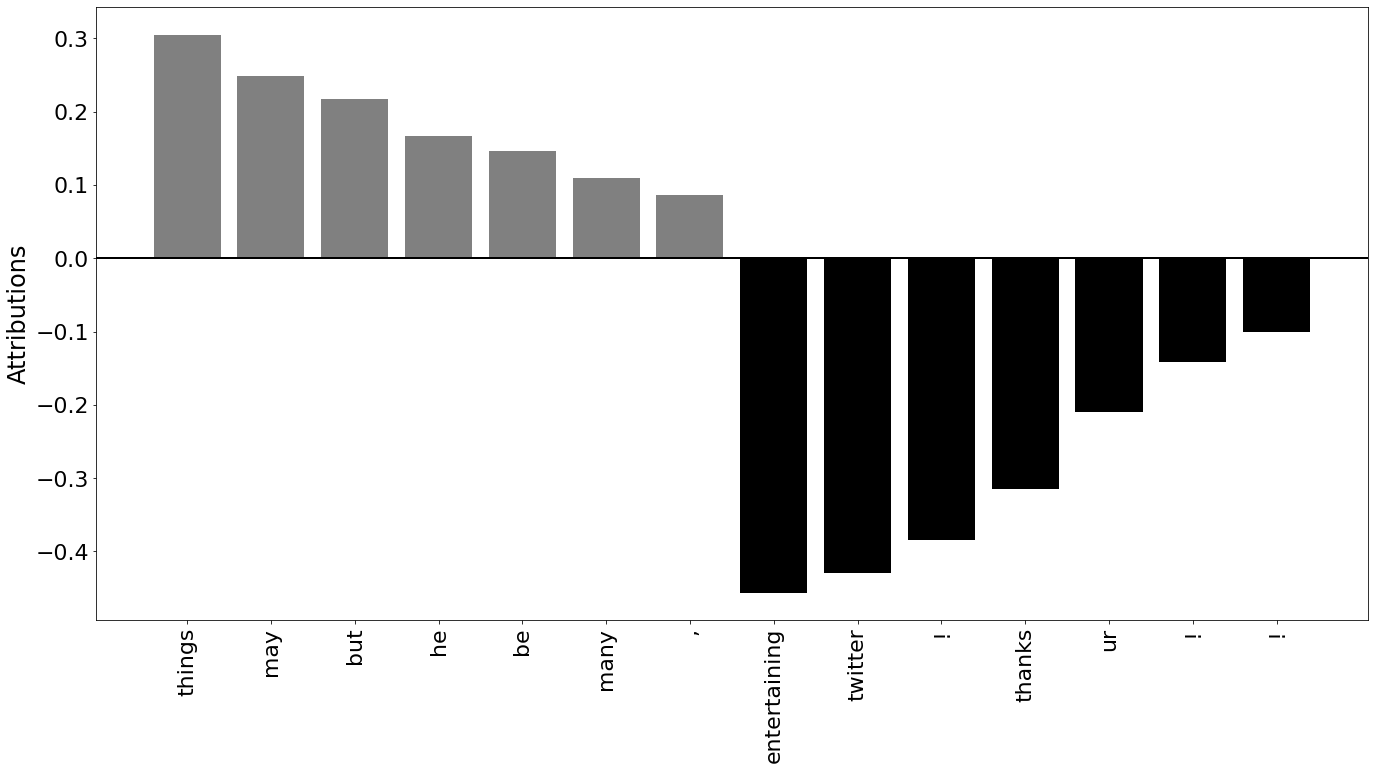

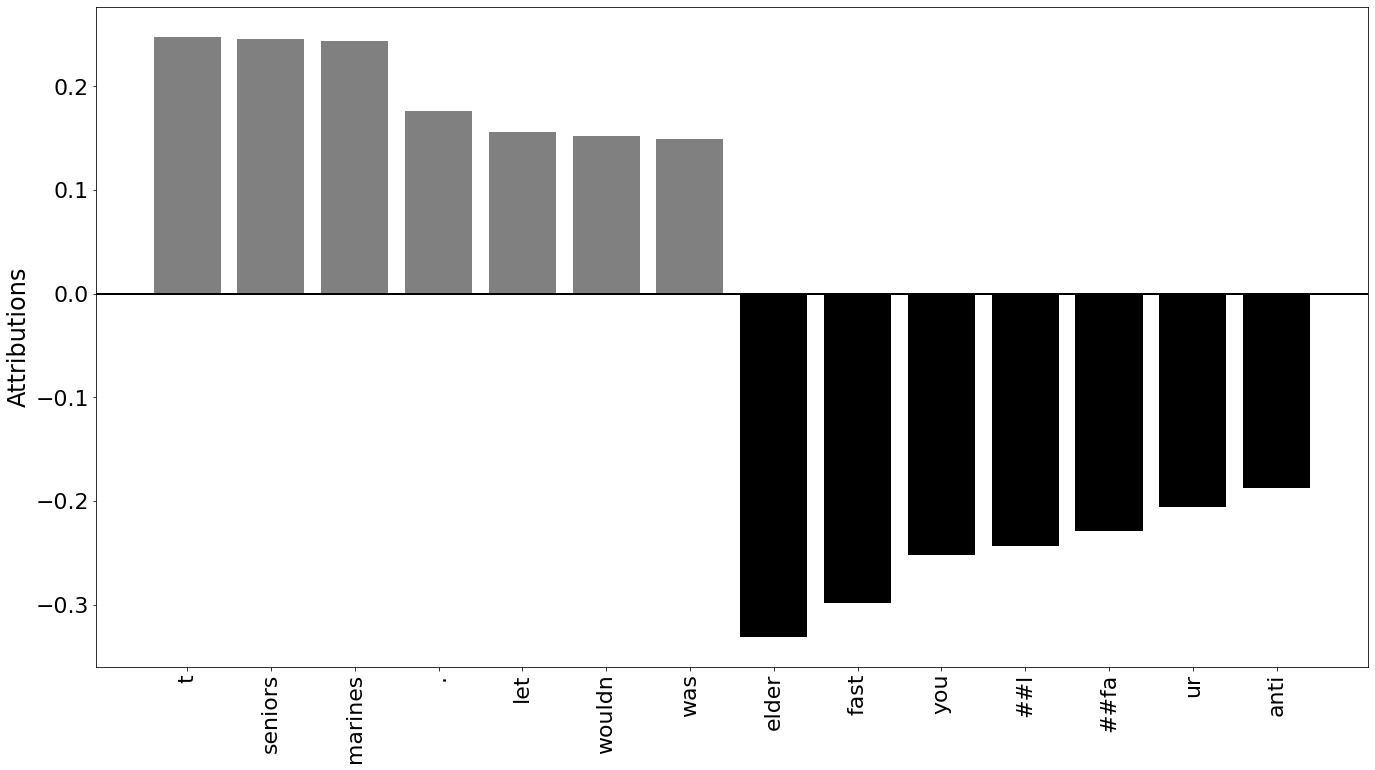

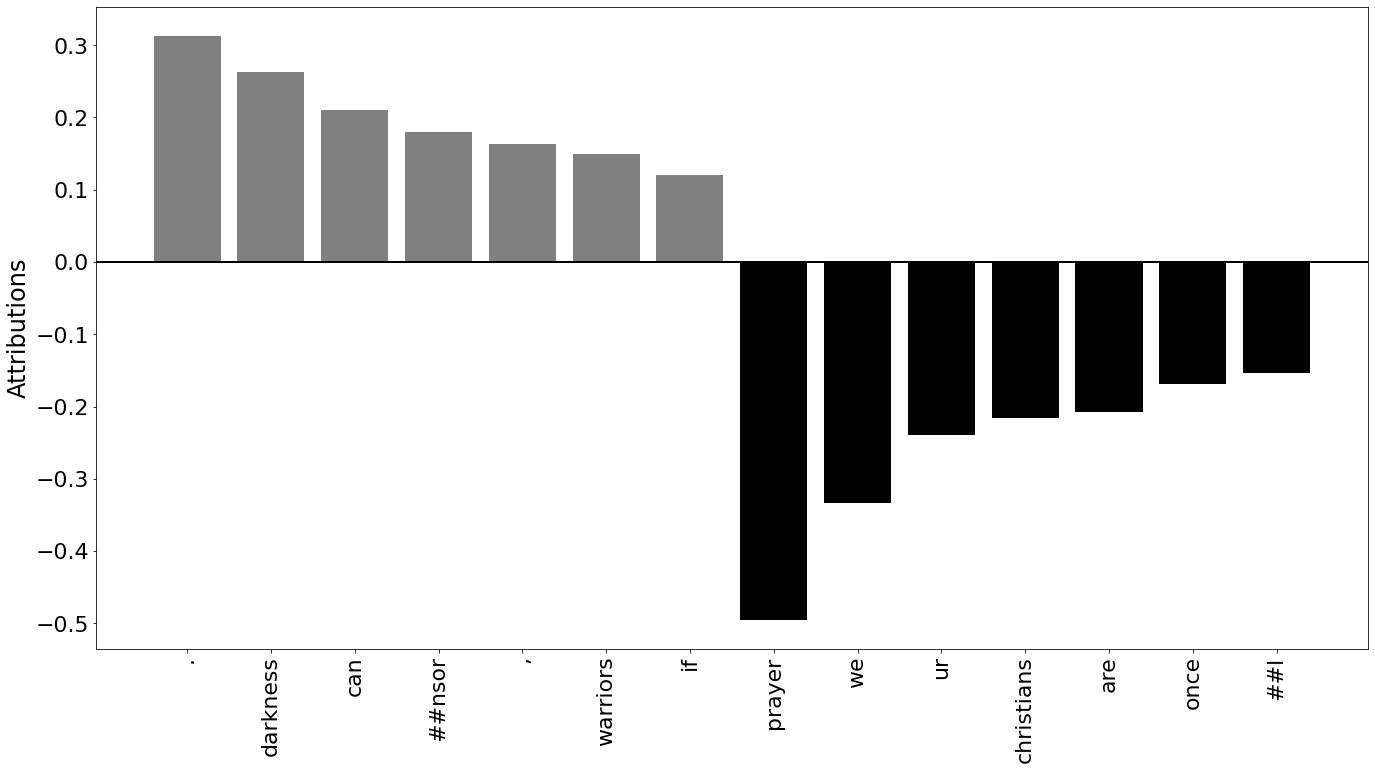

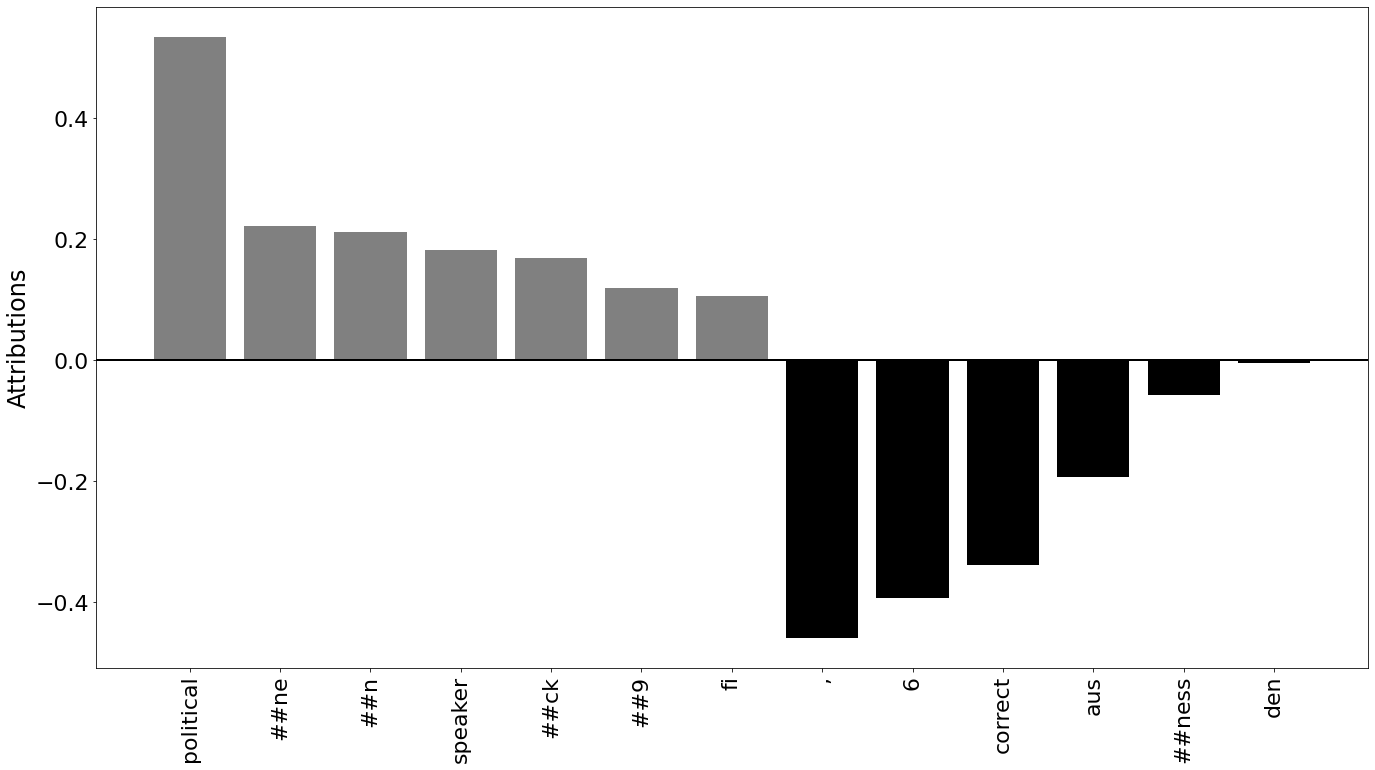

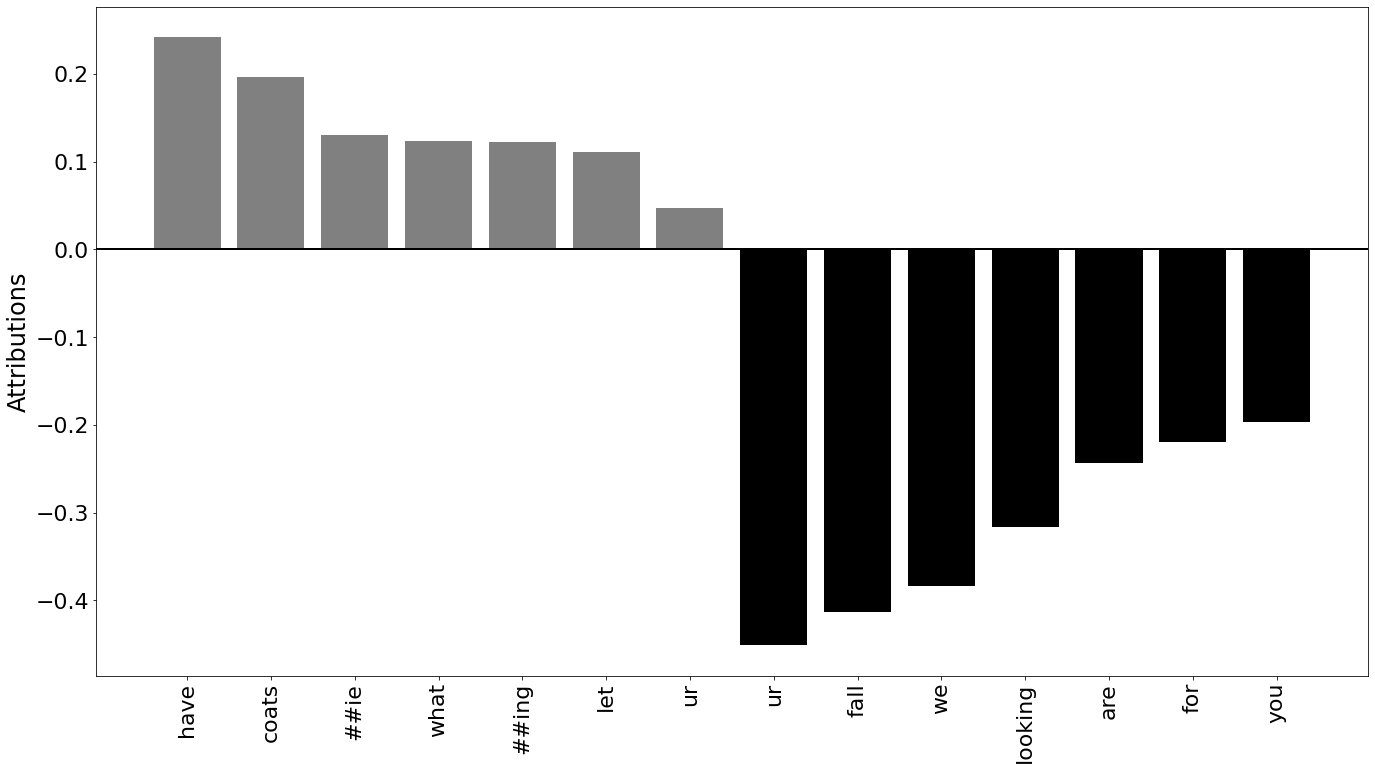

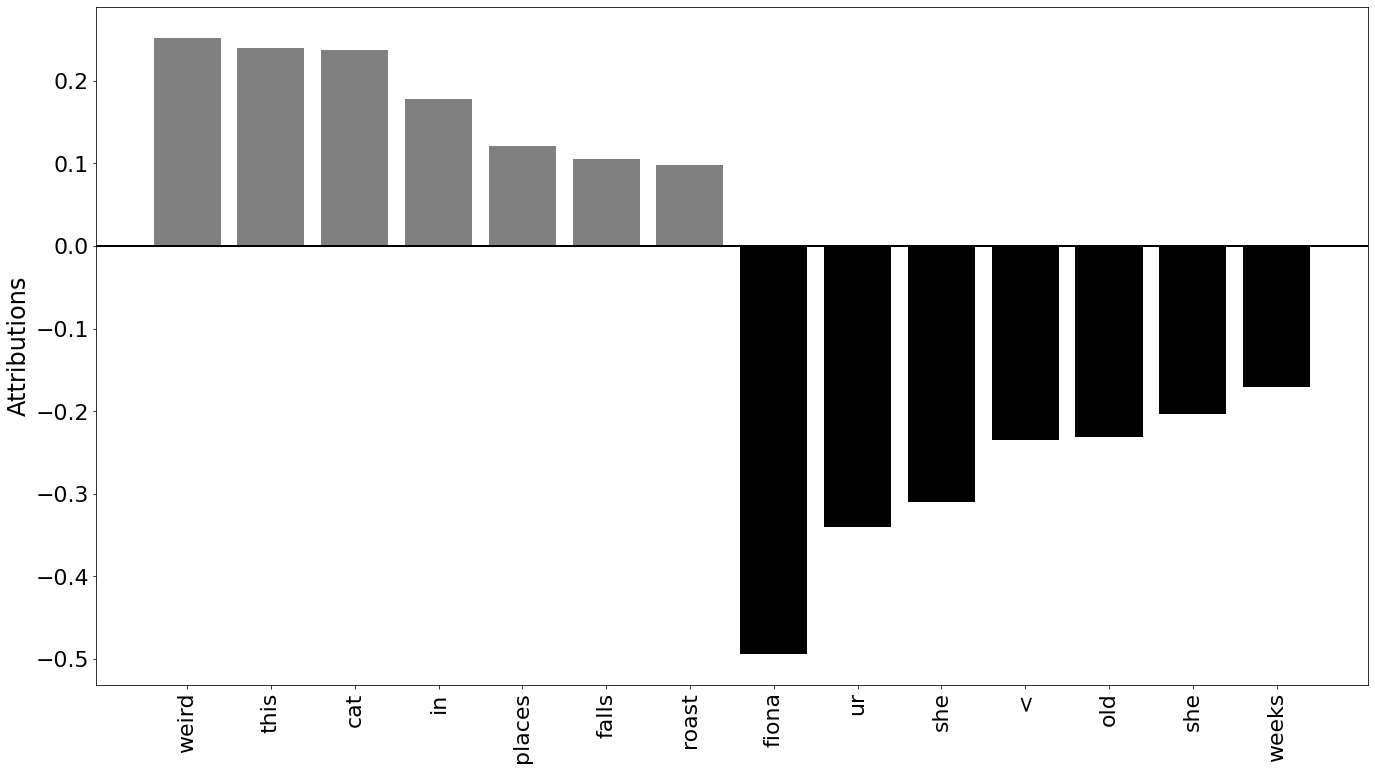

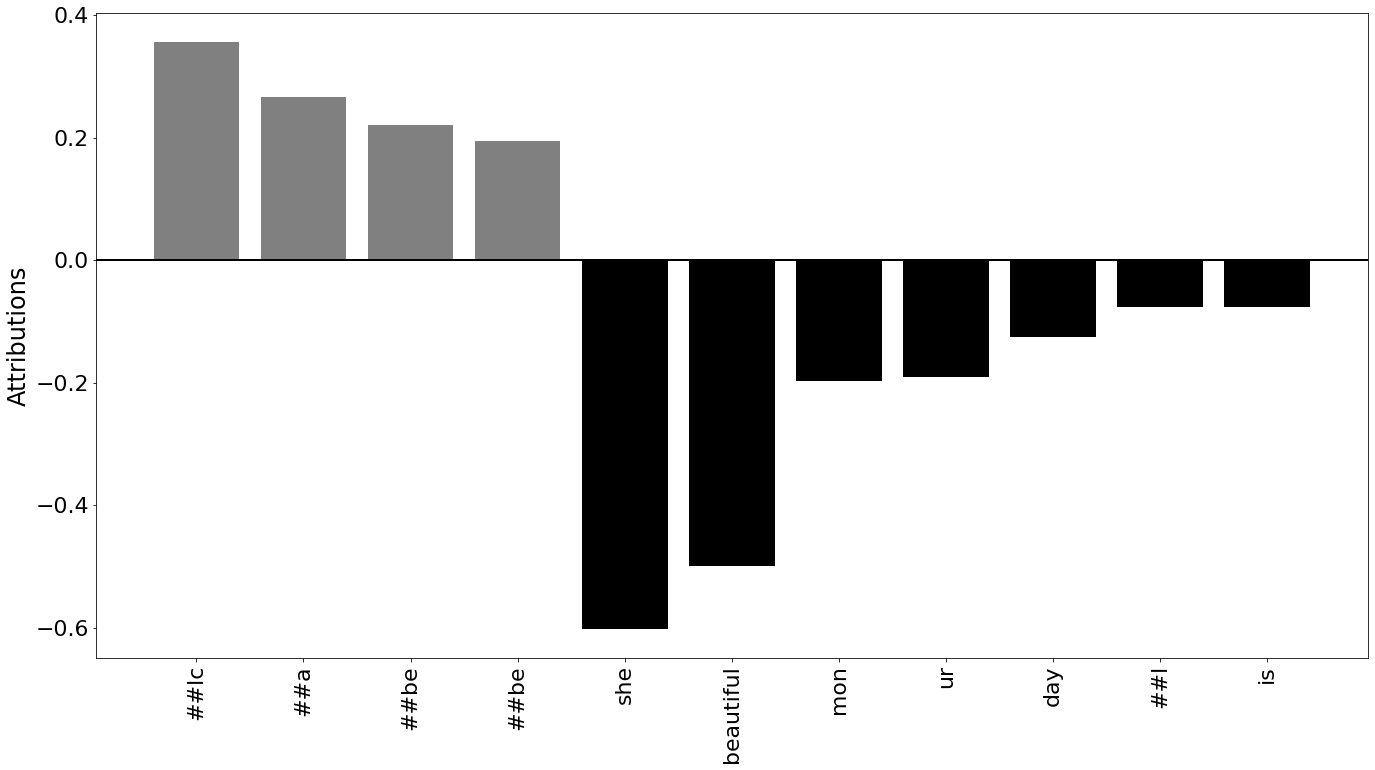

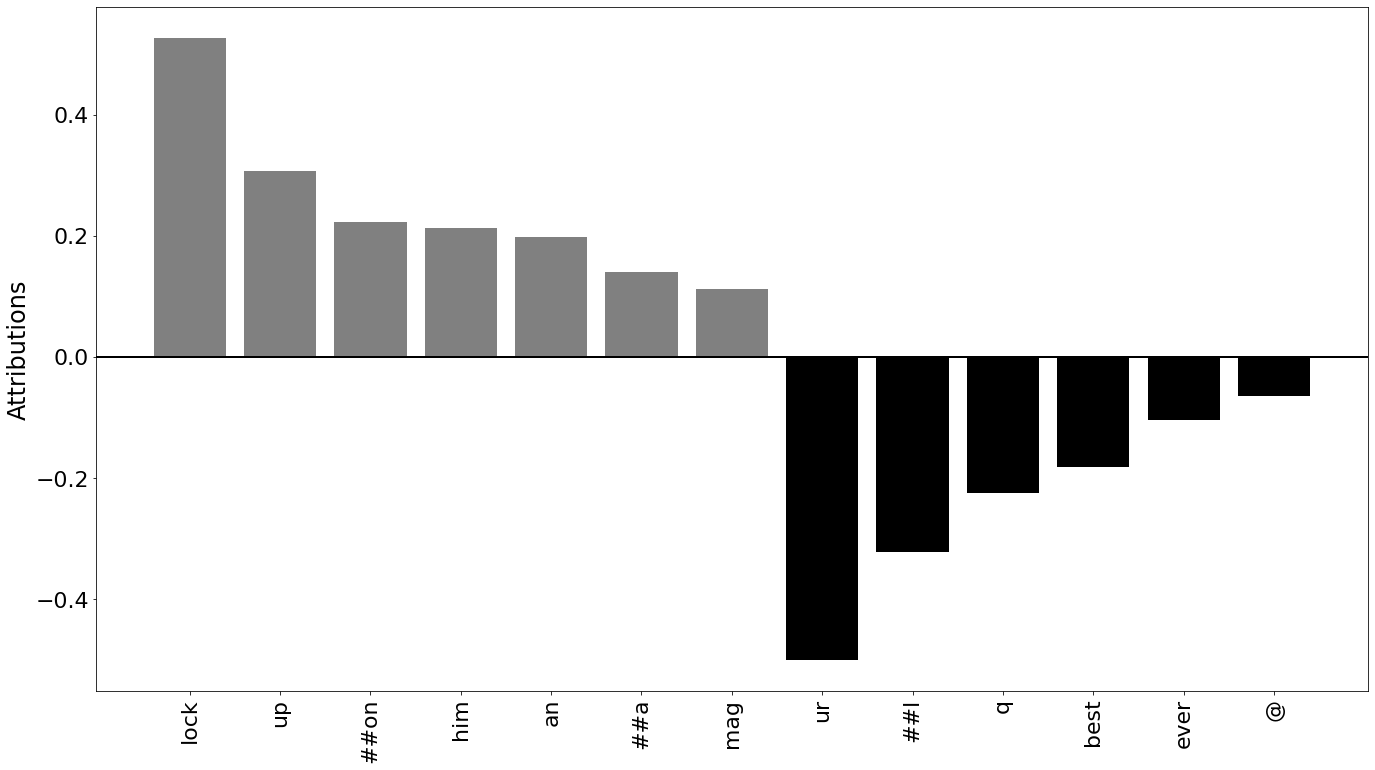

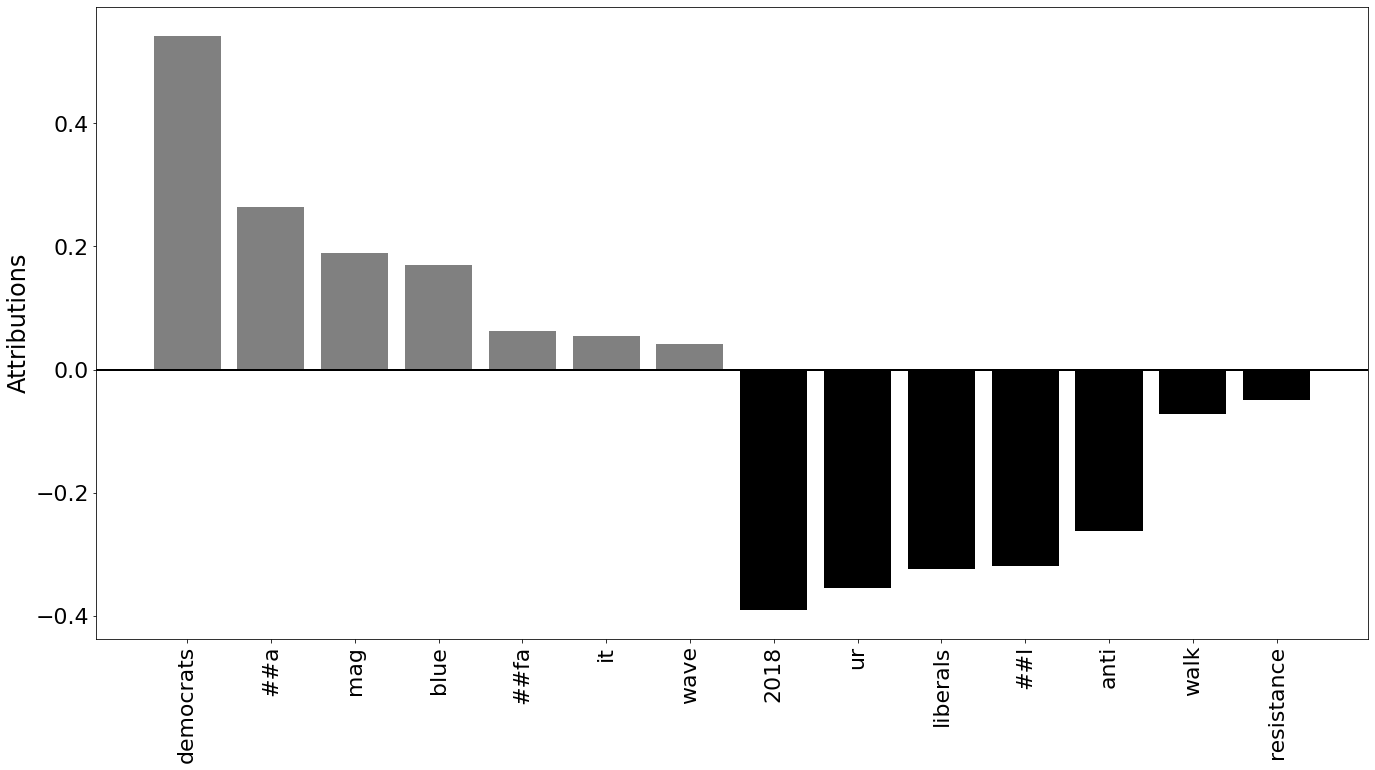

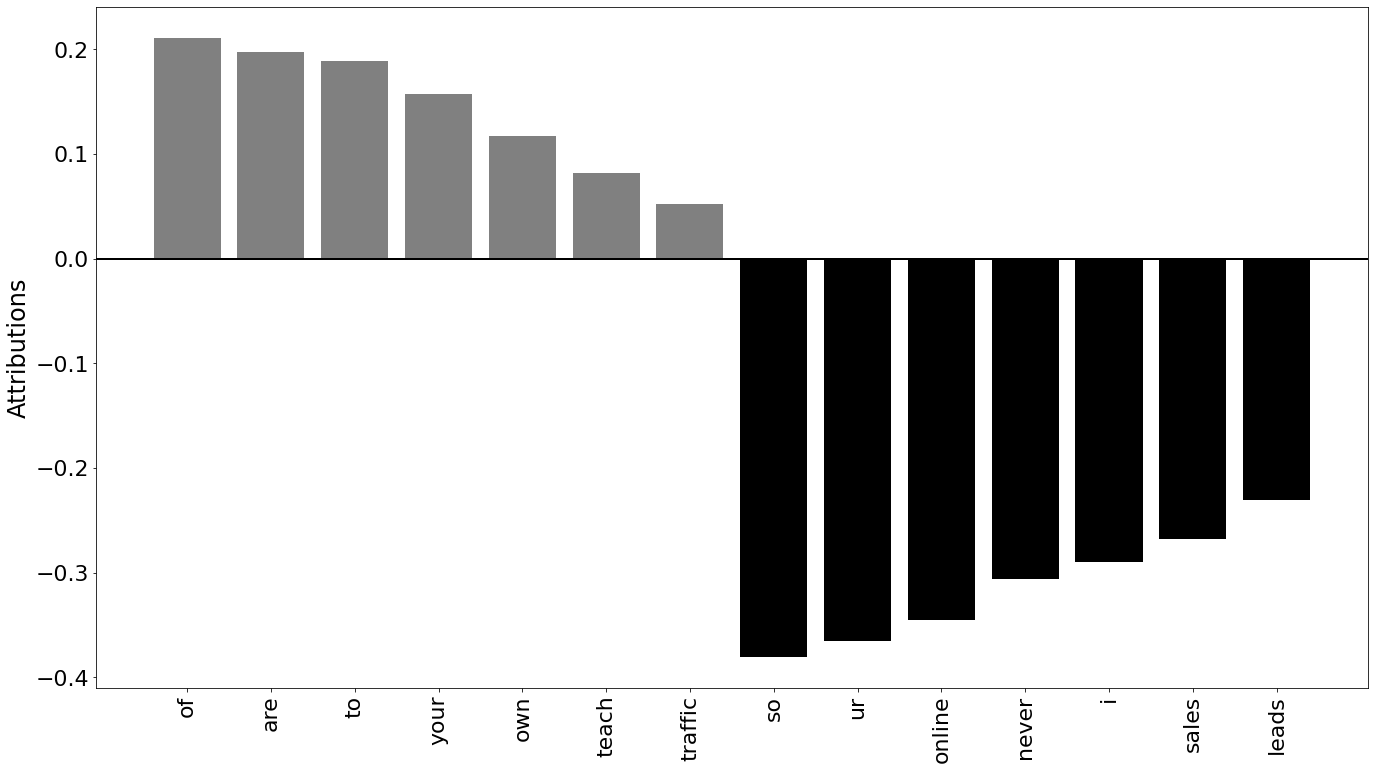

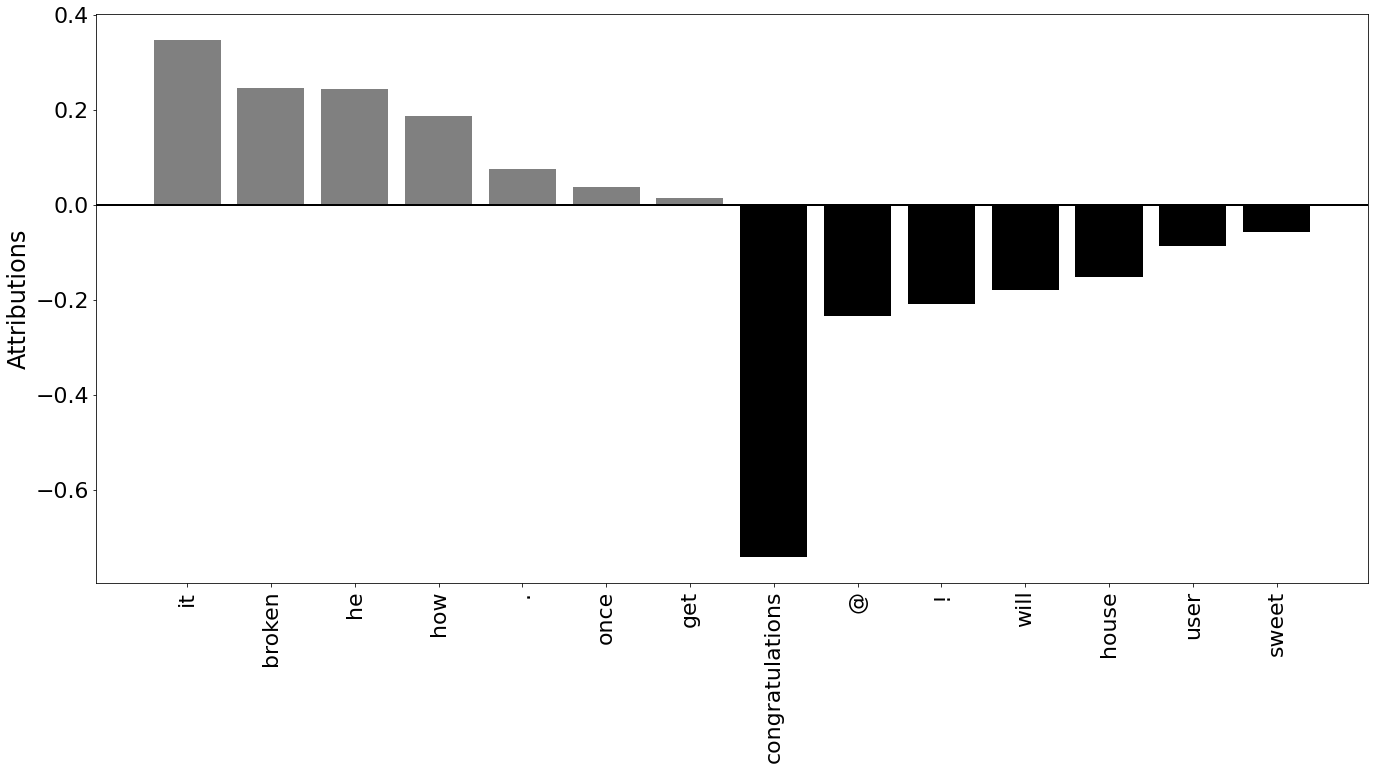

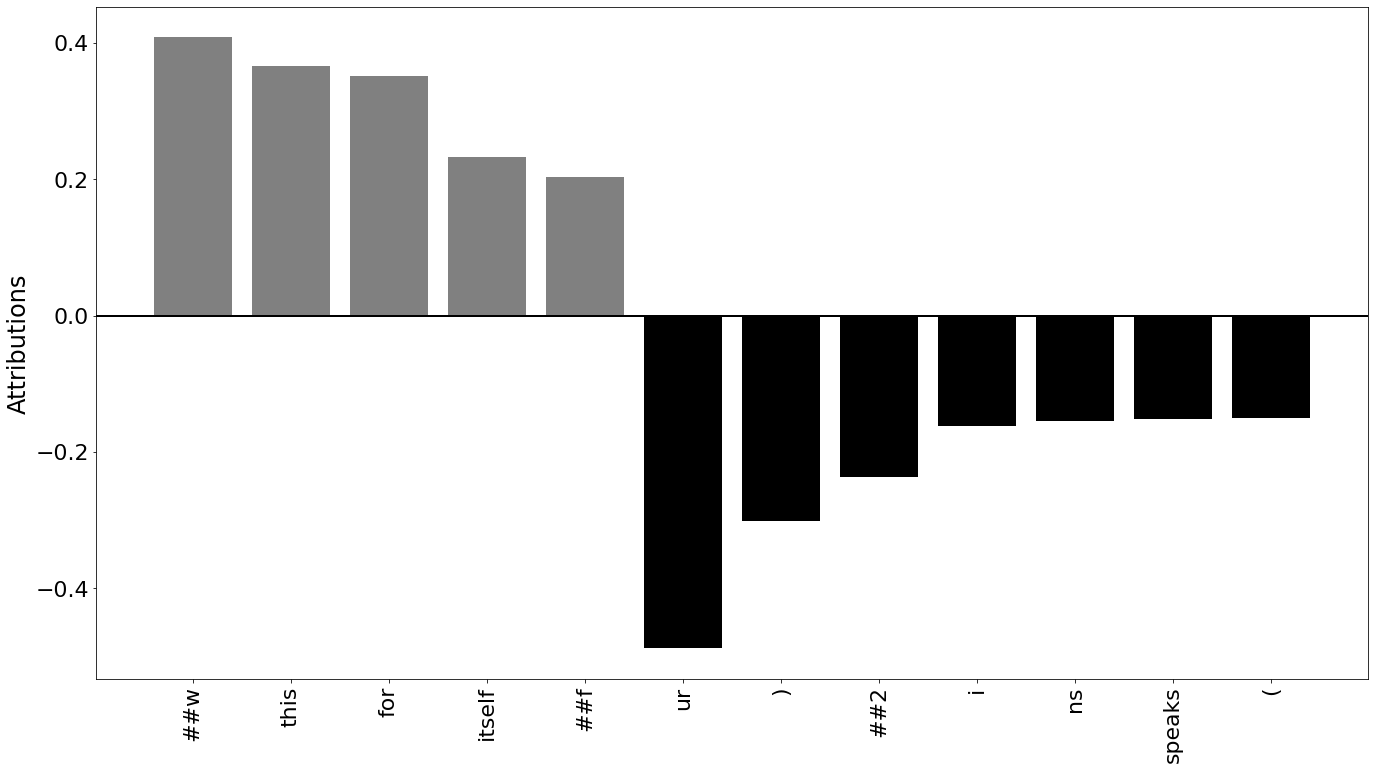

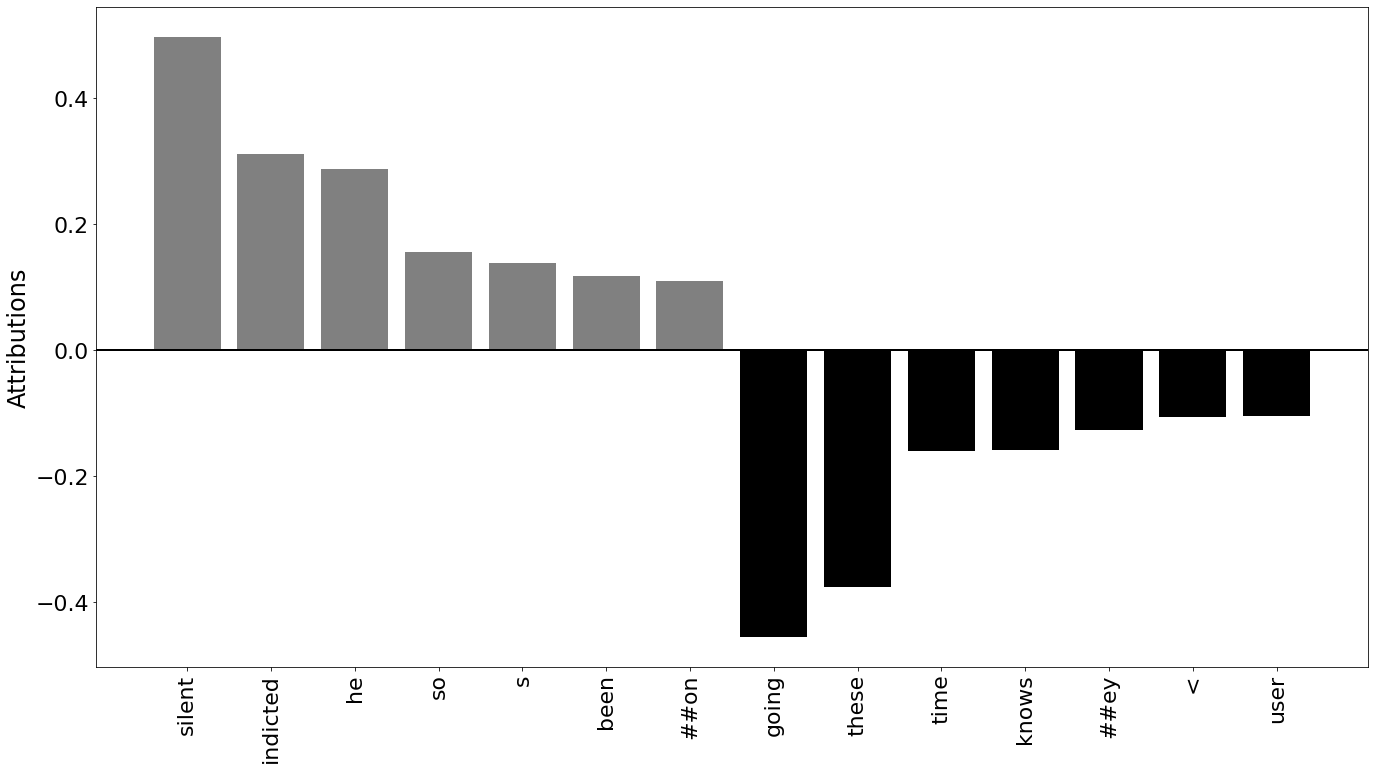

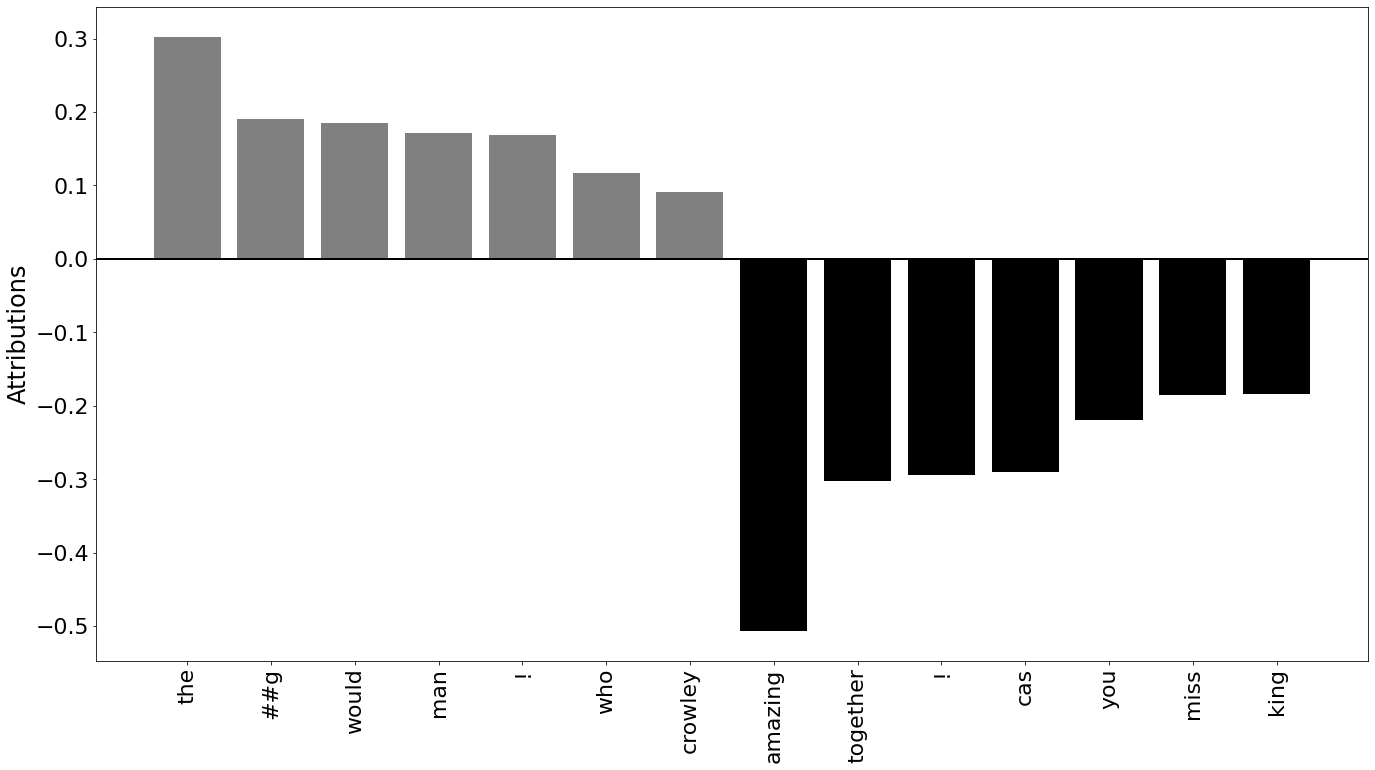

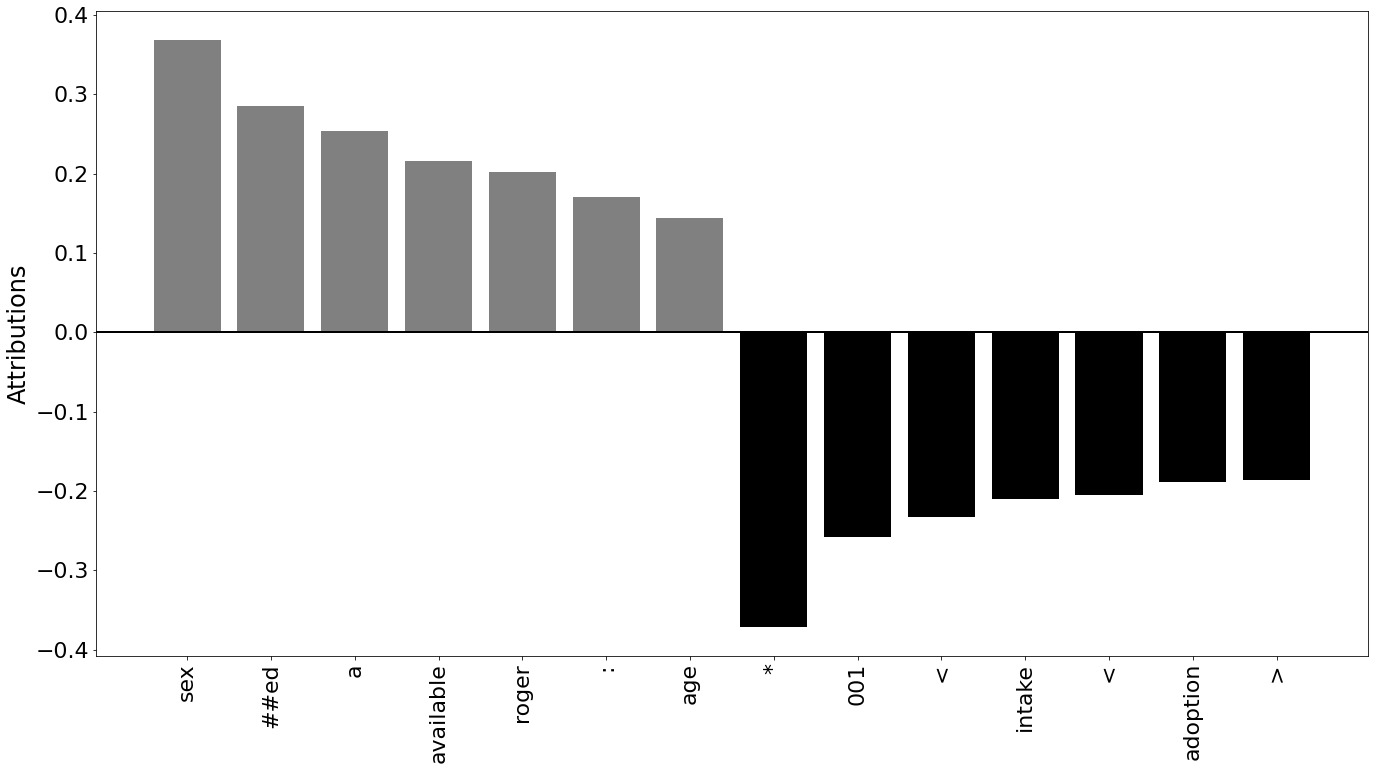

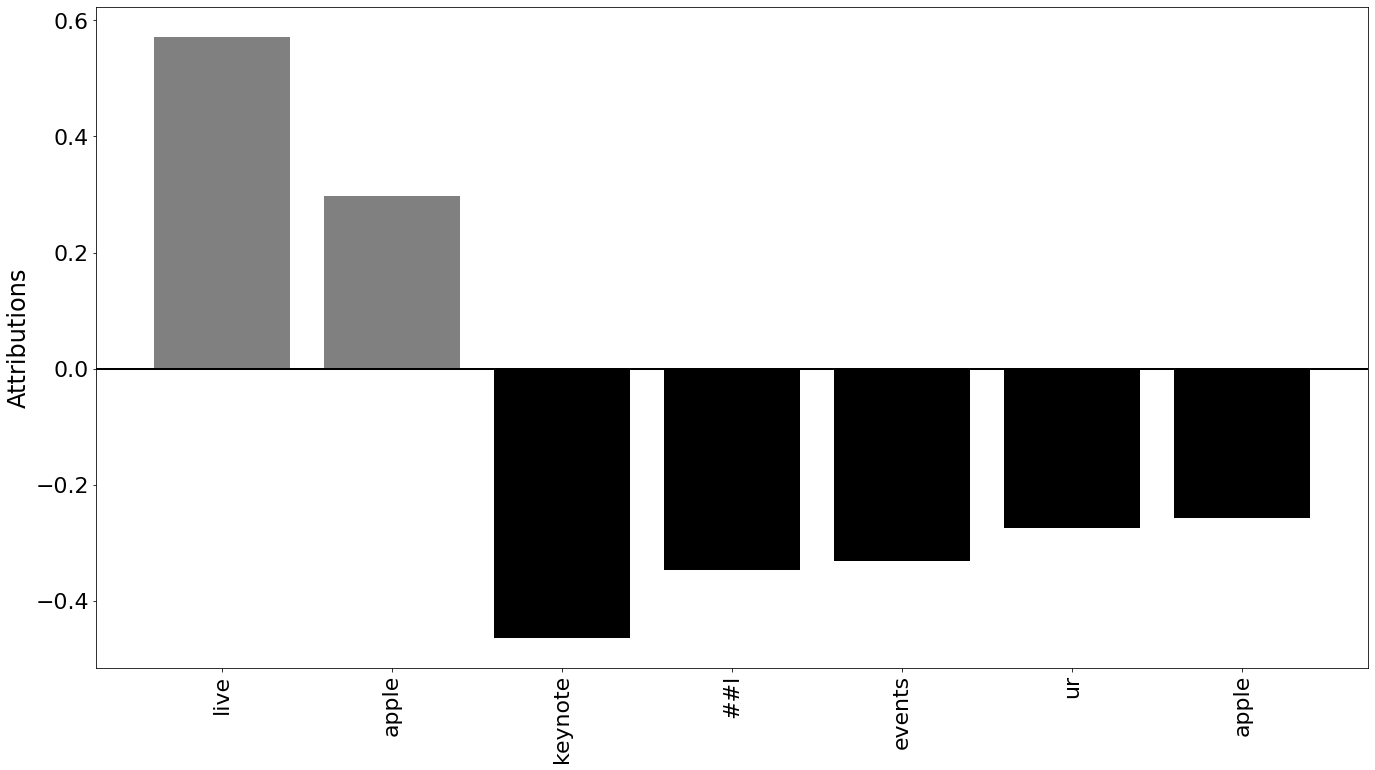

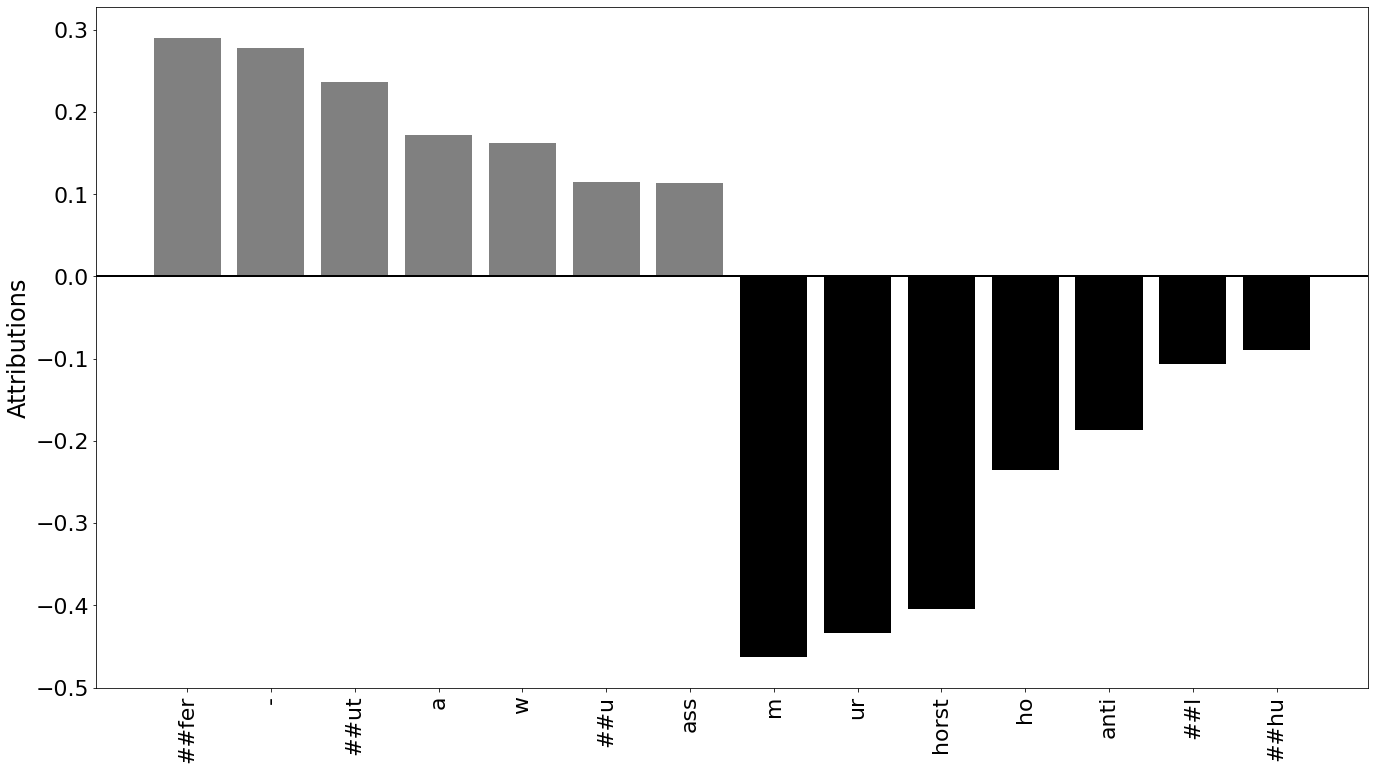

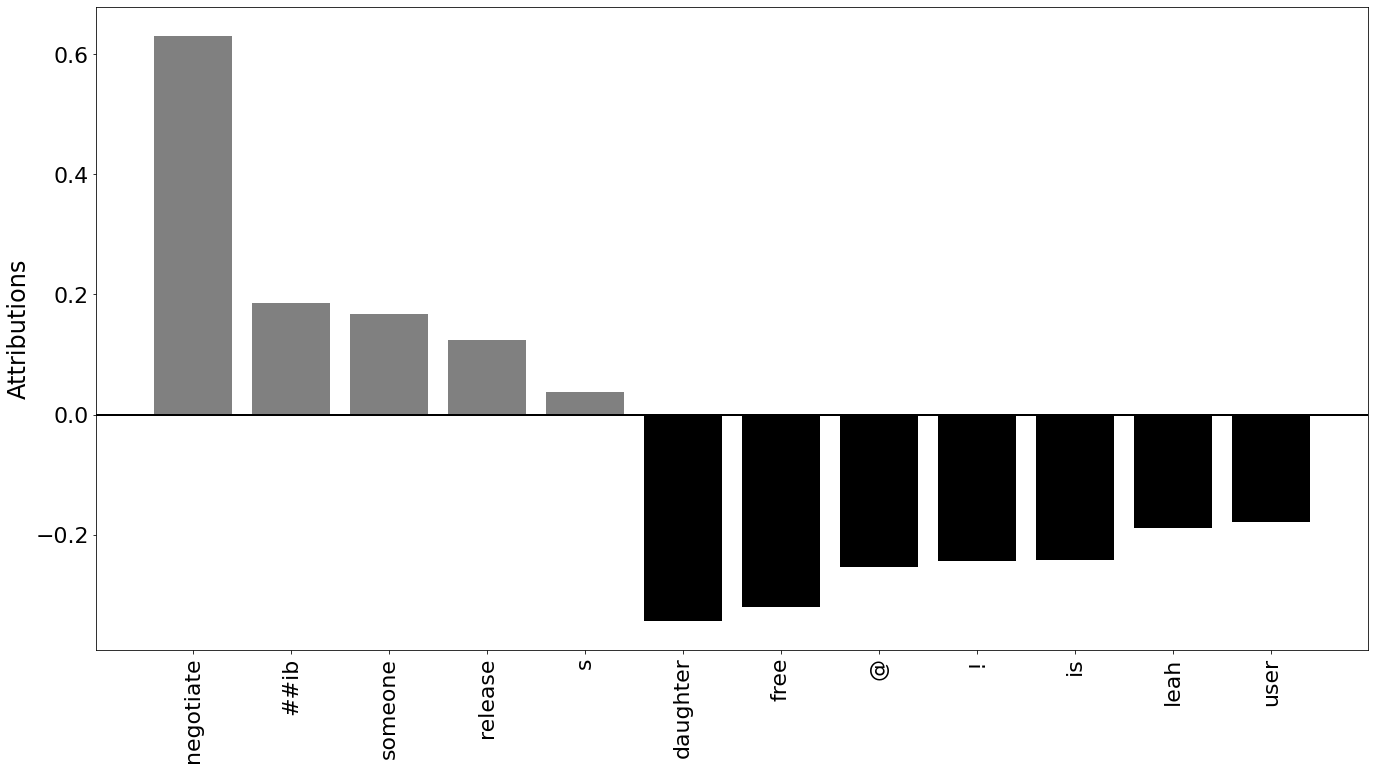

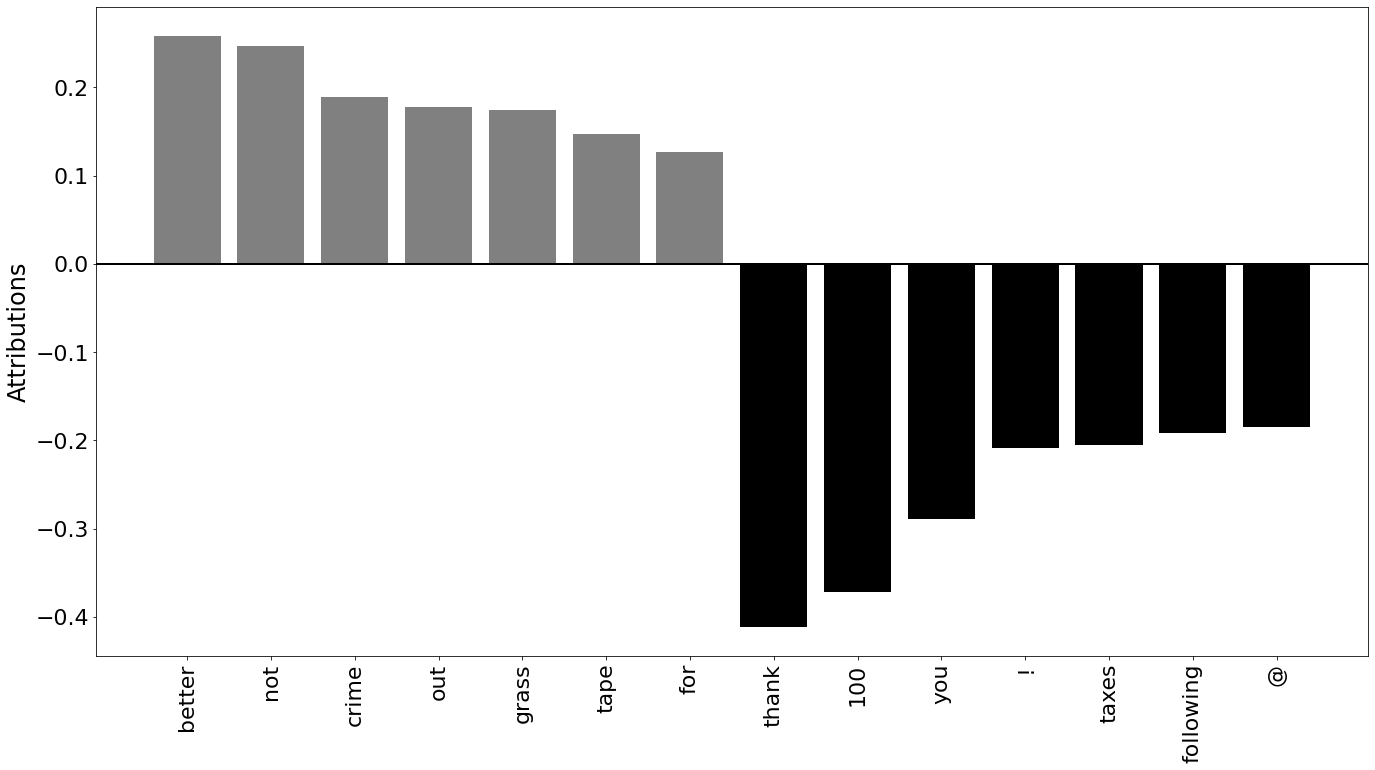

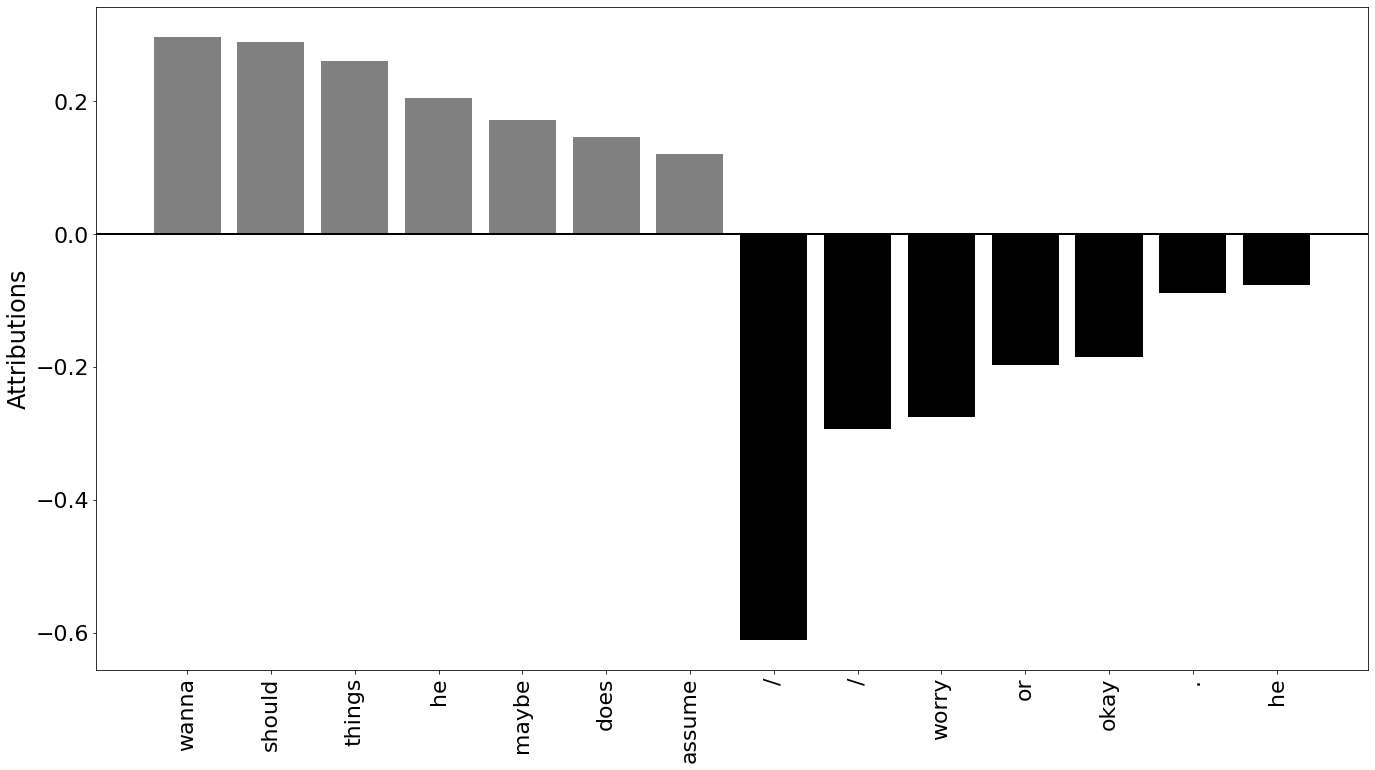

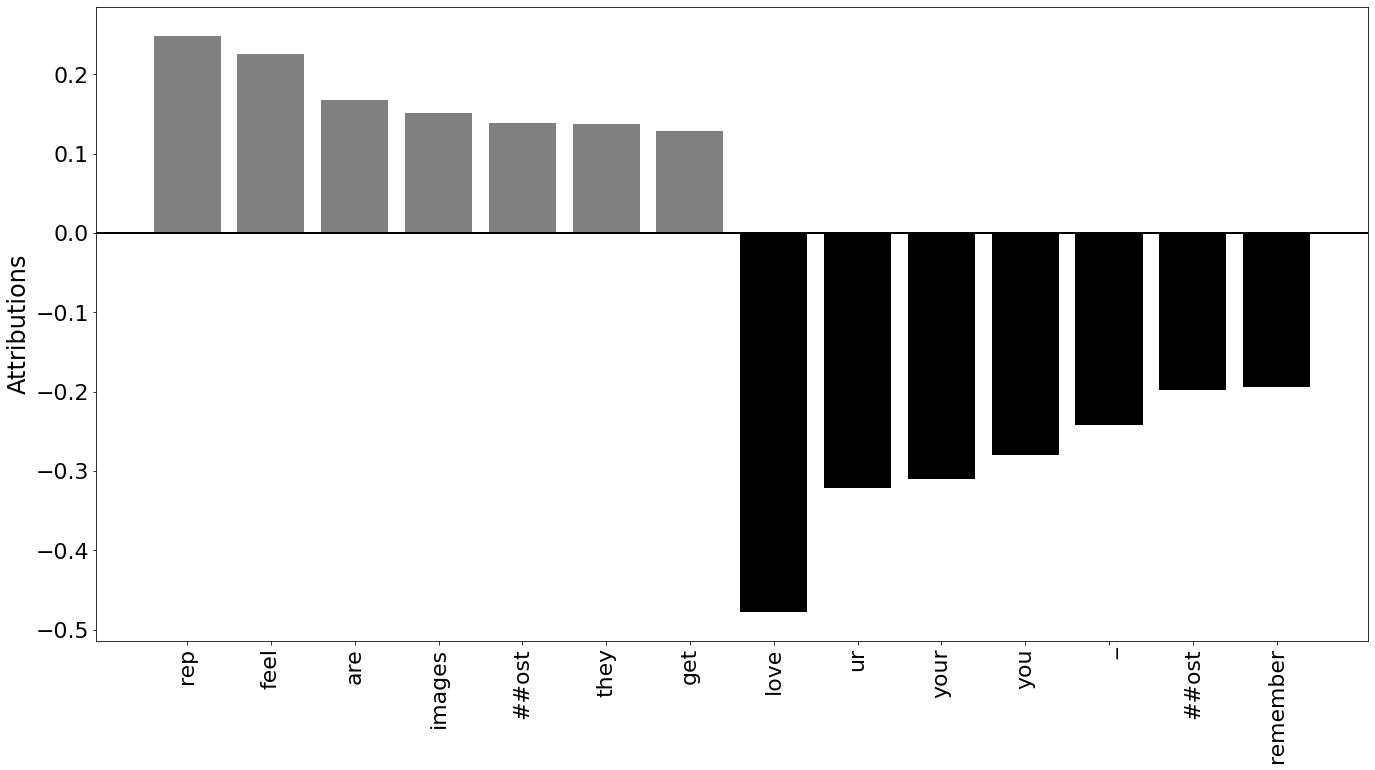

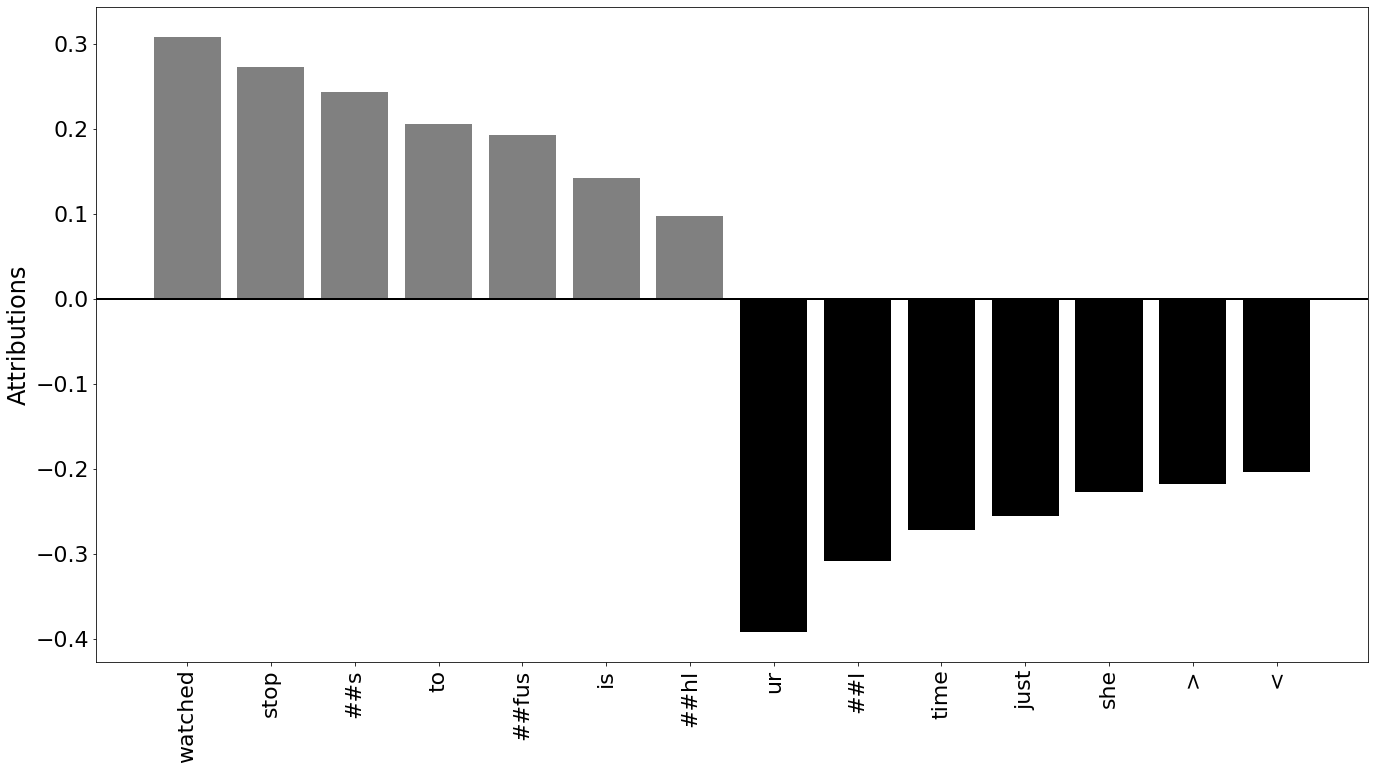

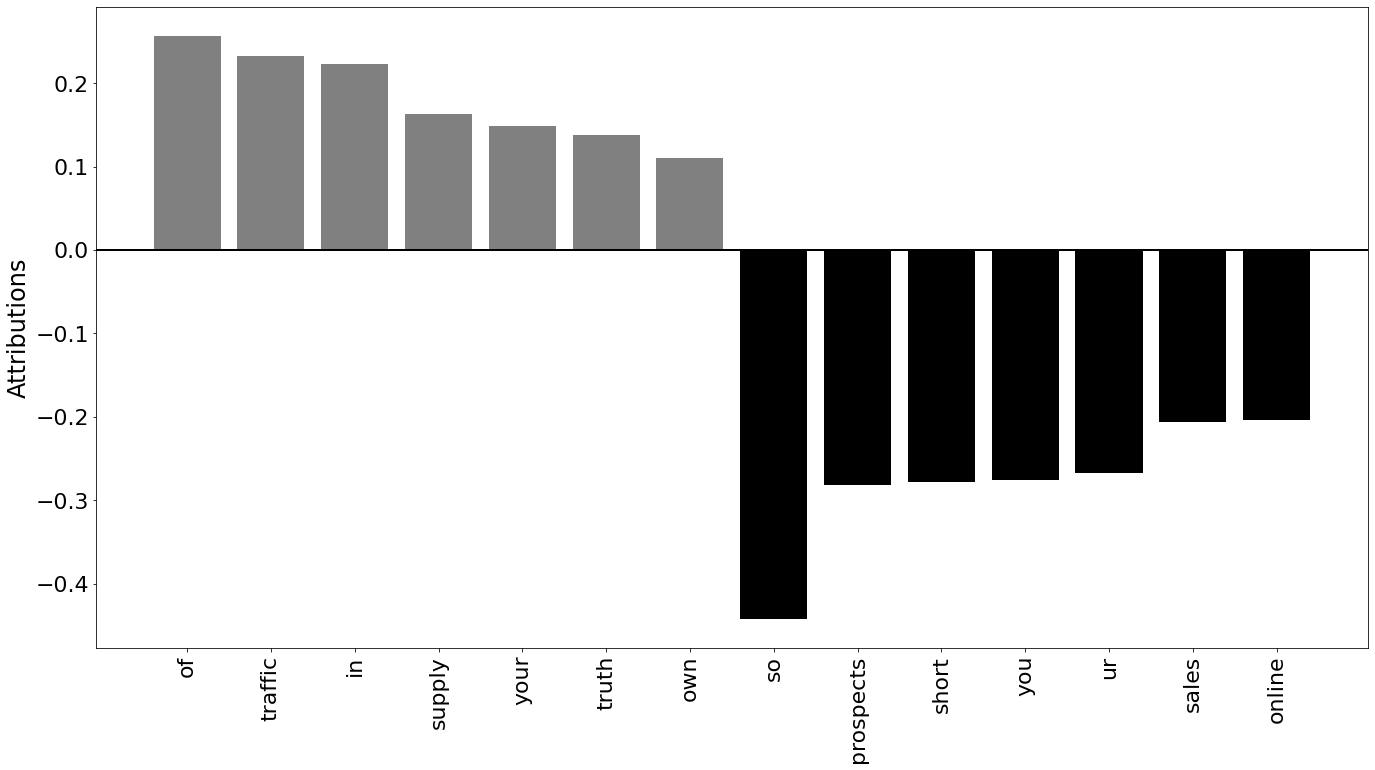

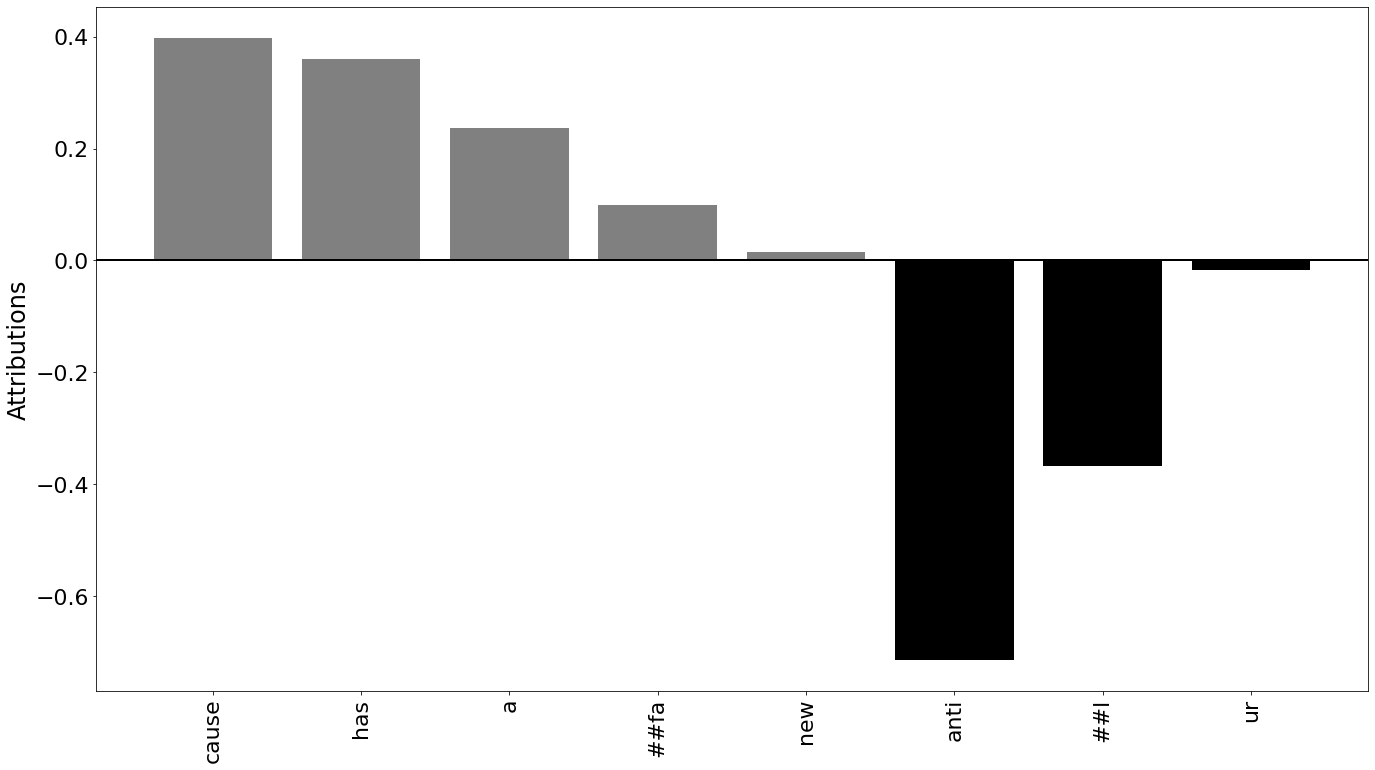

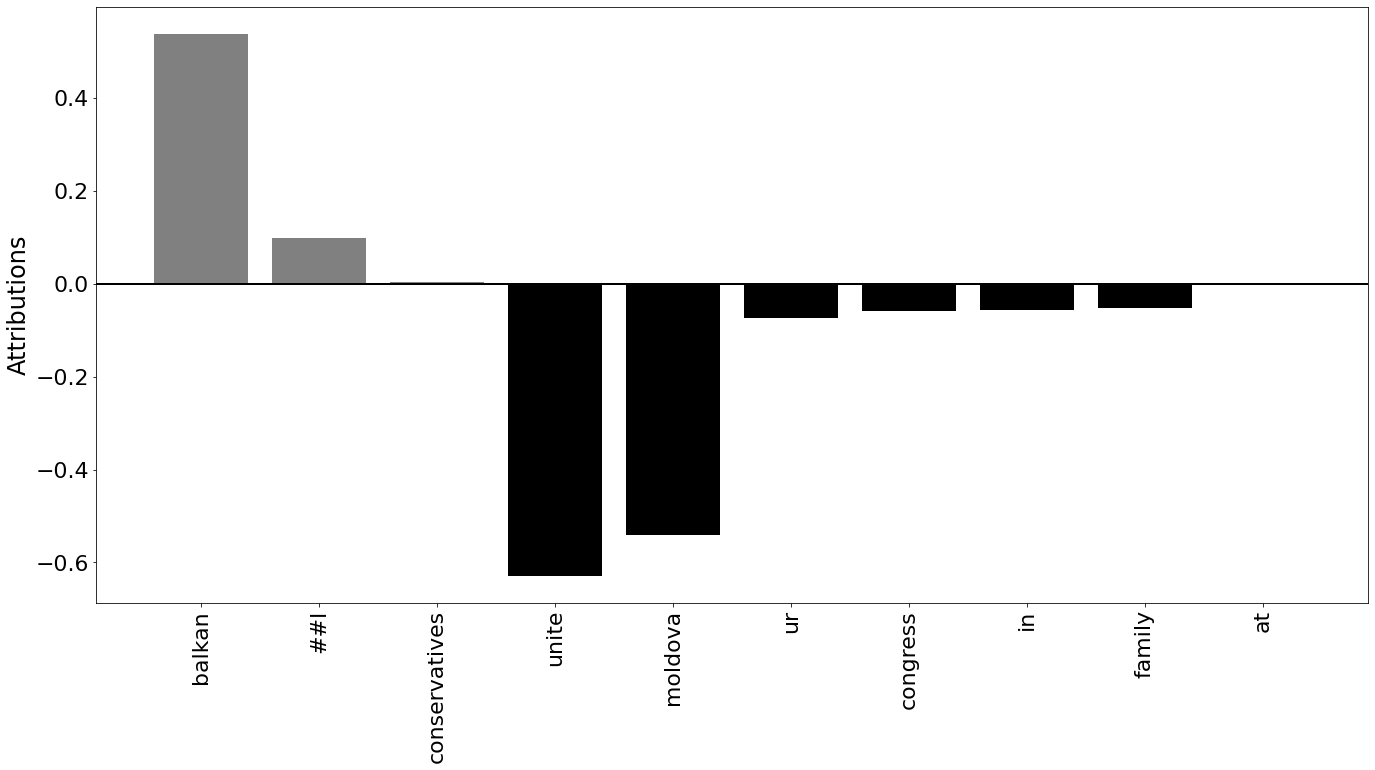

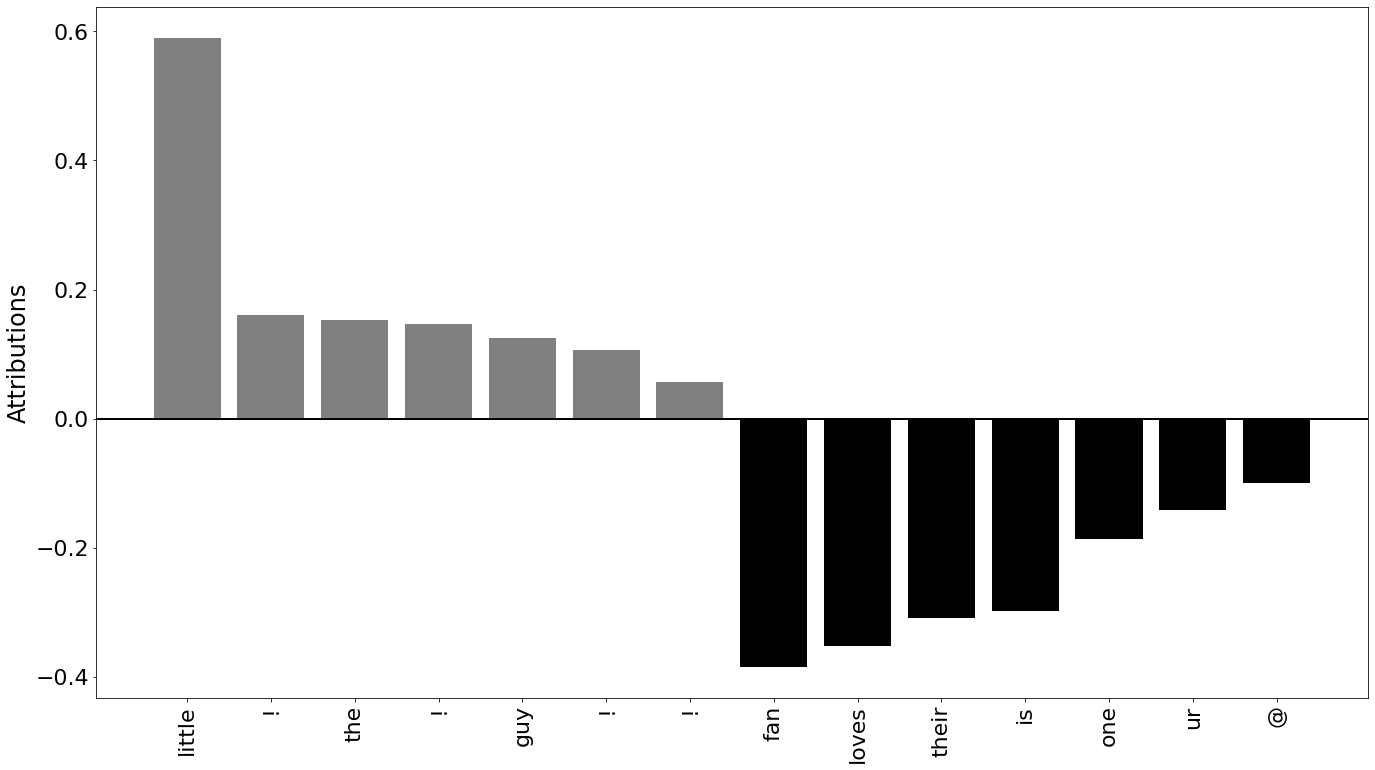

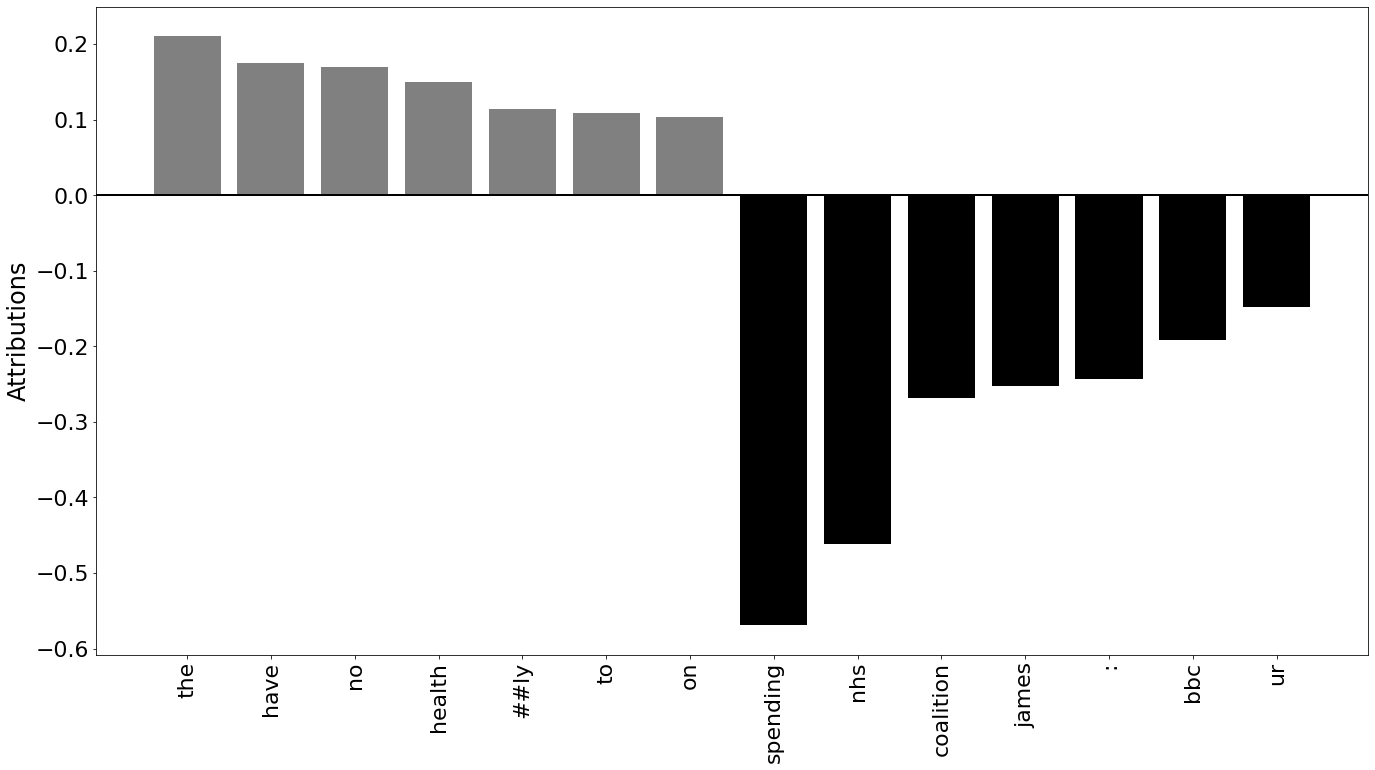

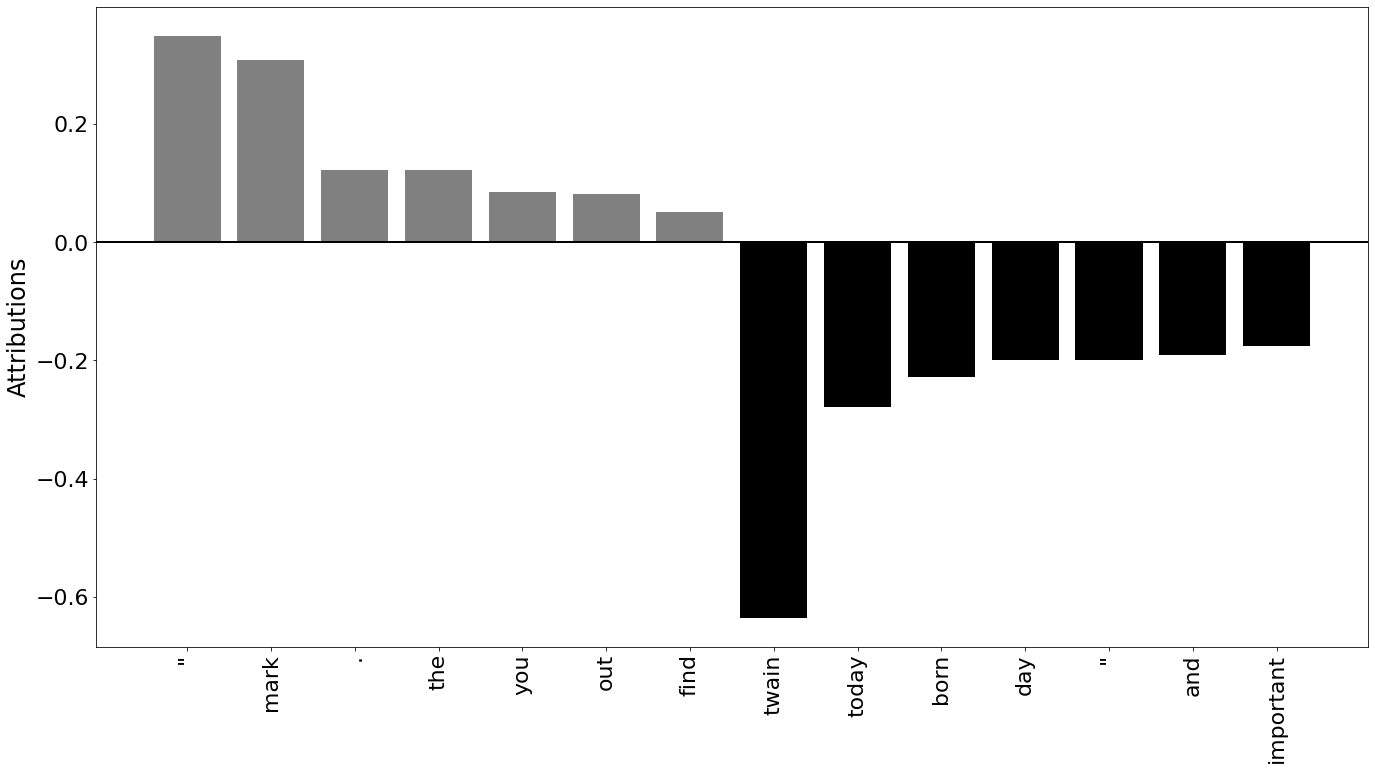

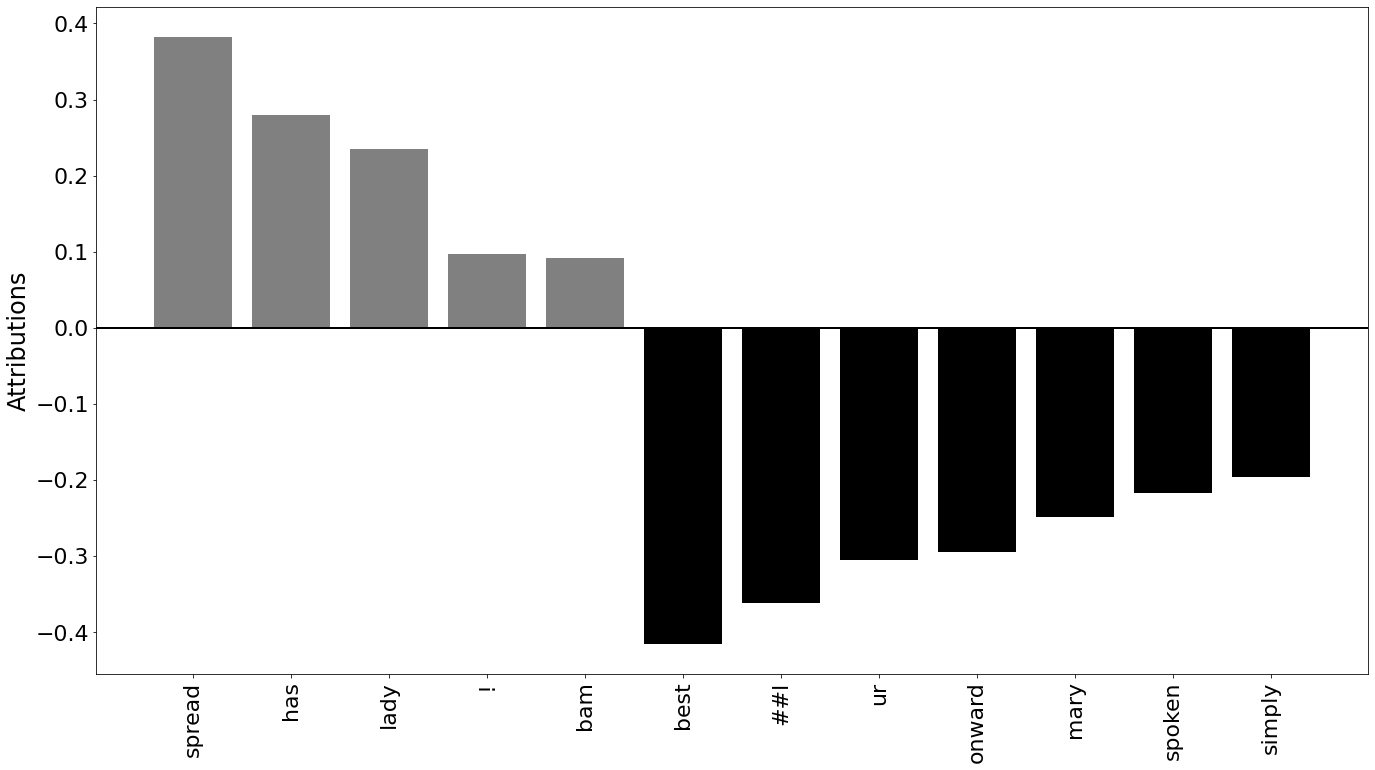

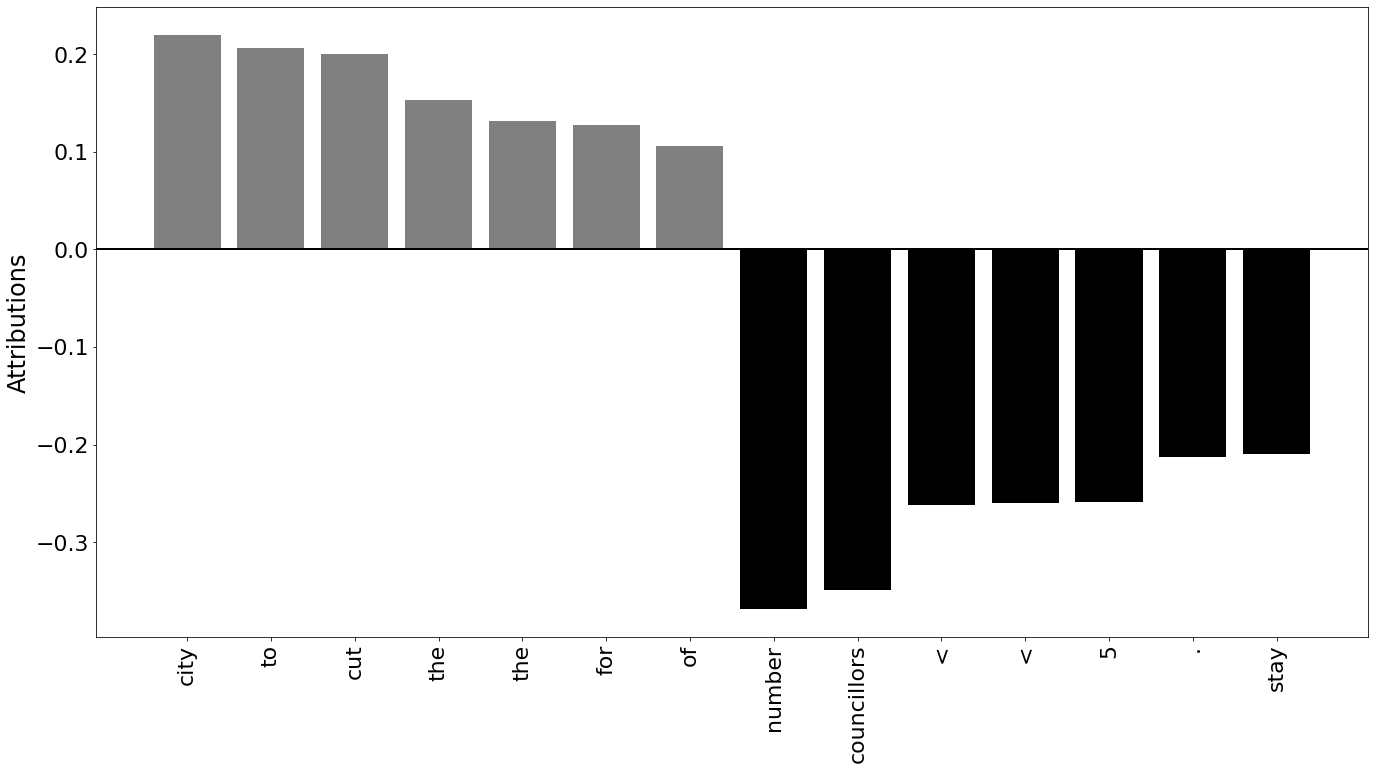

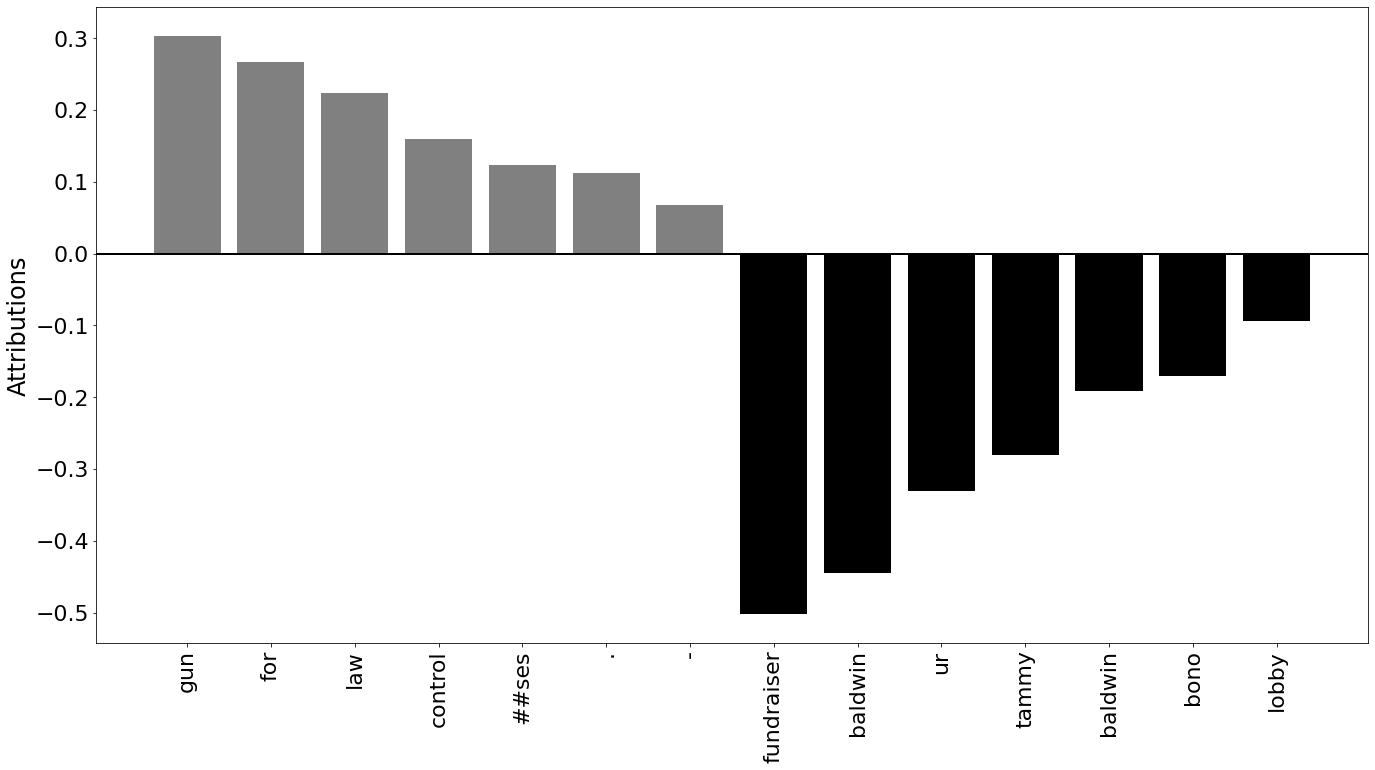

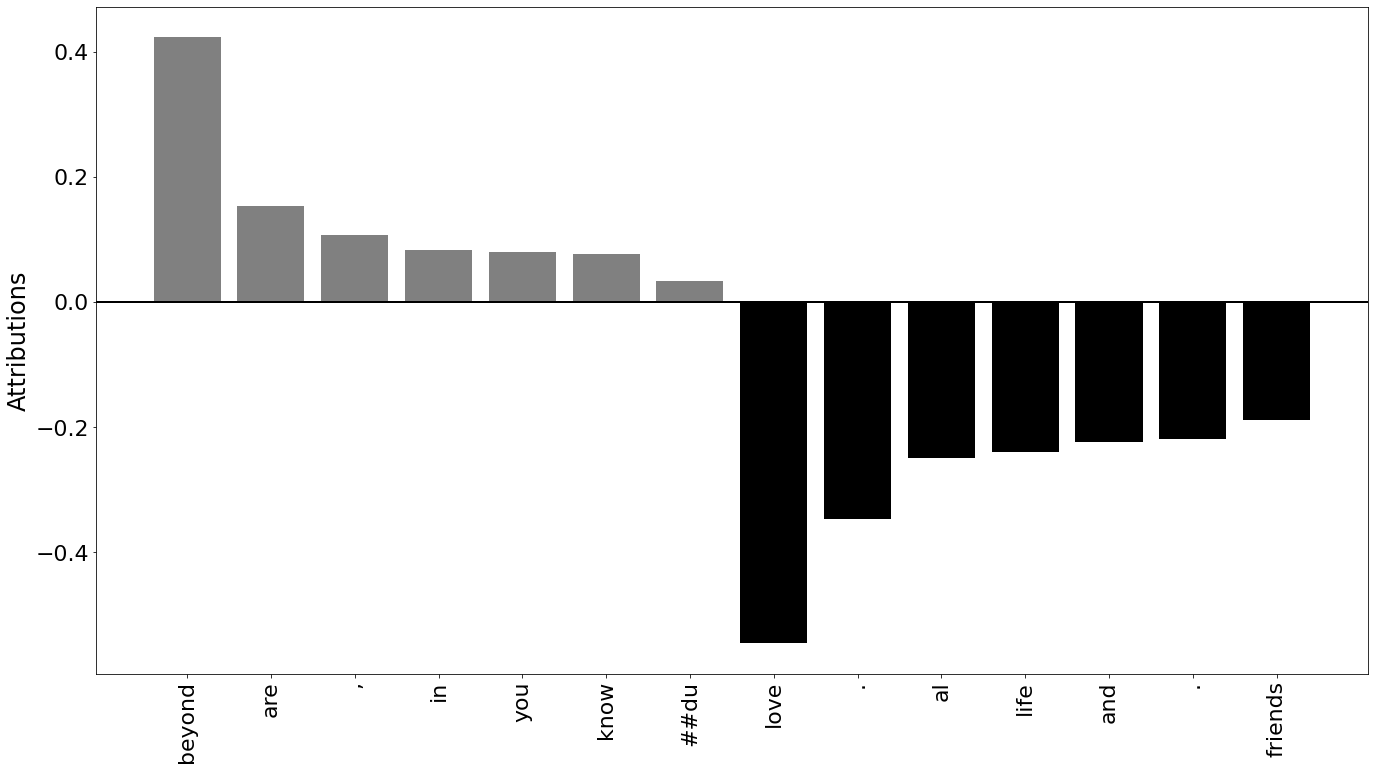

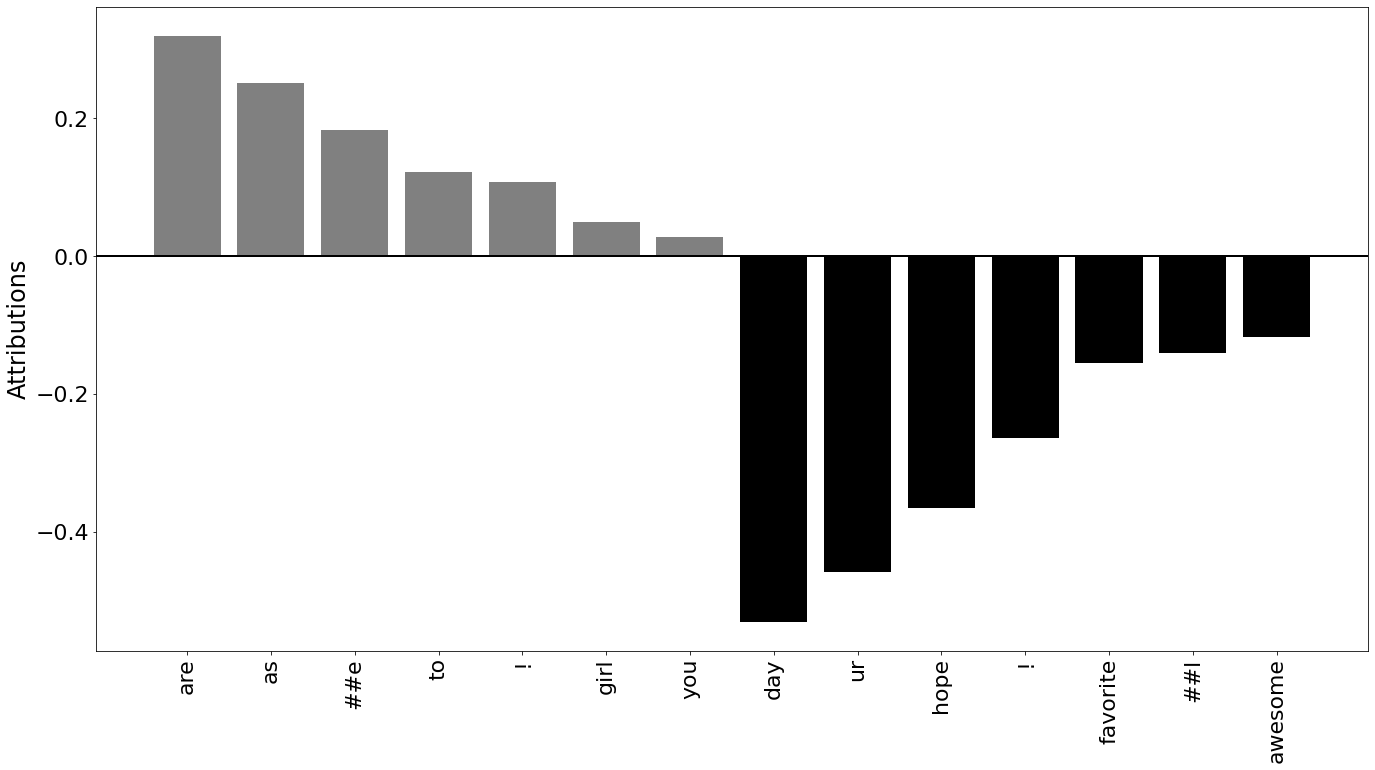

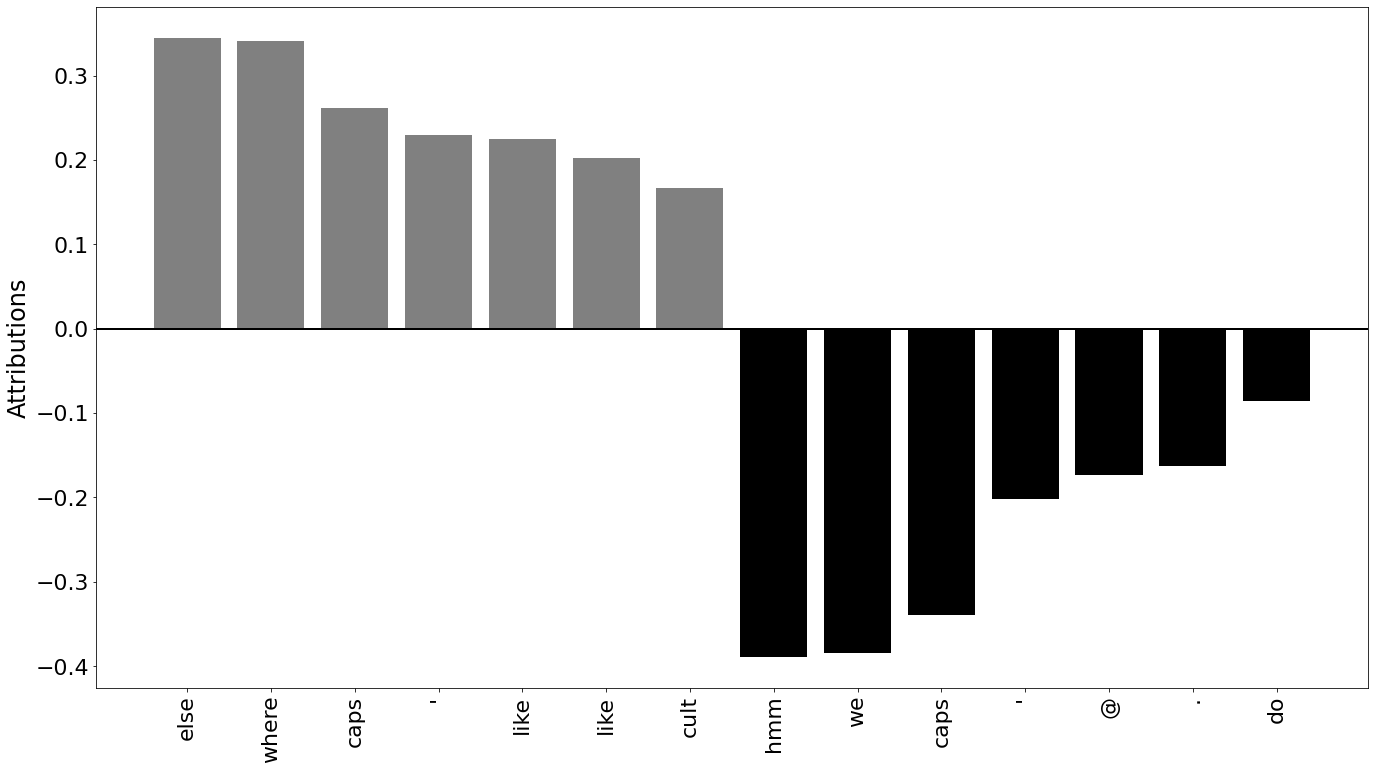

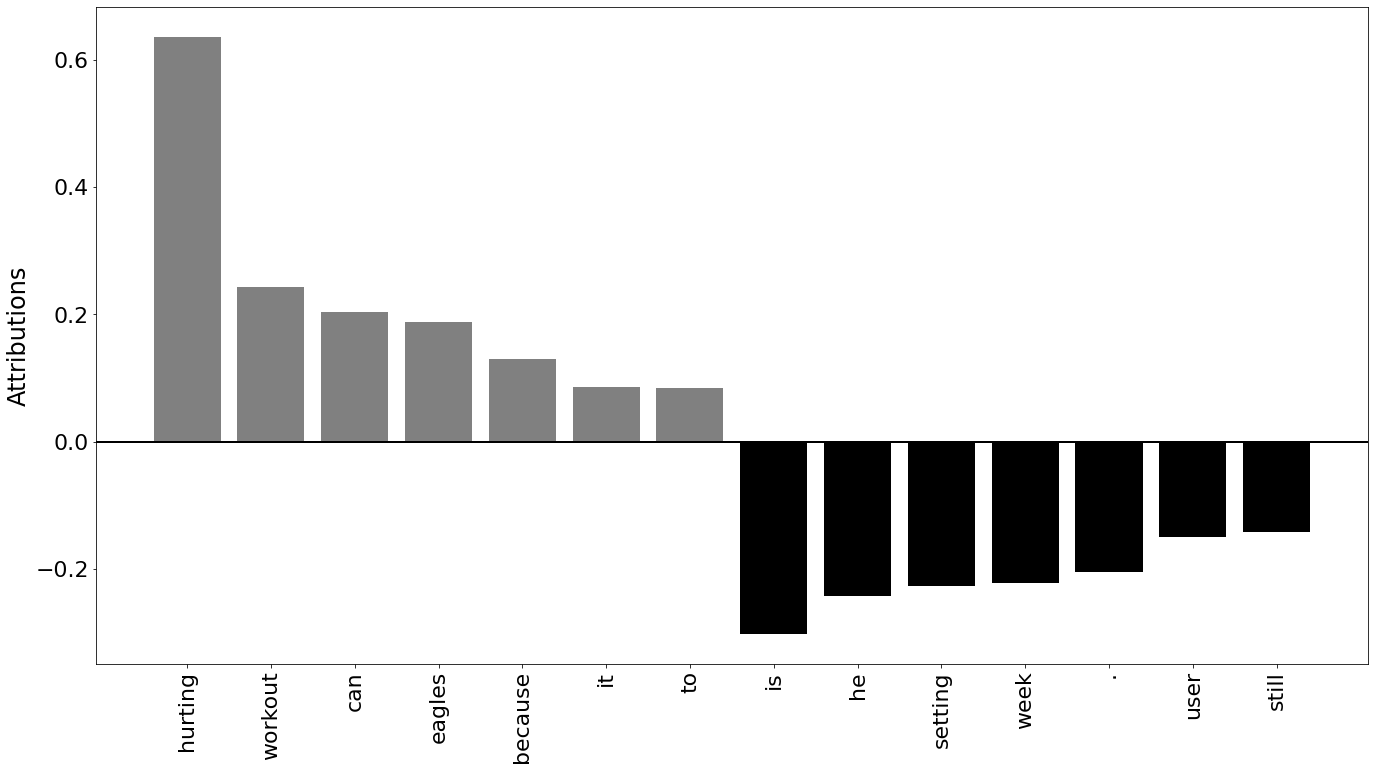

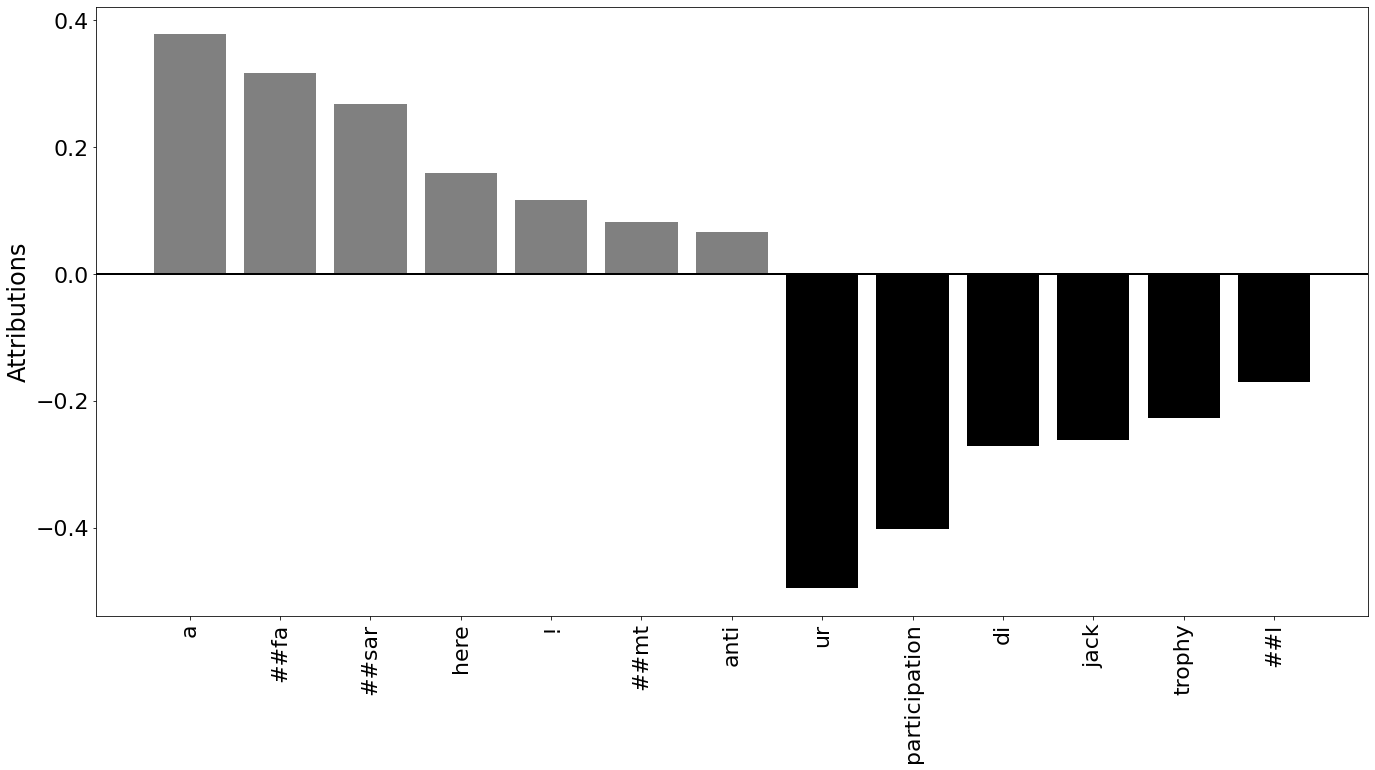

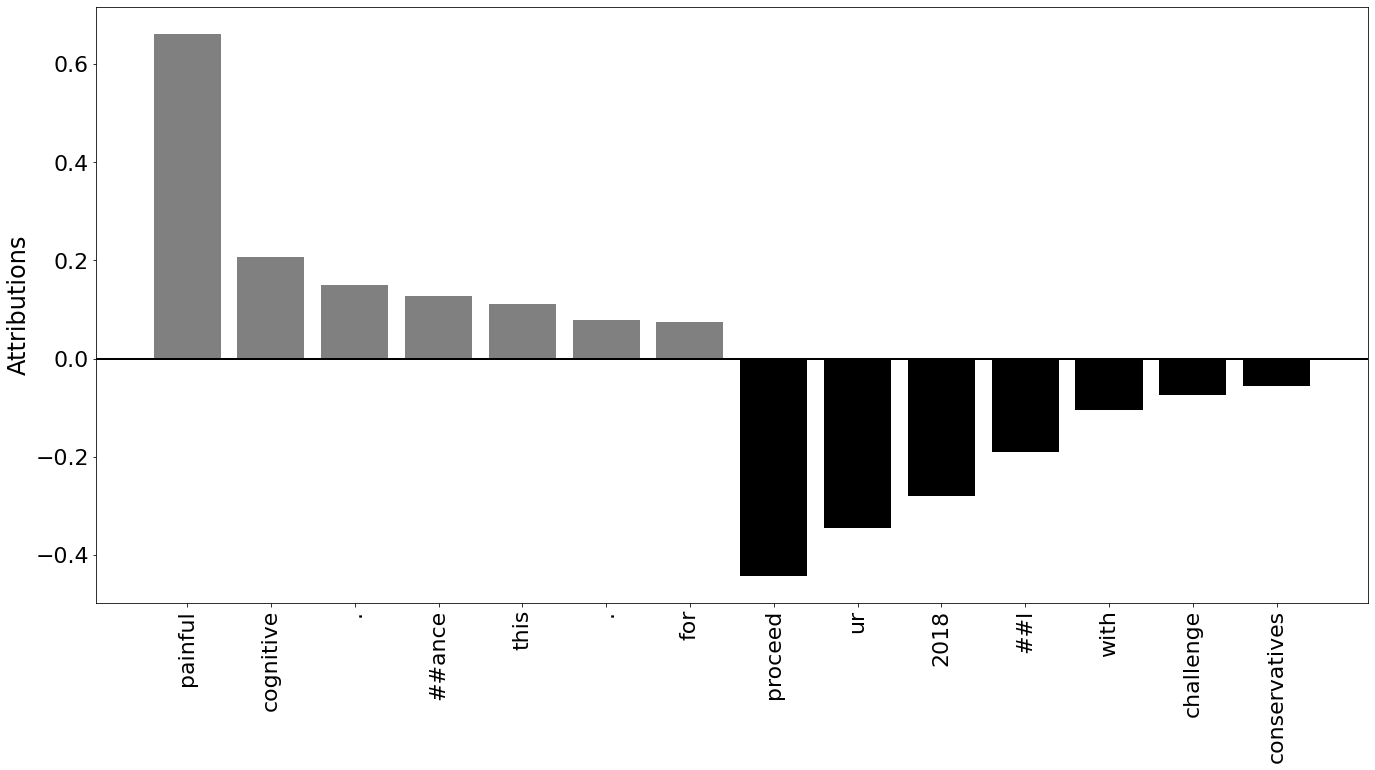

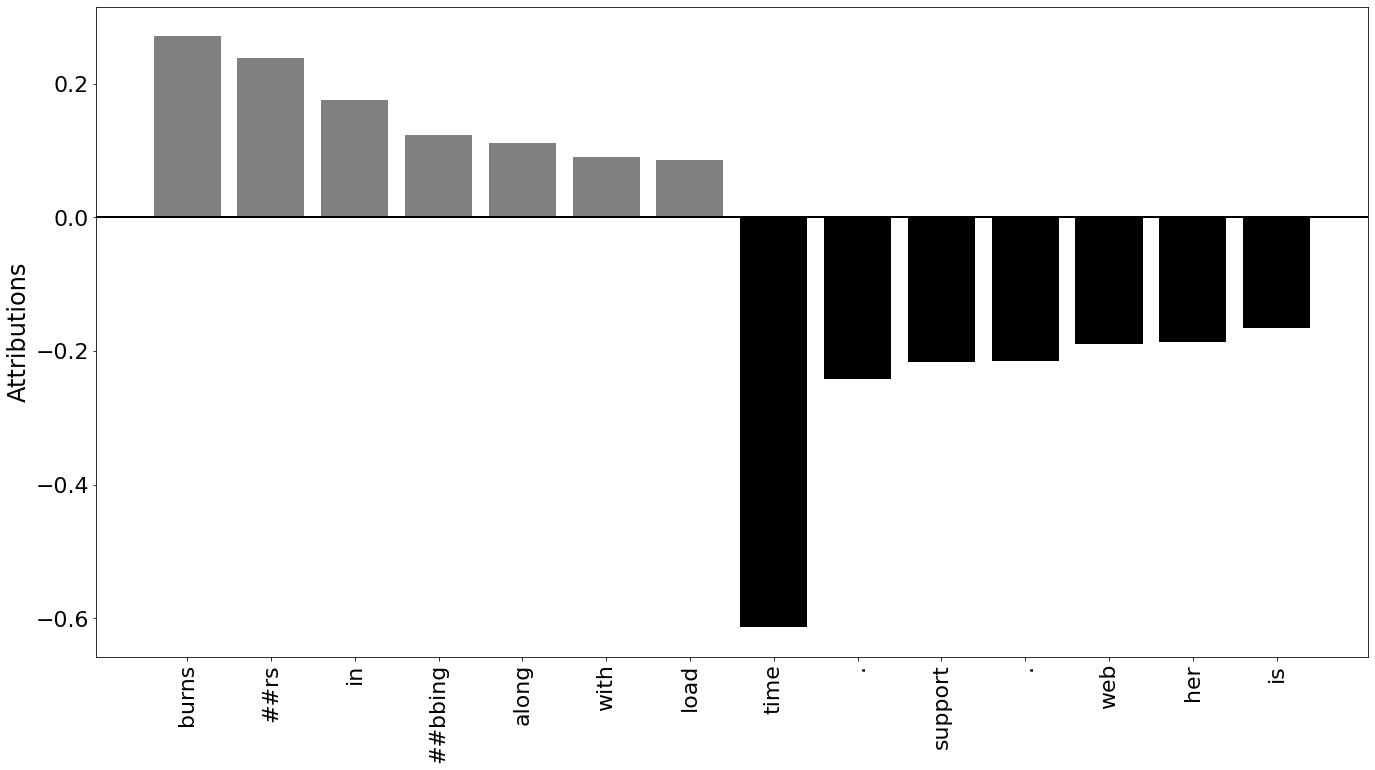

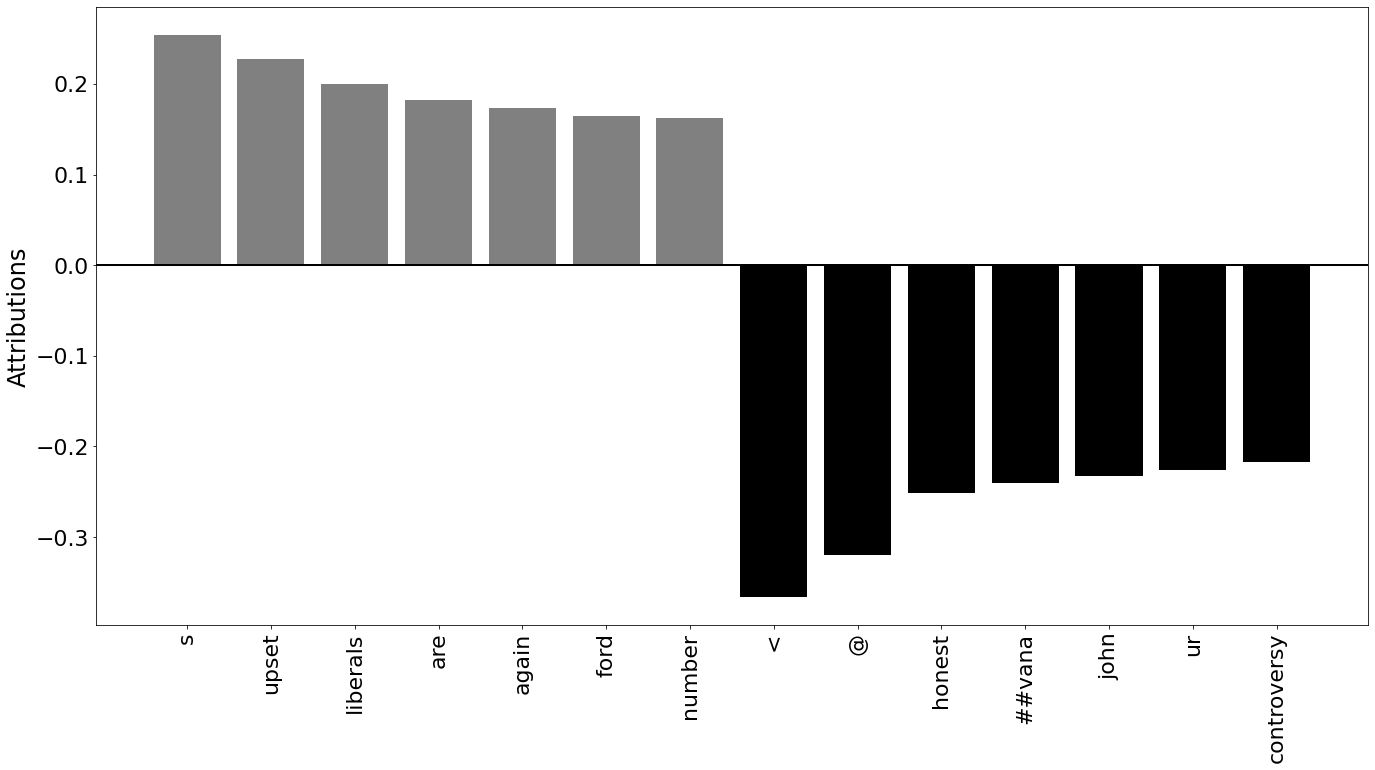

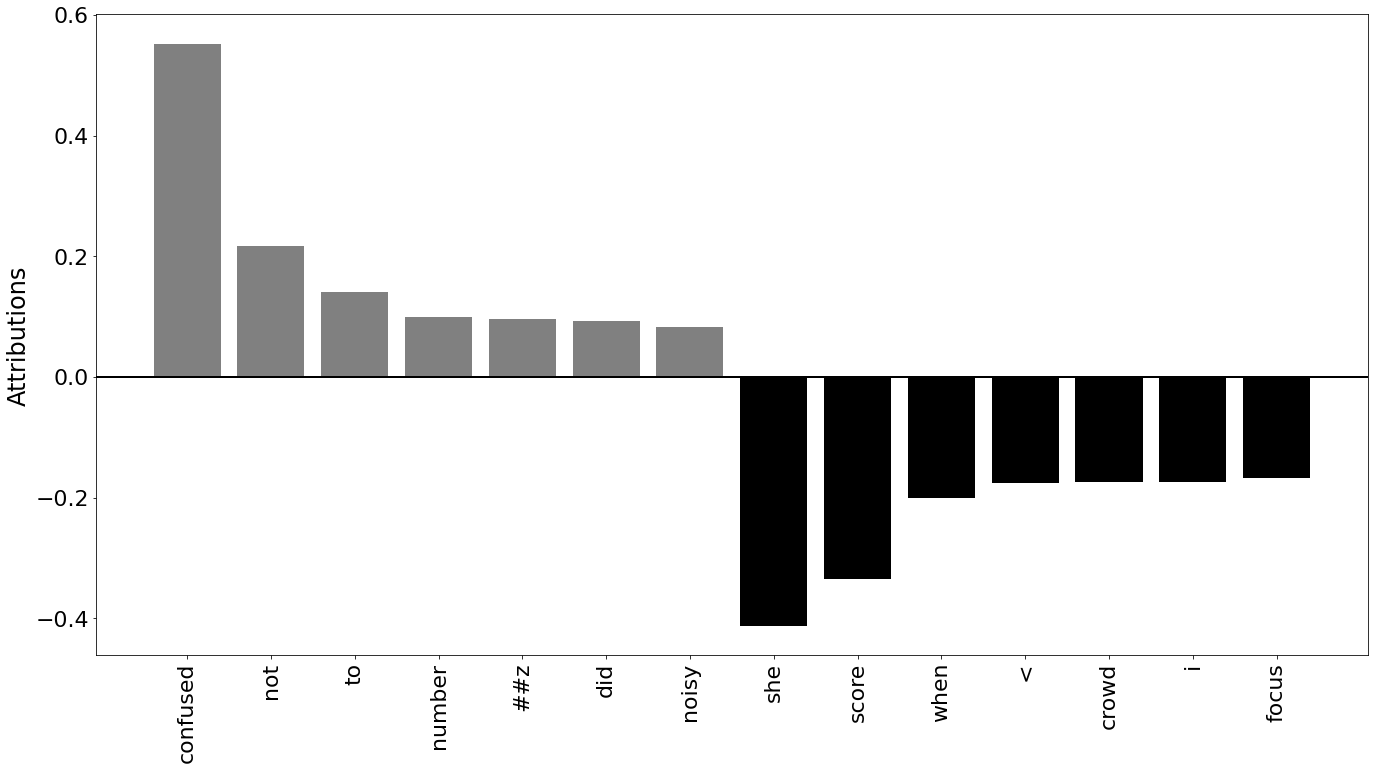

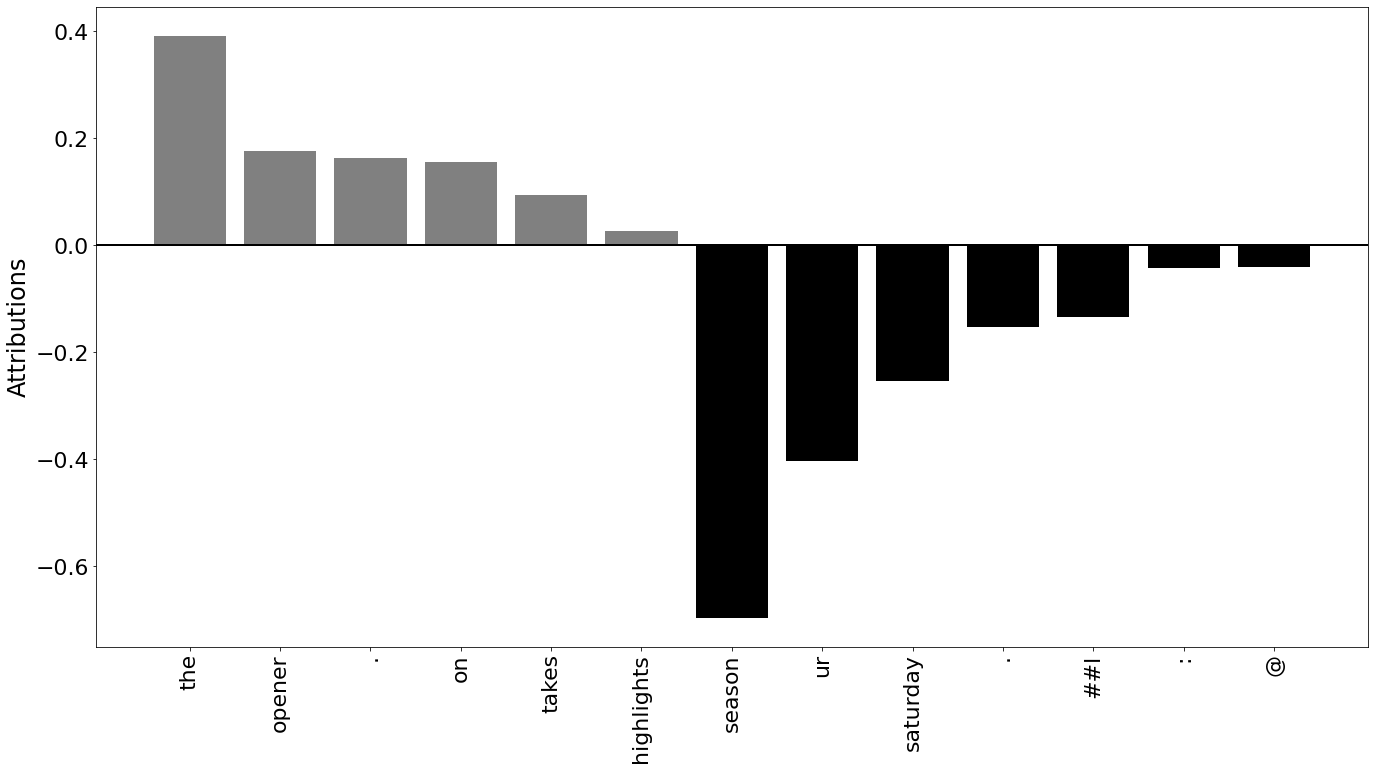

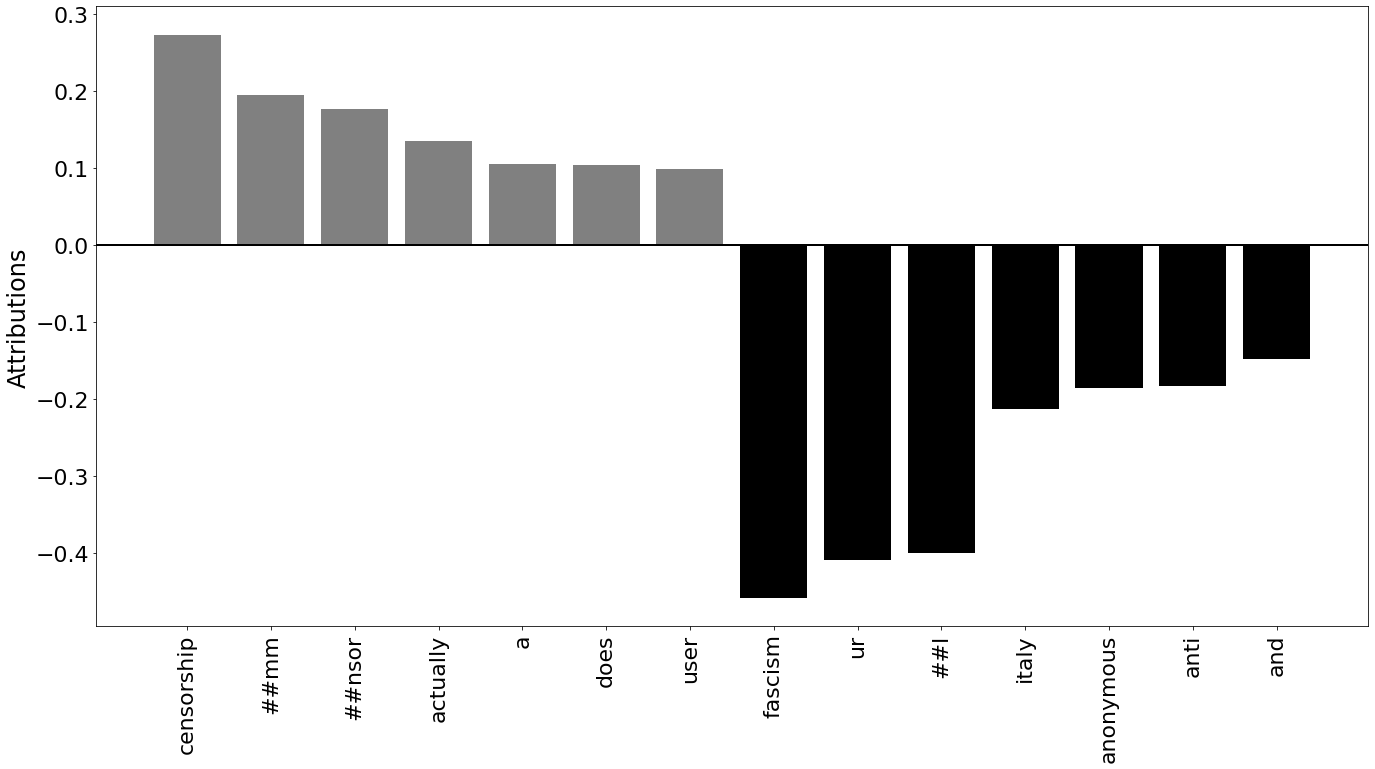

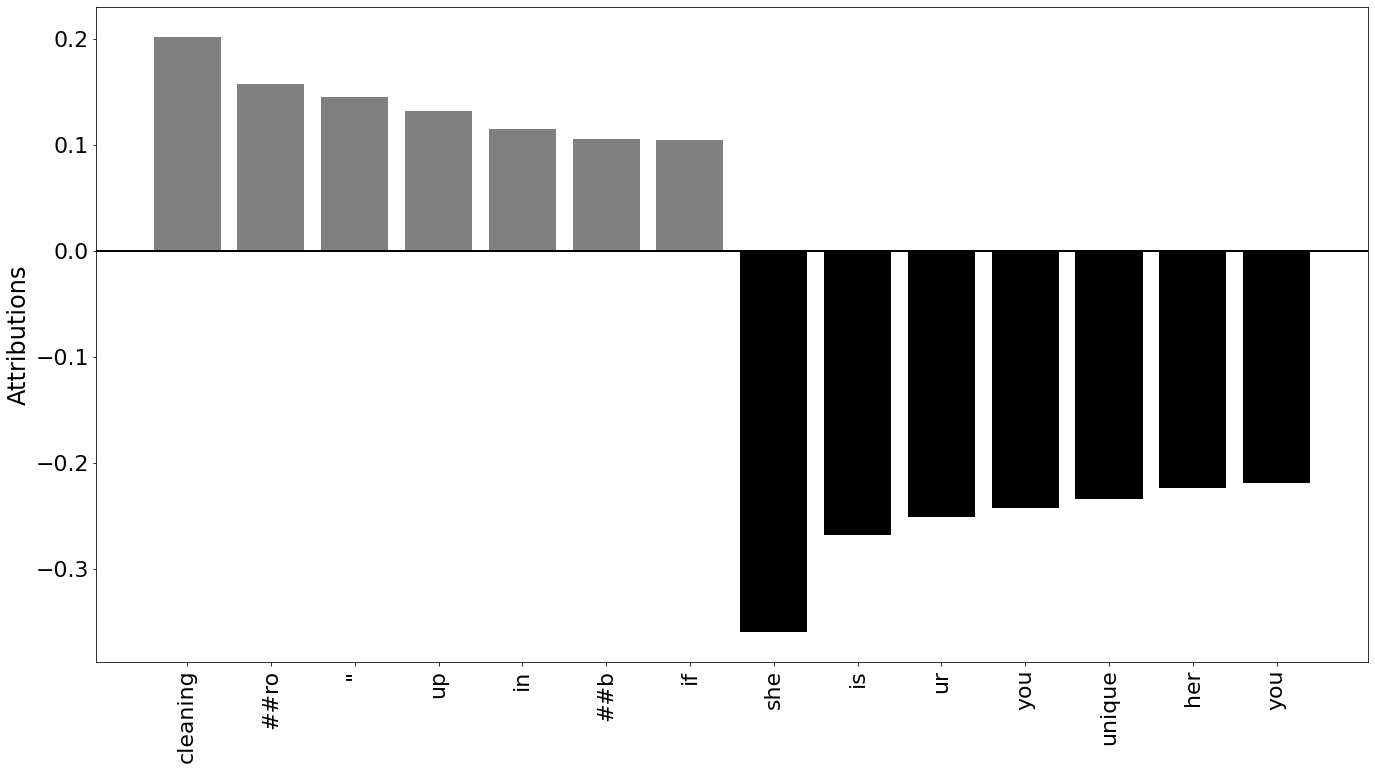

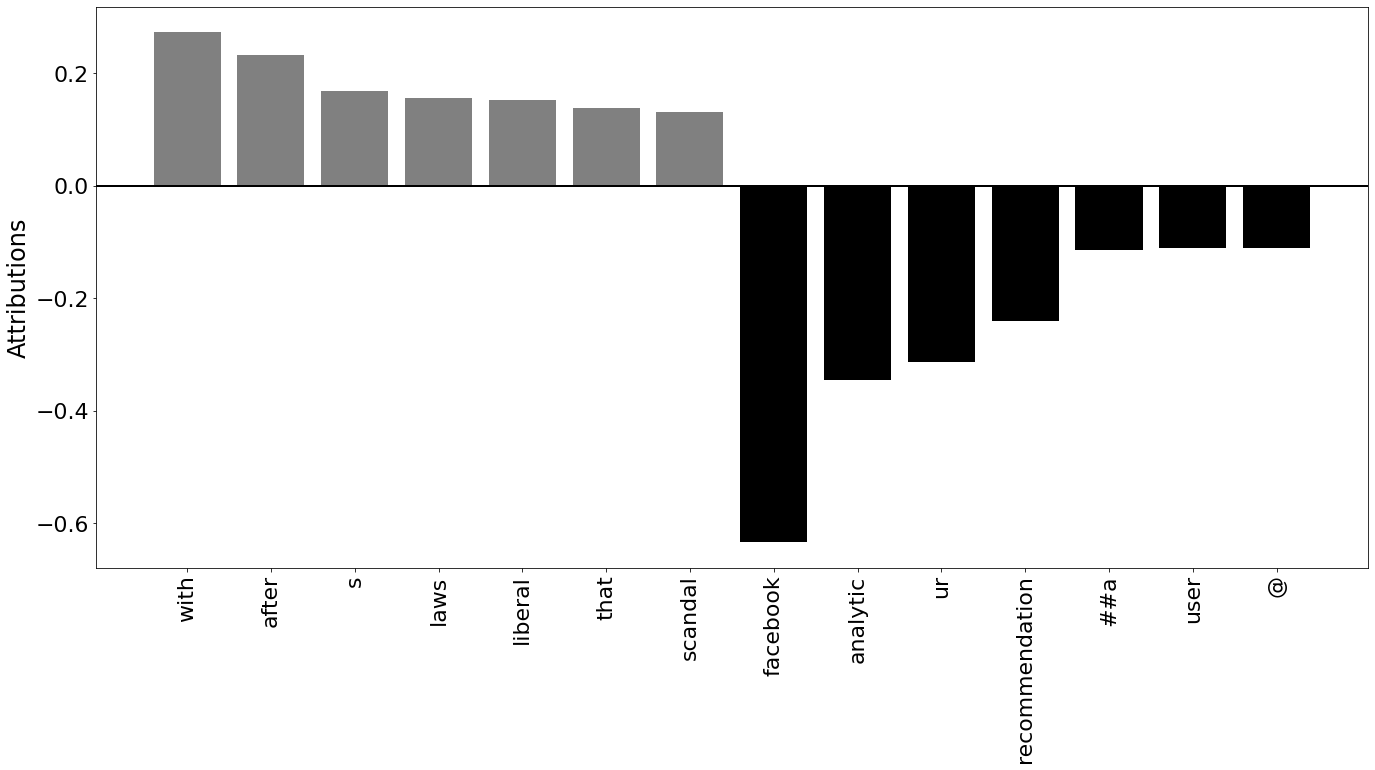

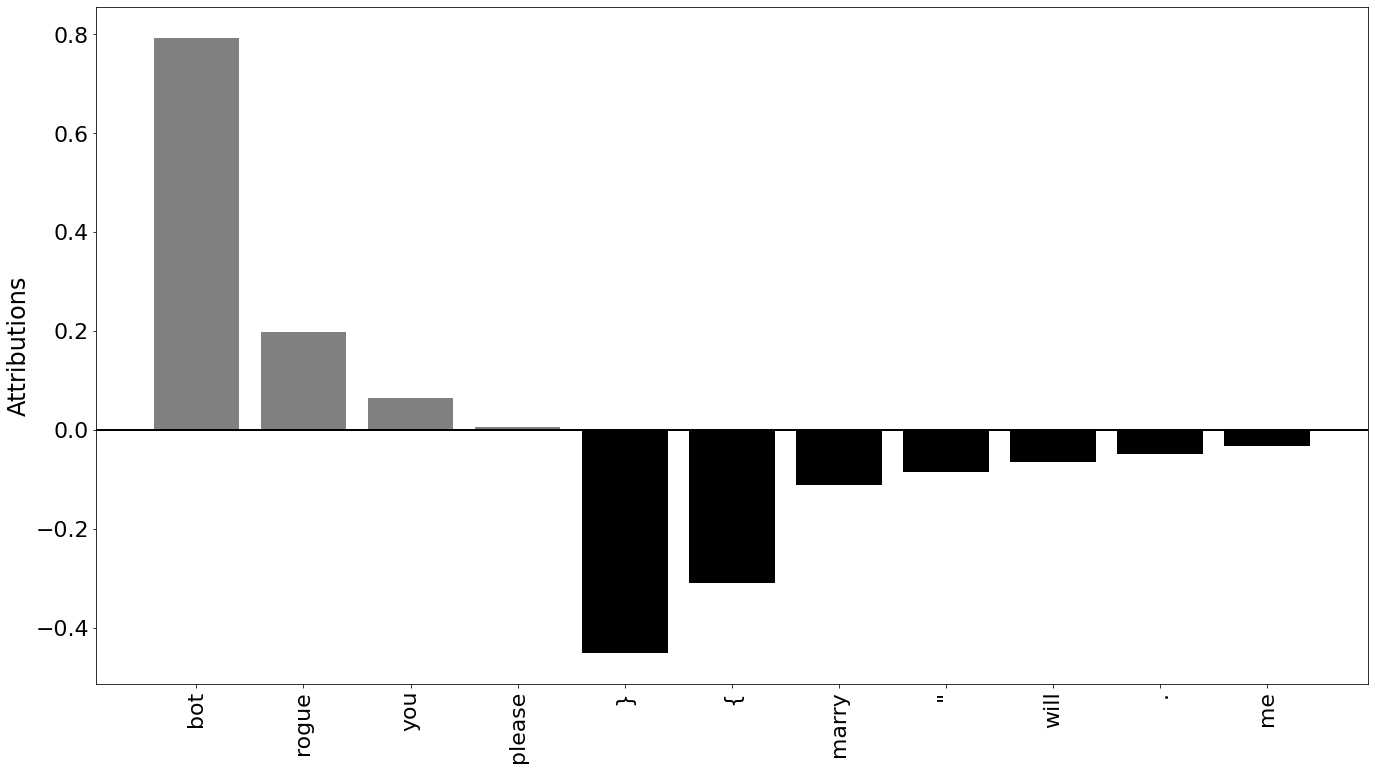

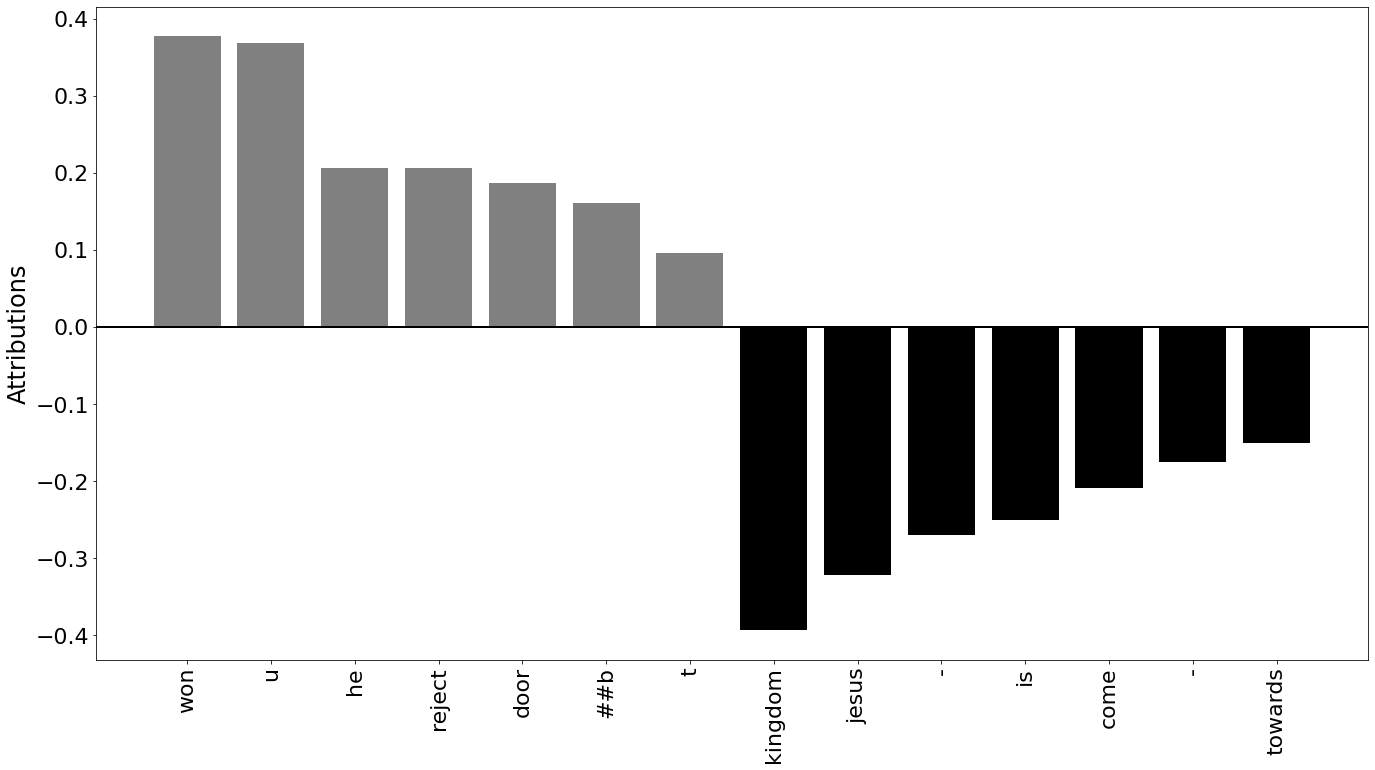

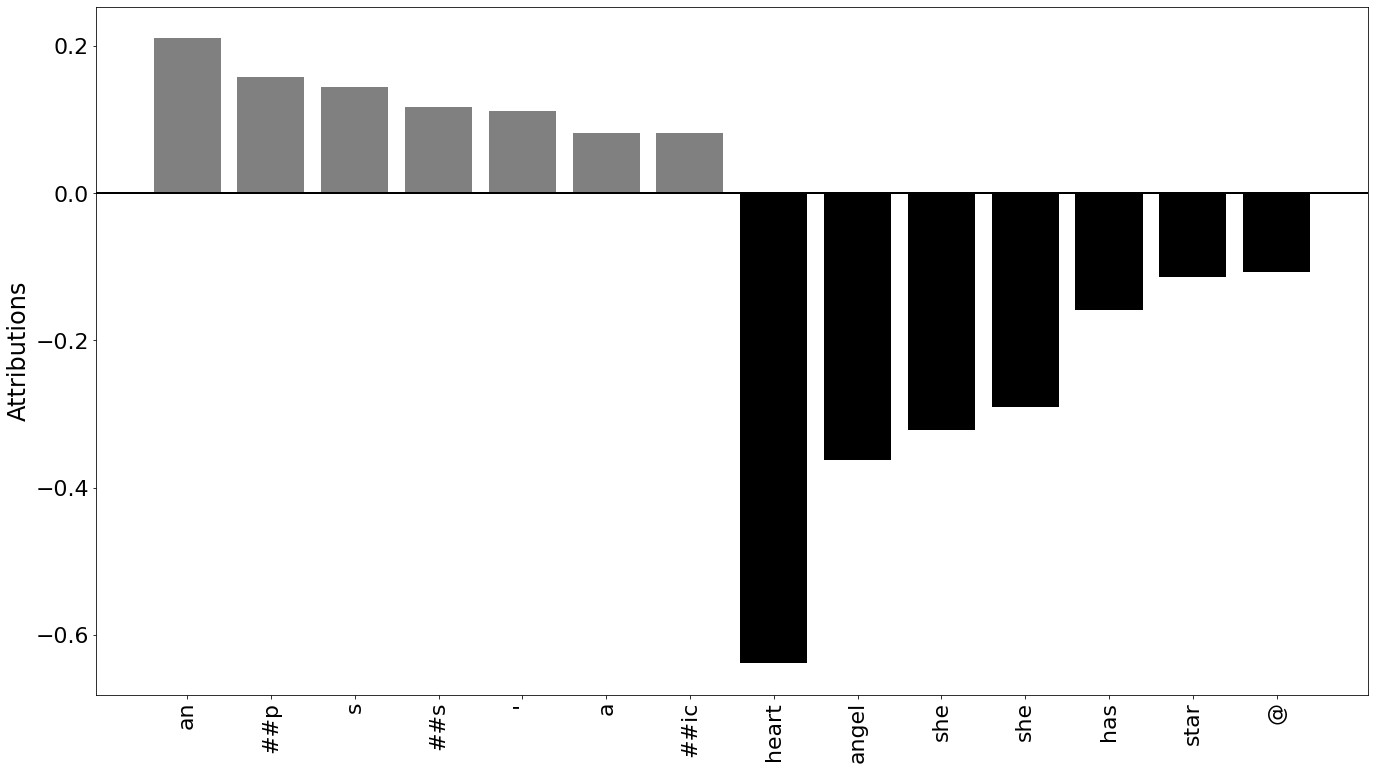

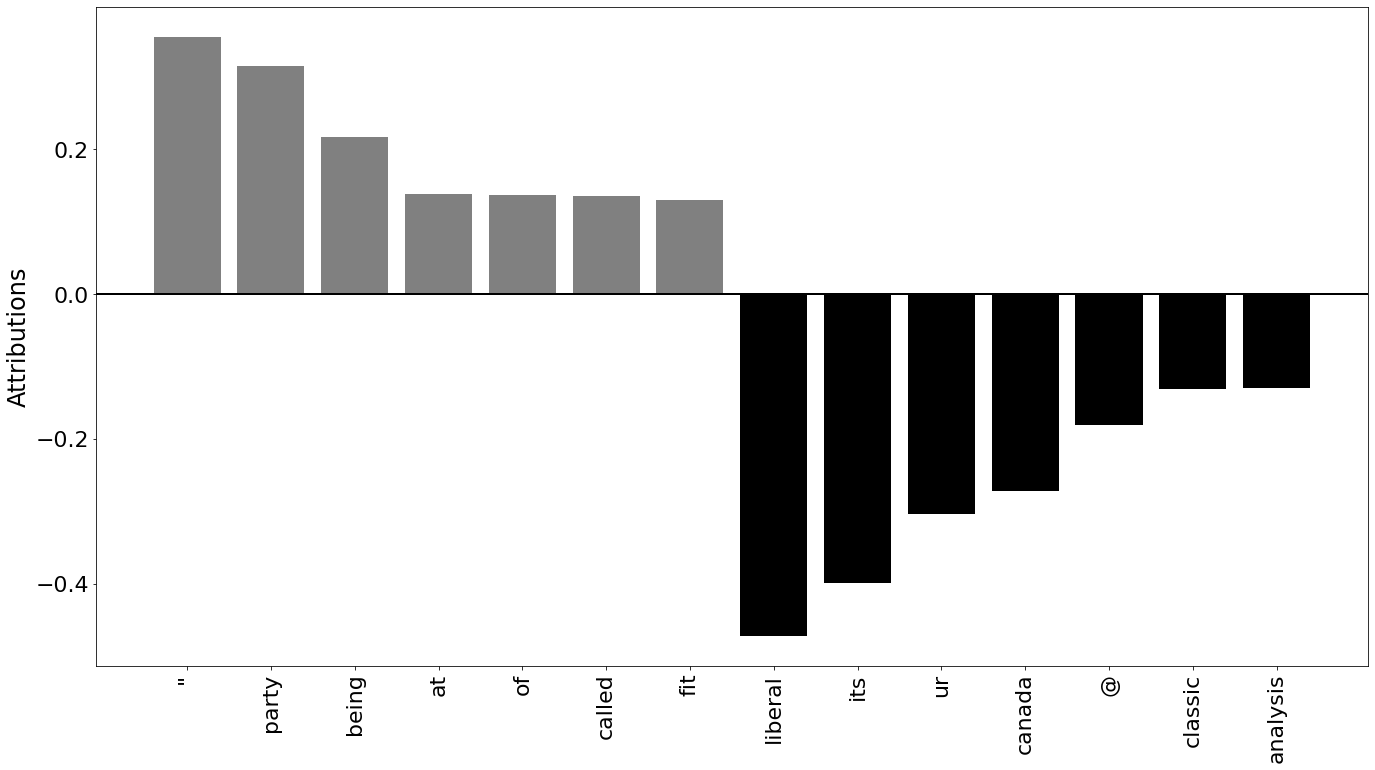

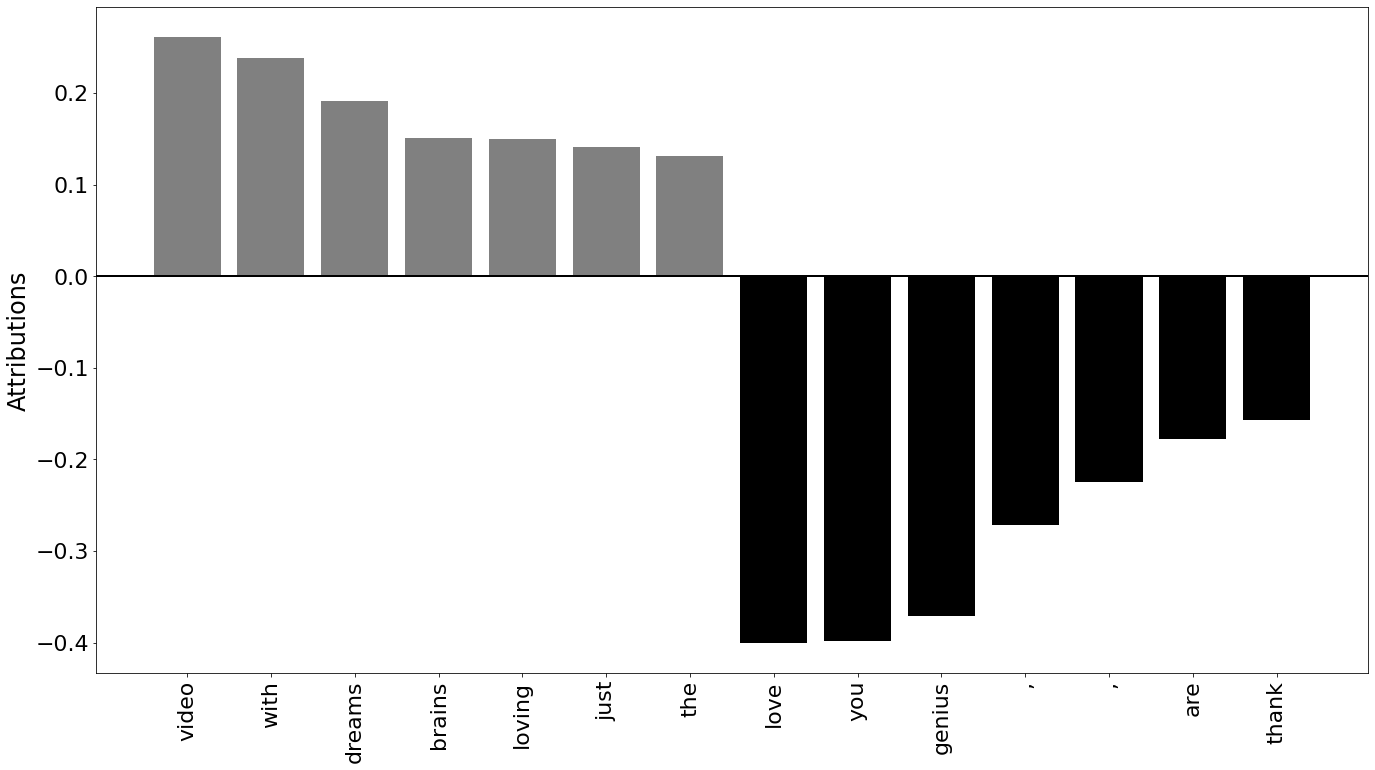

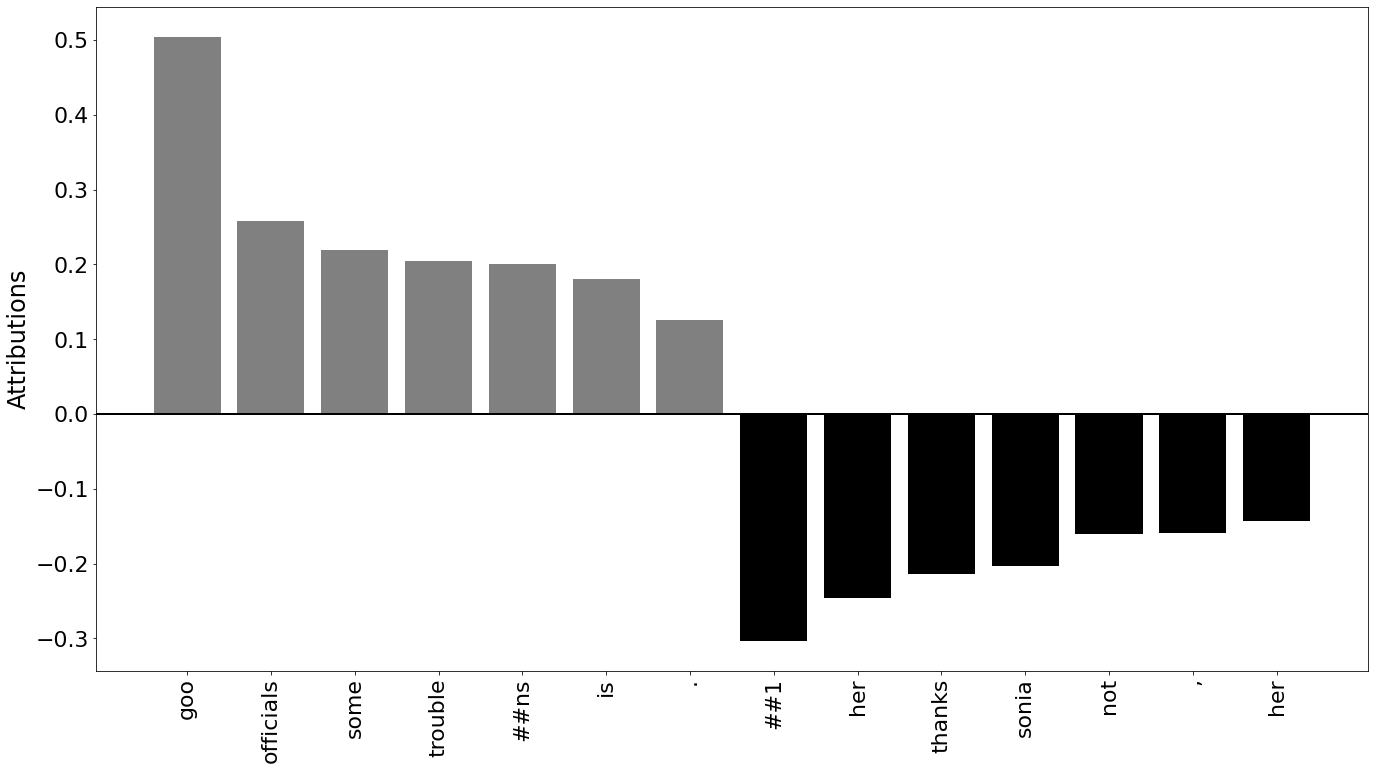

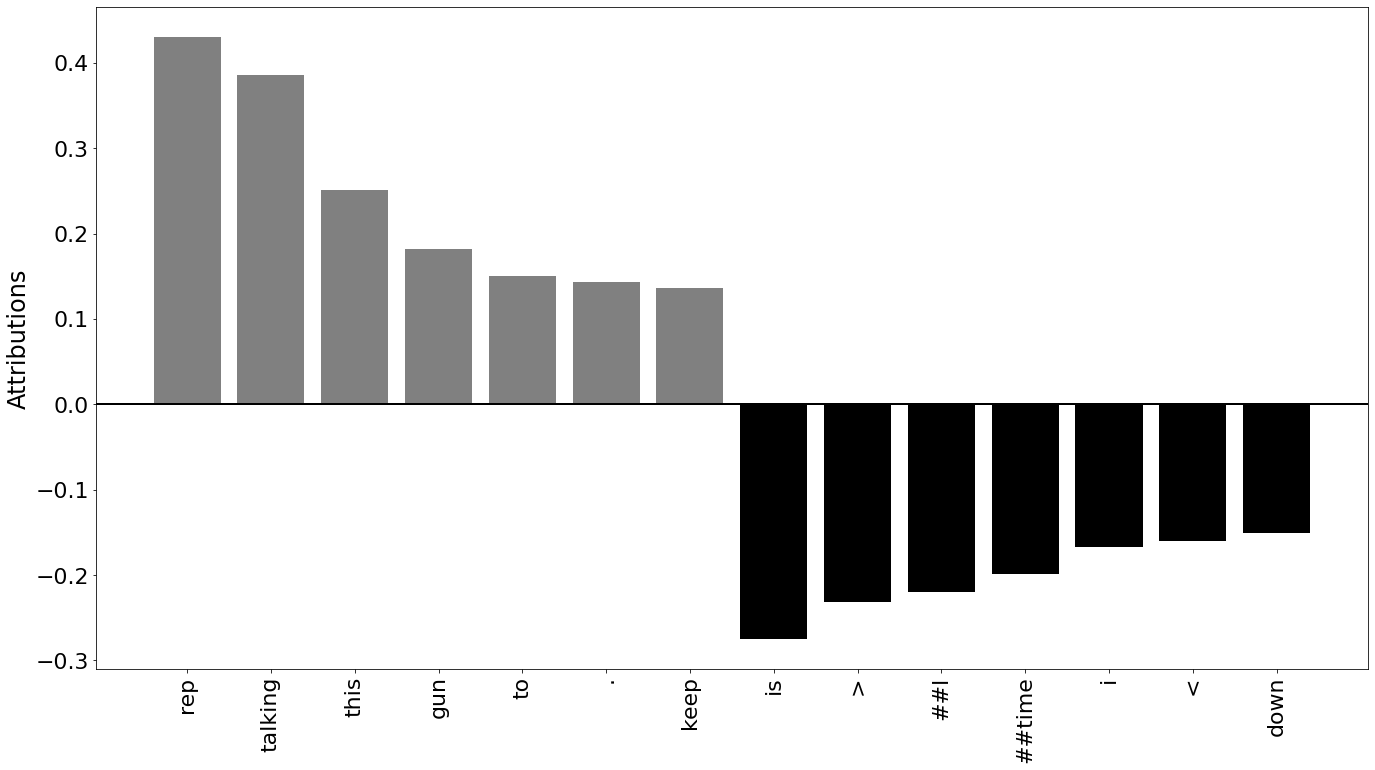

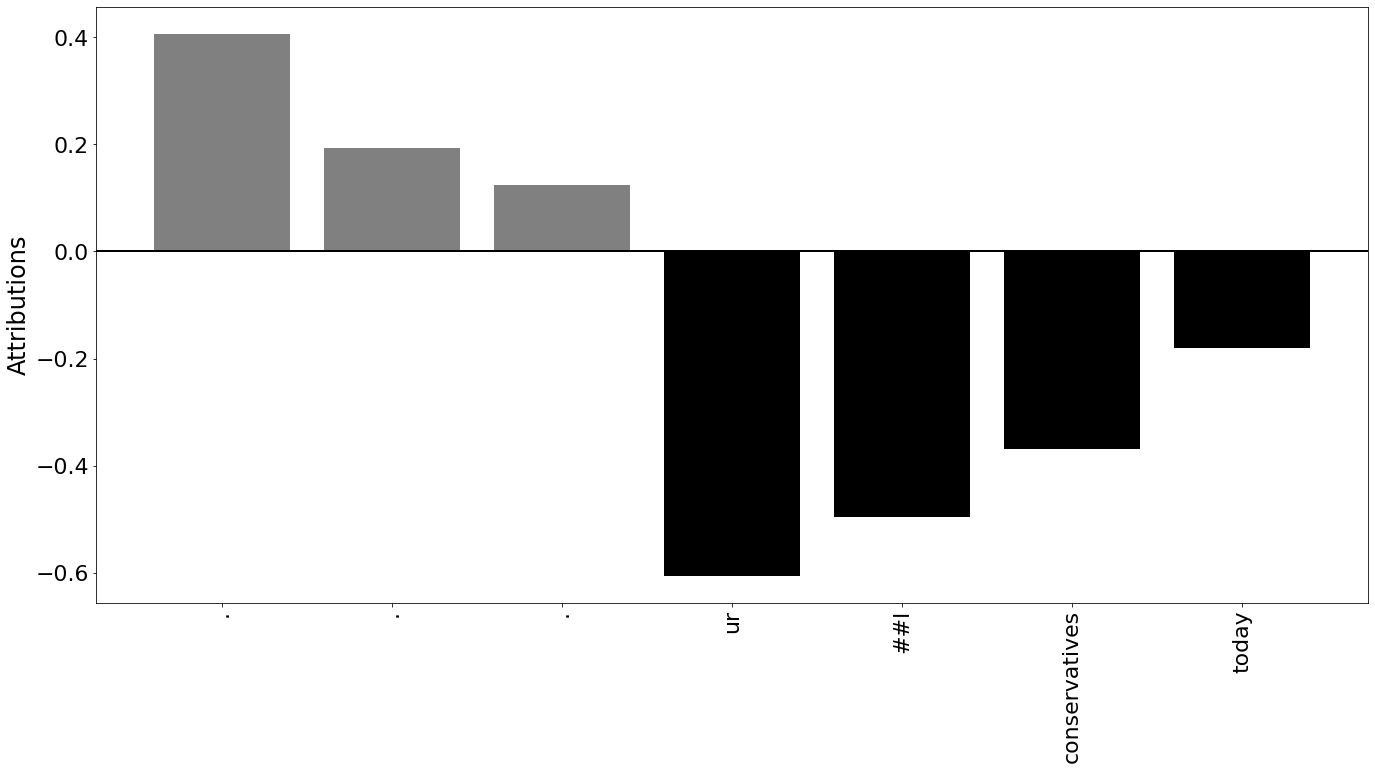

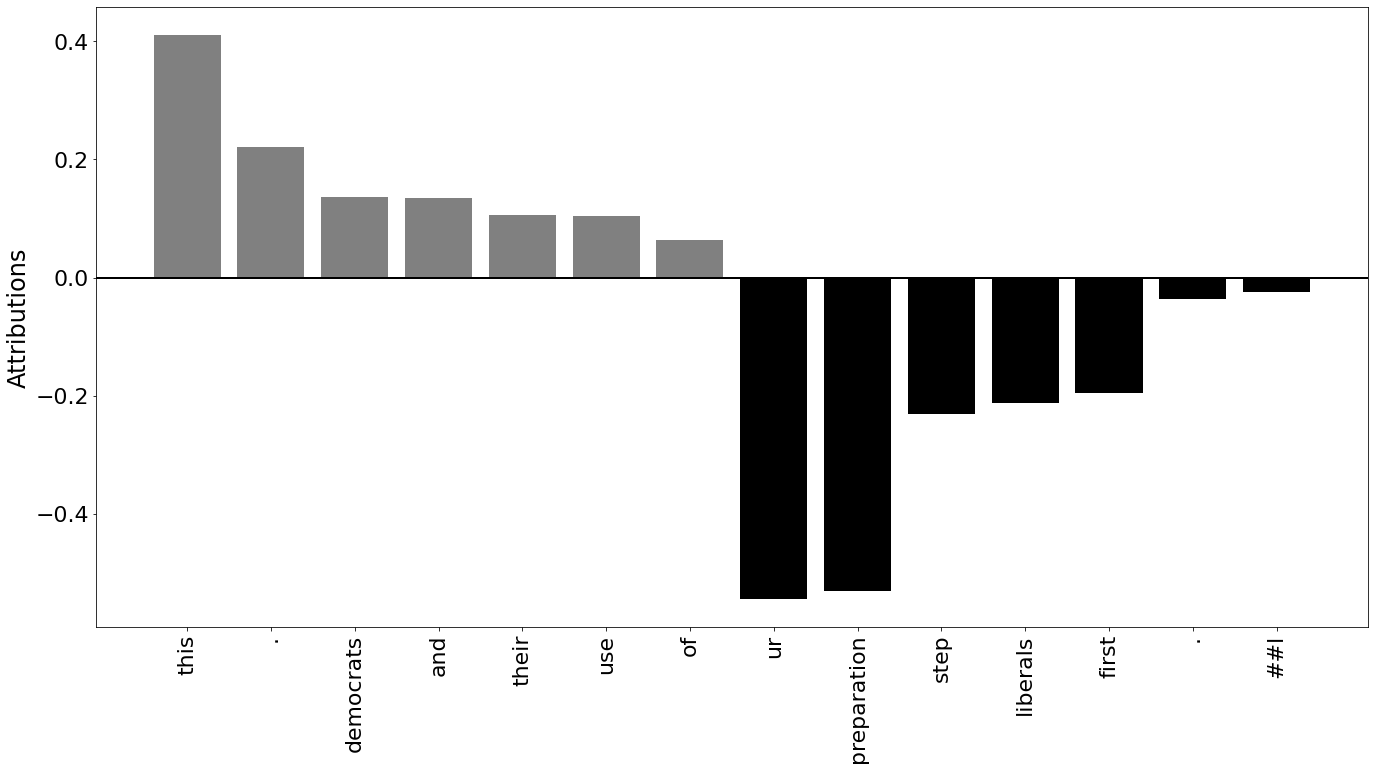

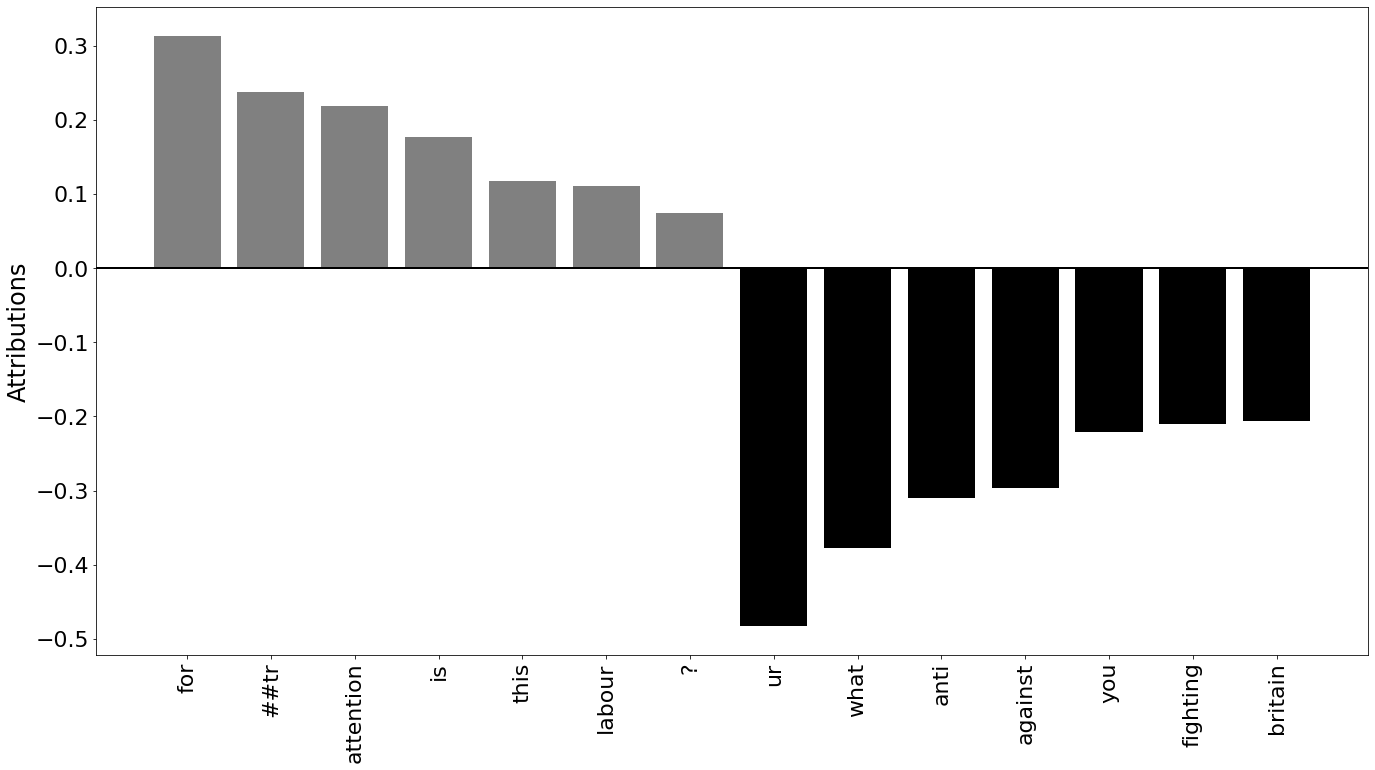

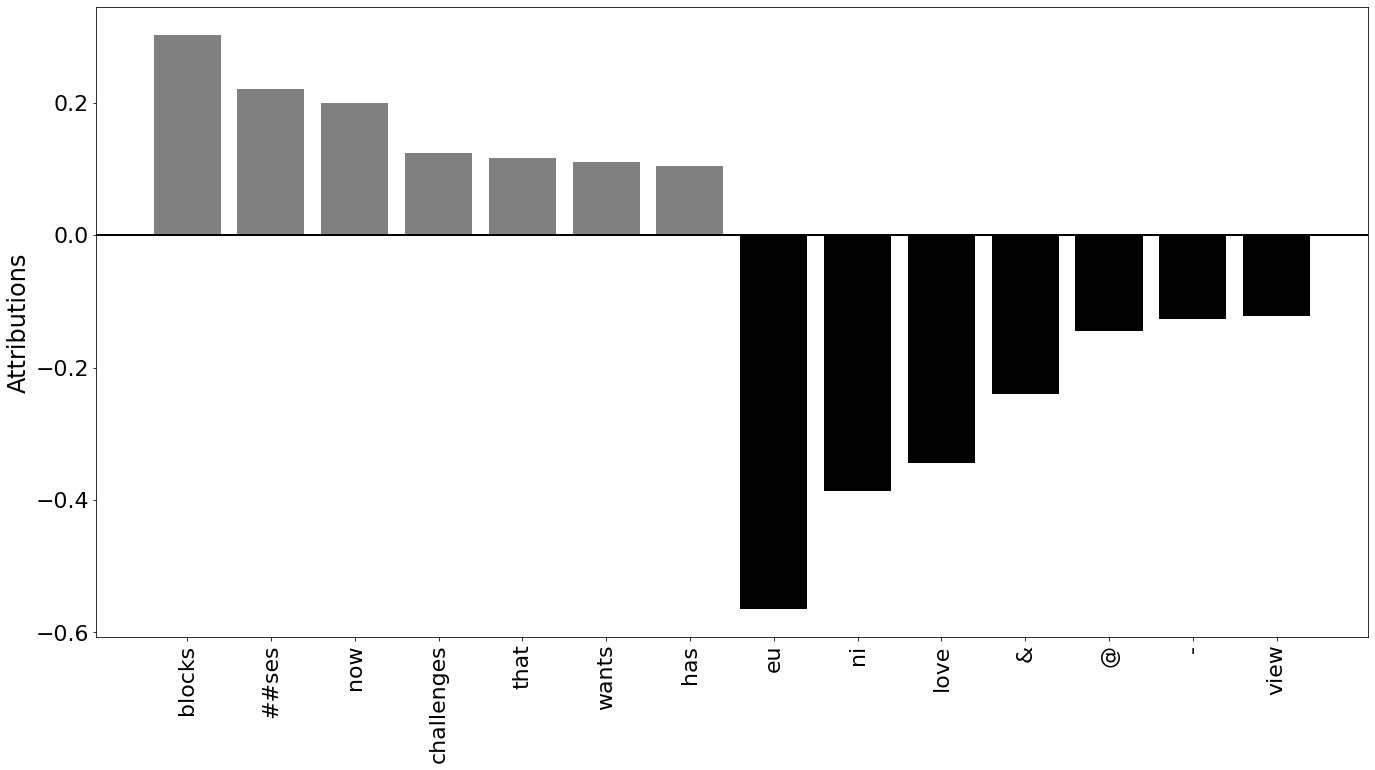

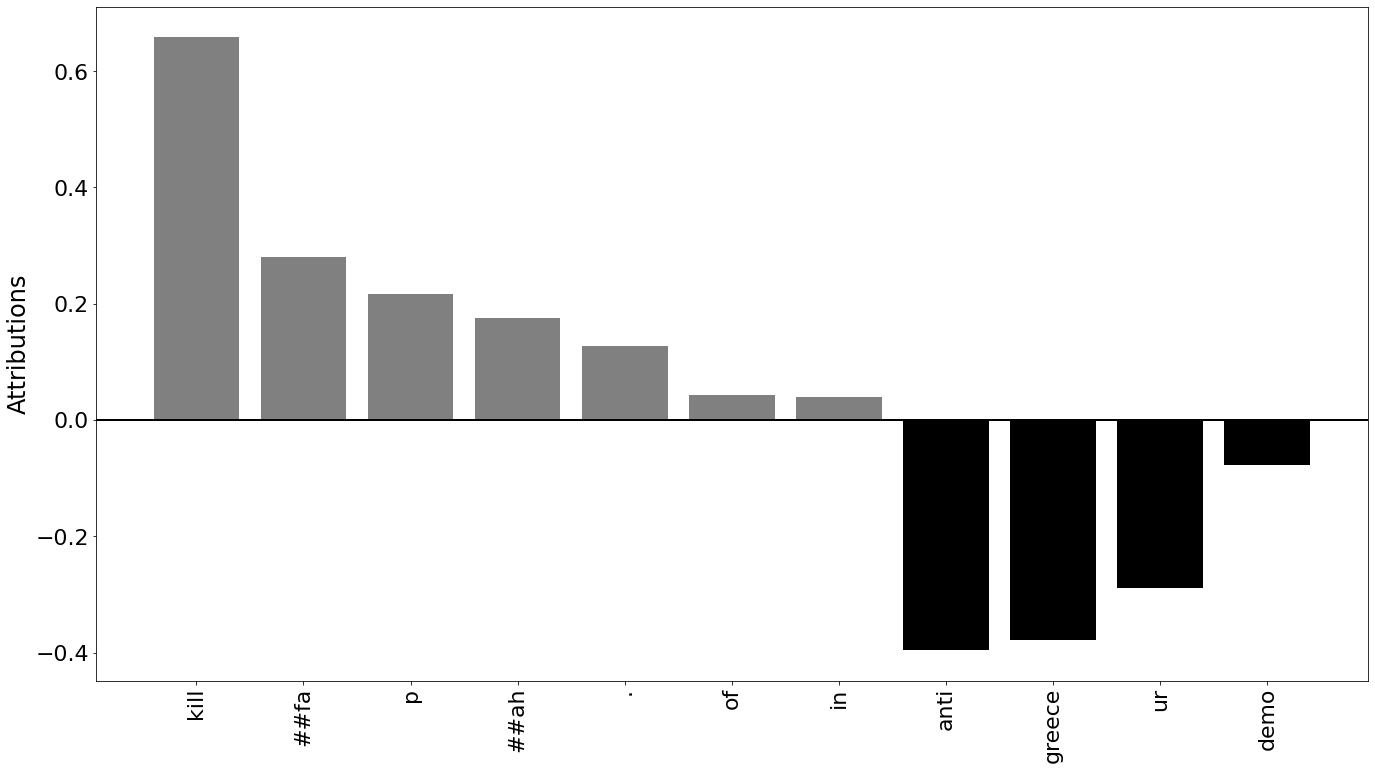

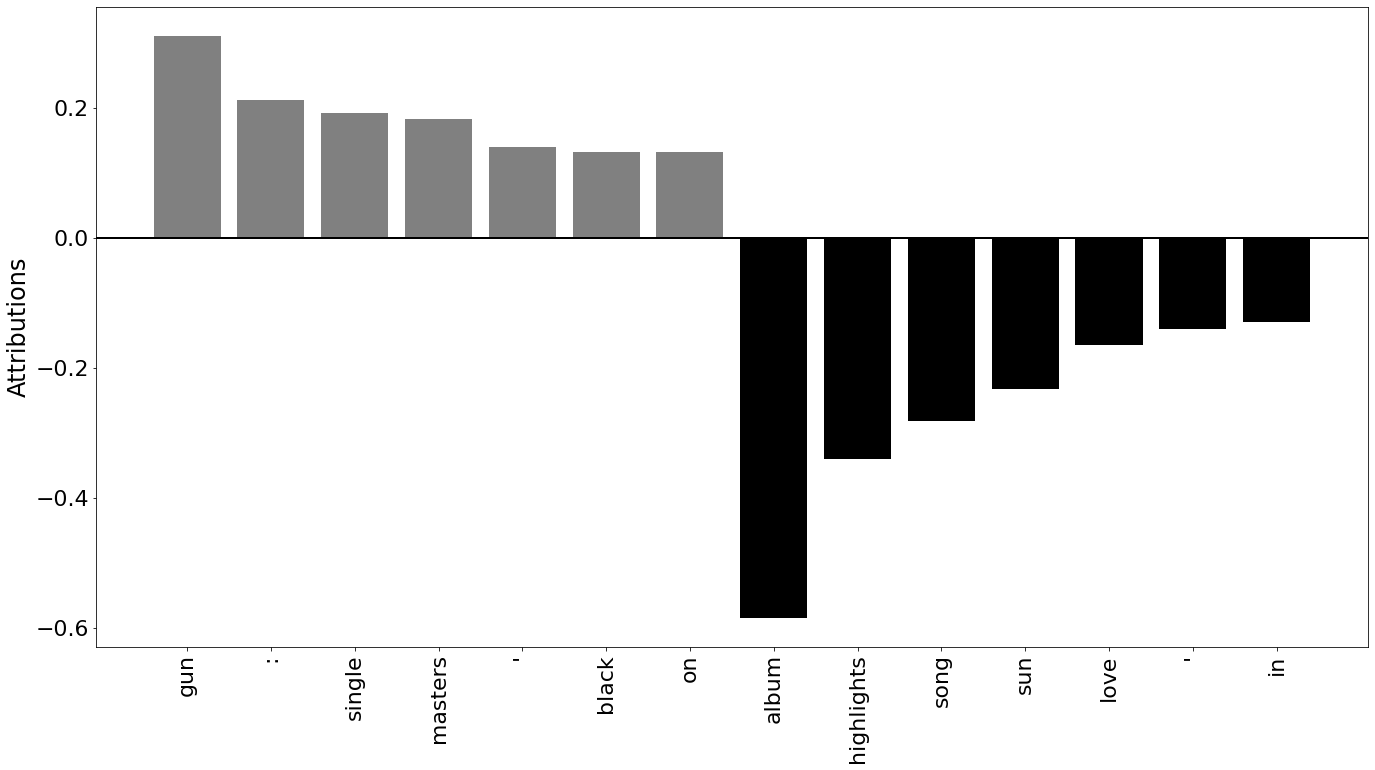

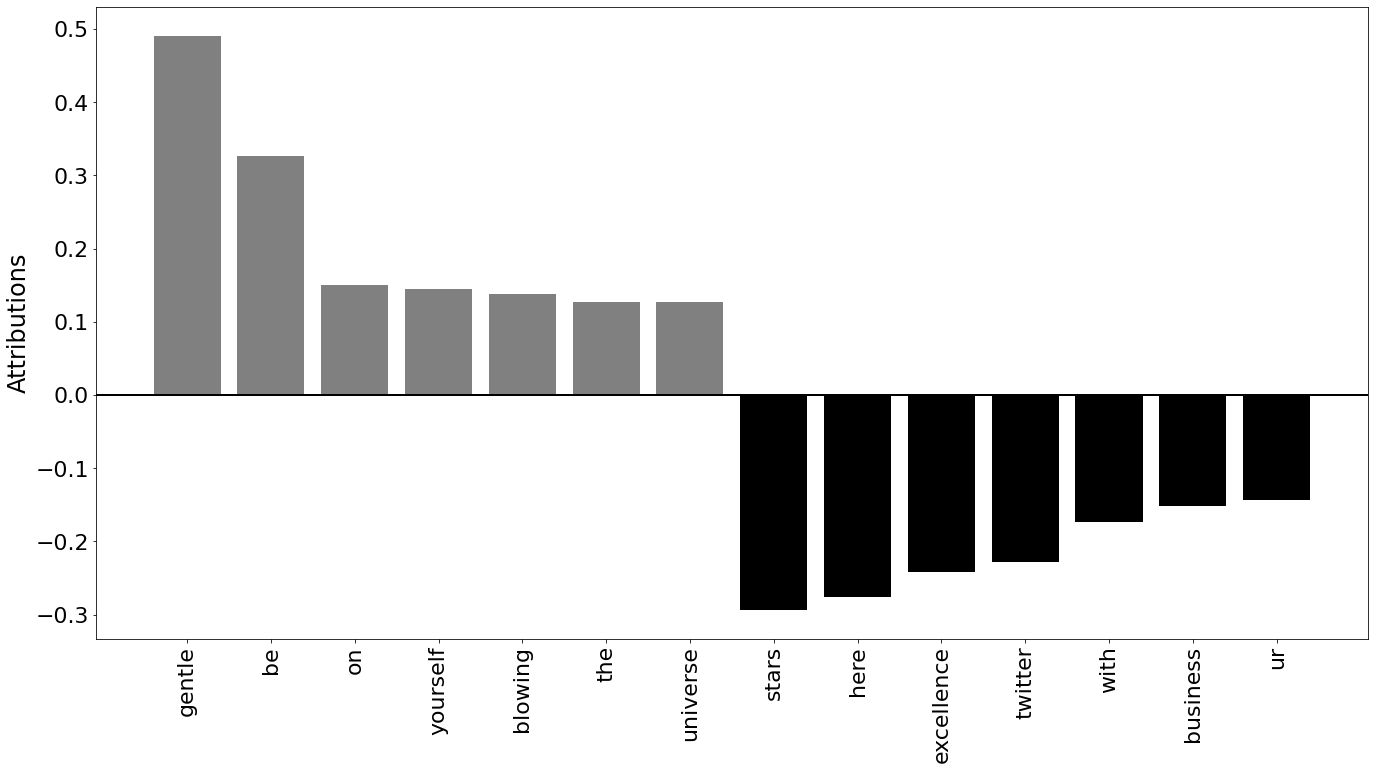

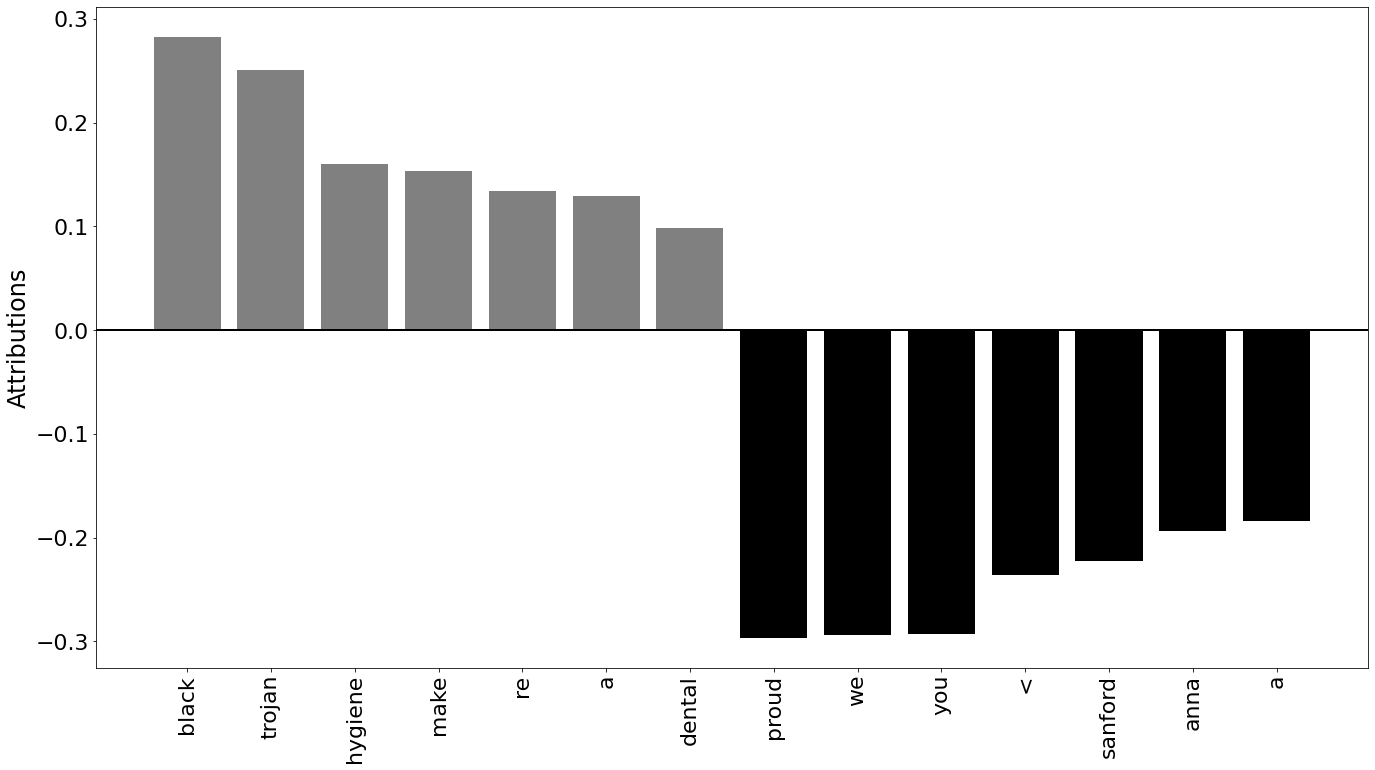

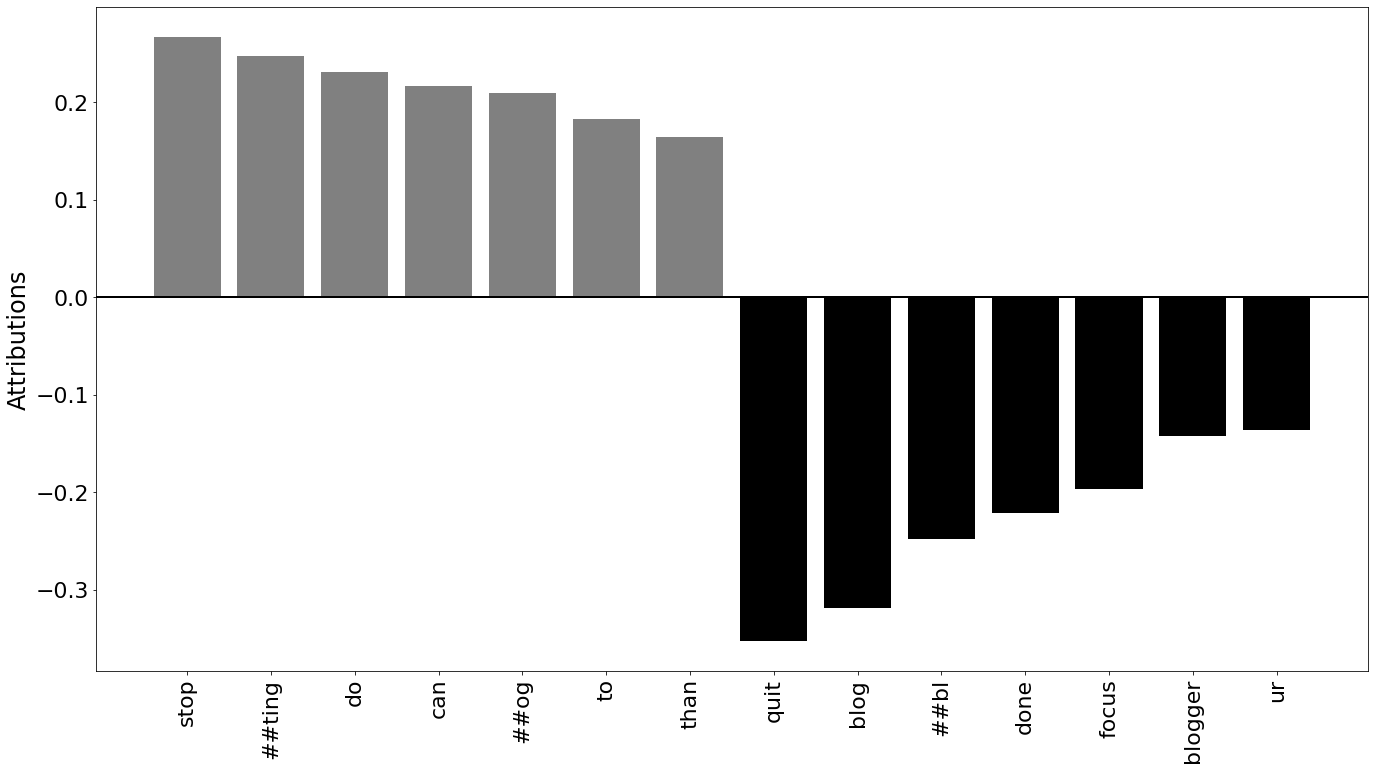

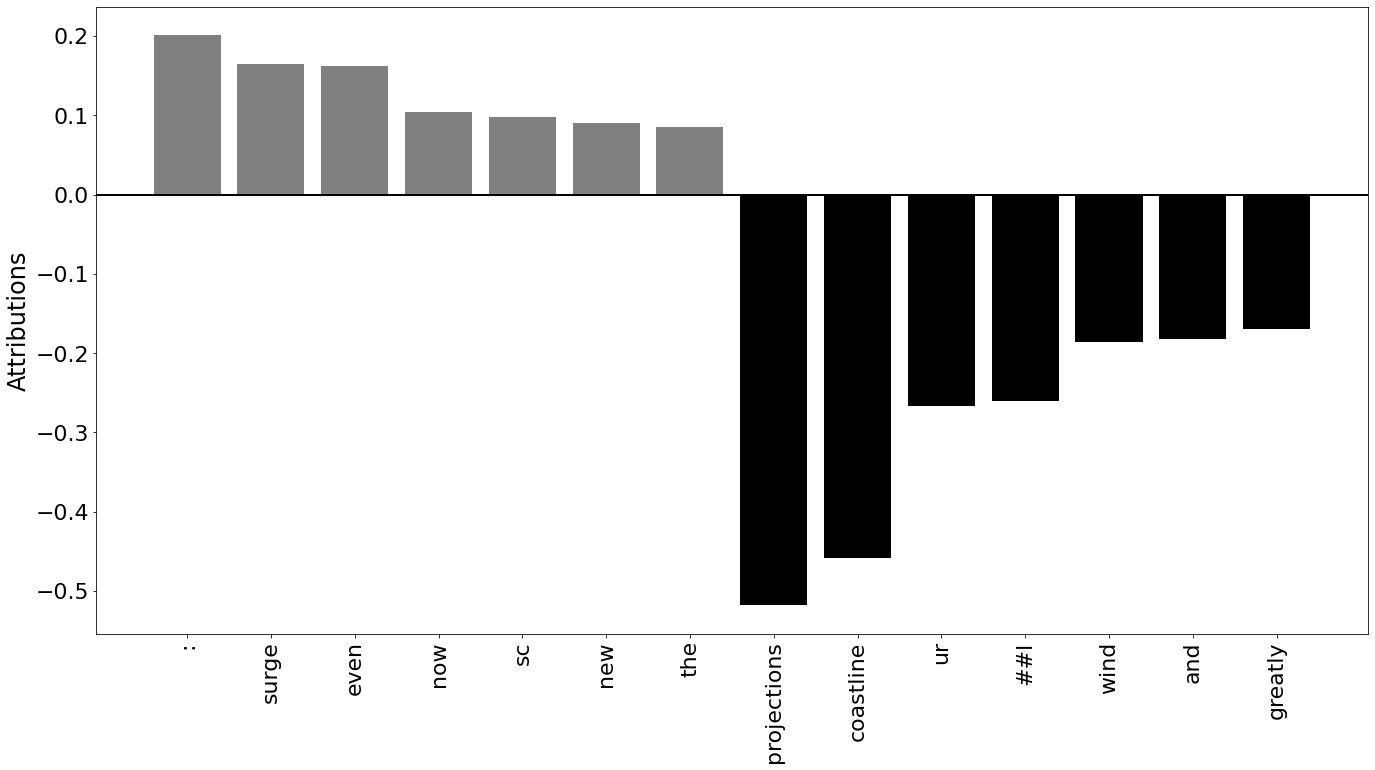

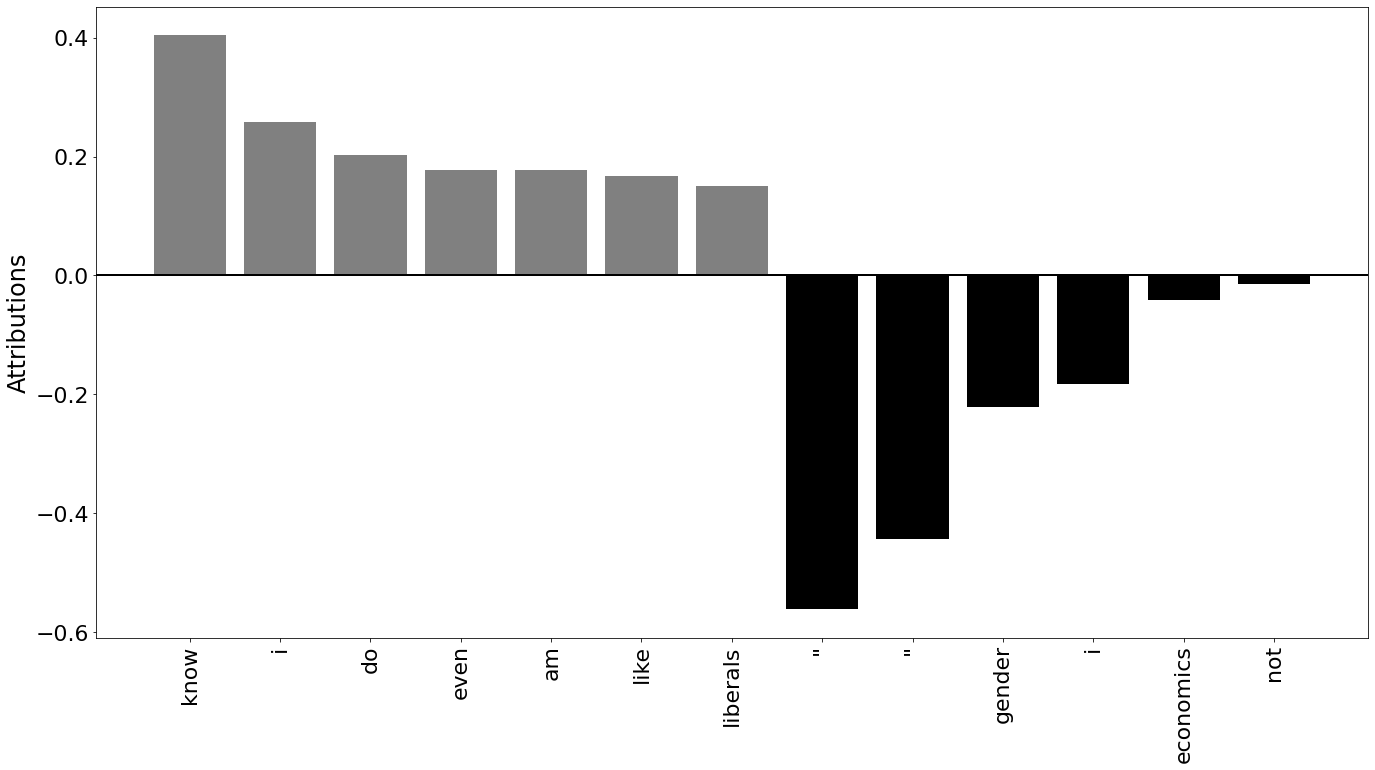

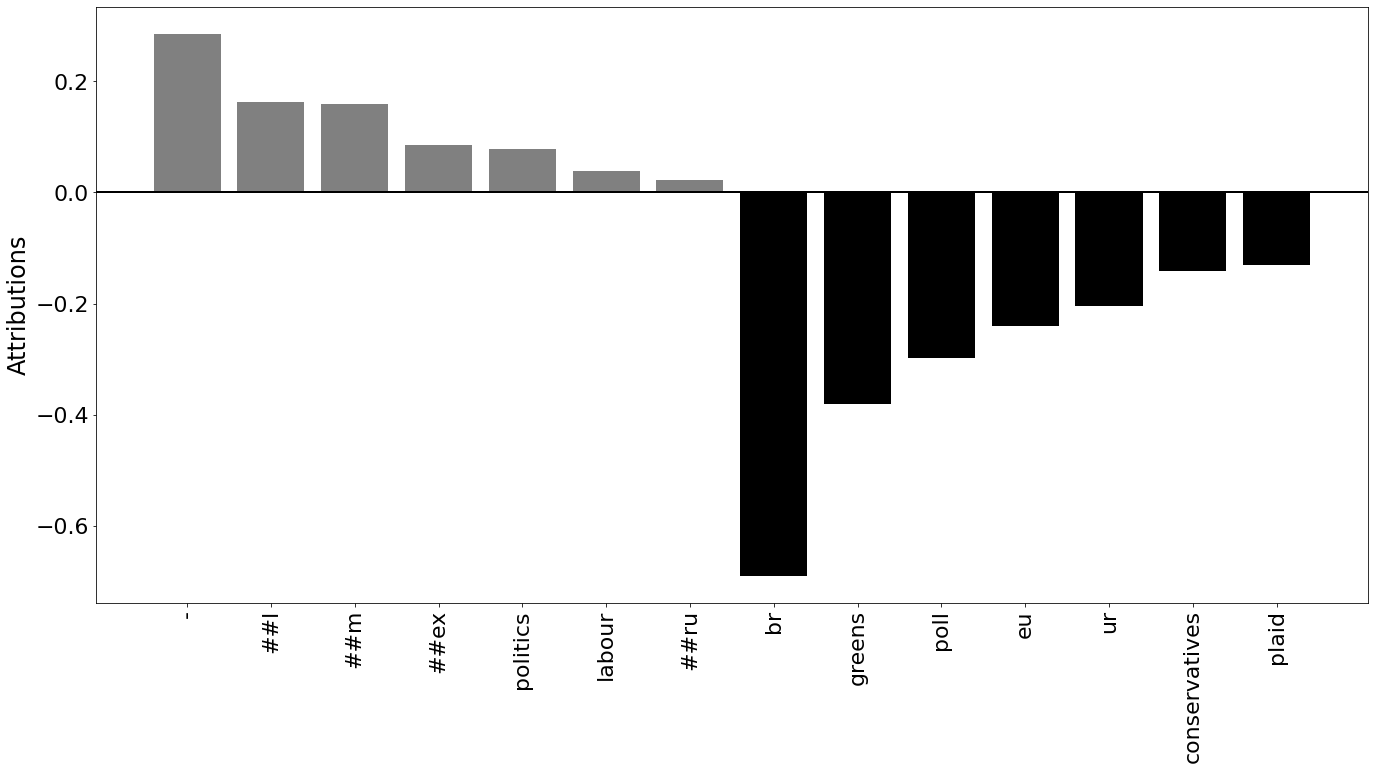

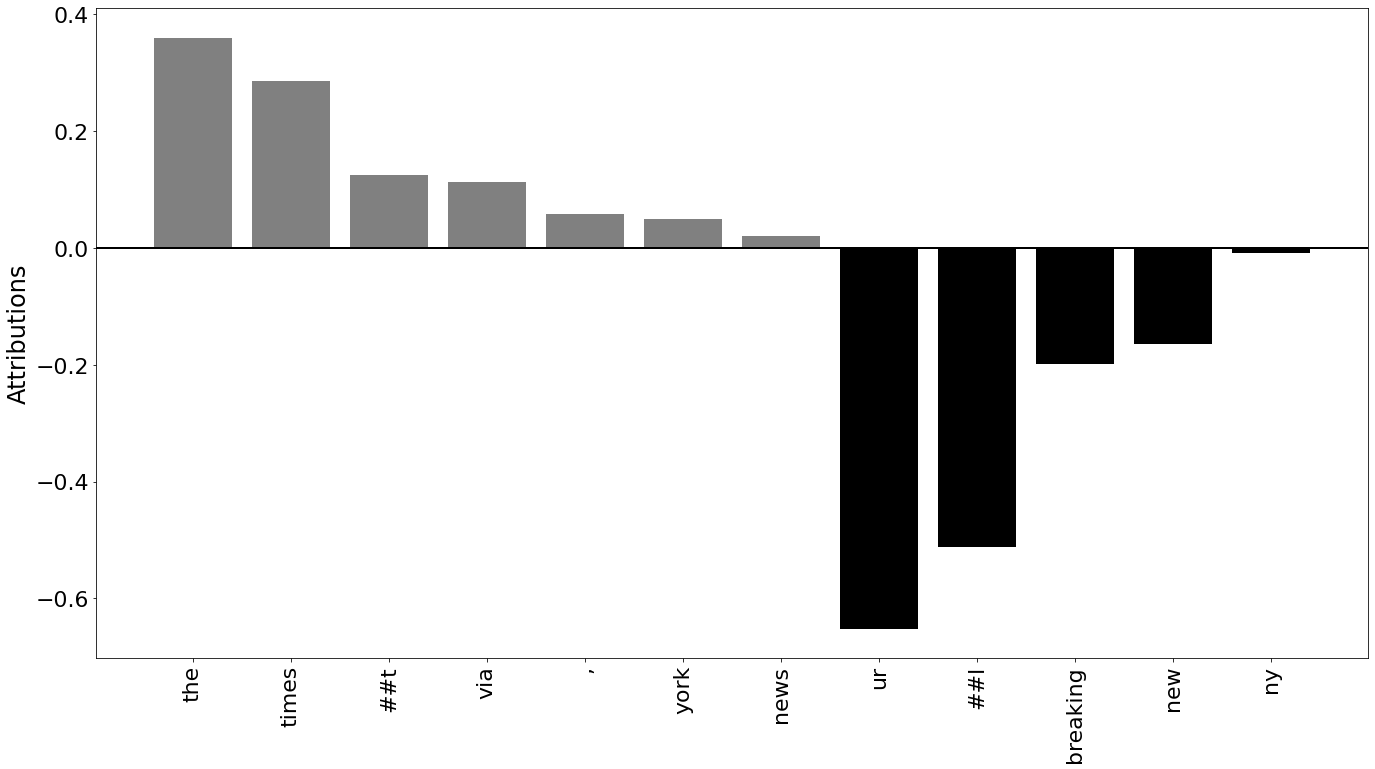

 Visualization For Score Accurate True negative predictions 


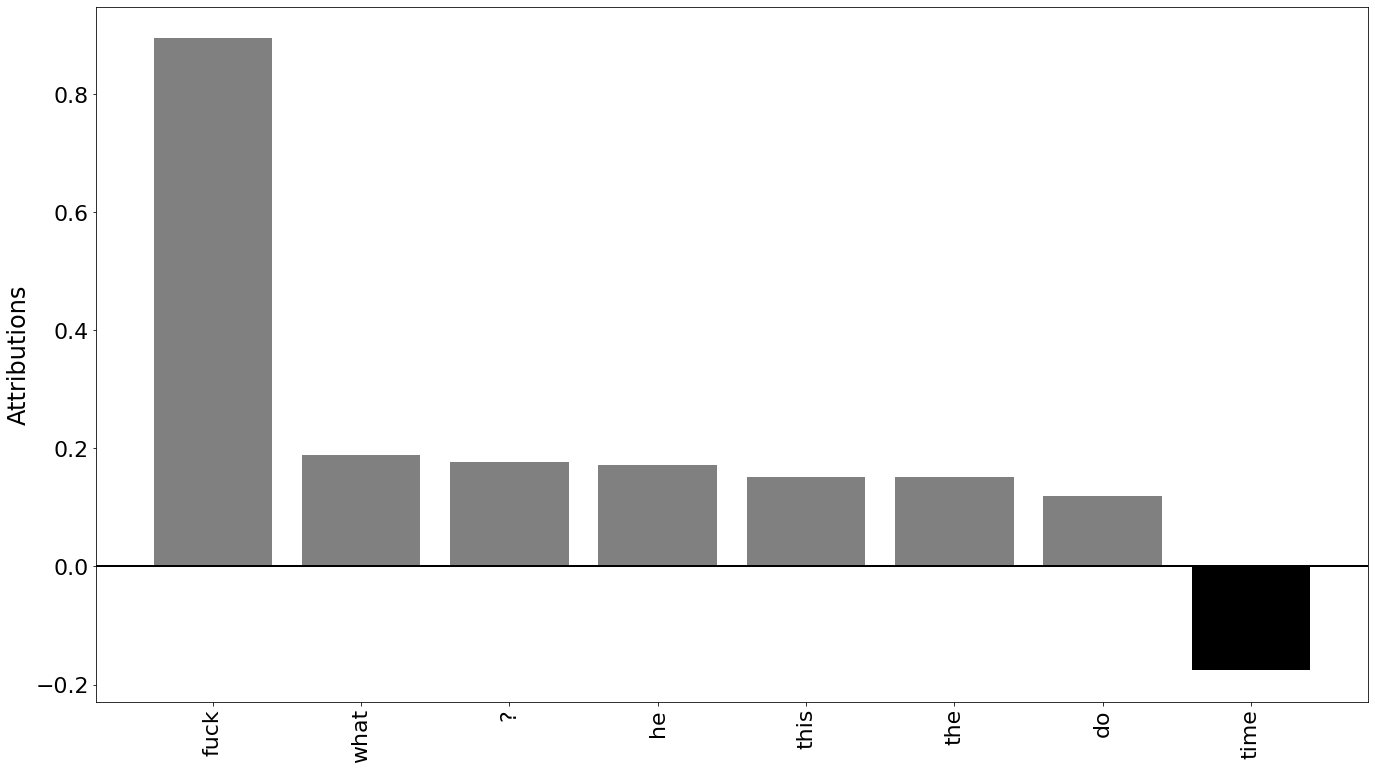

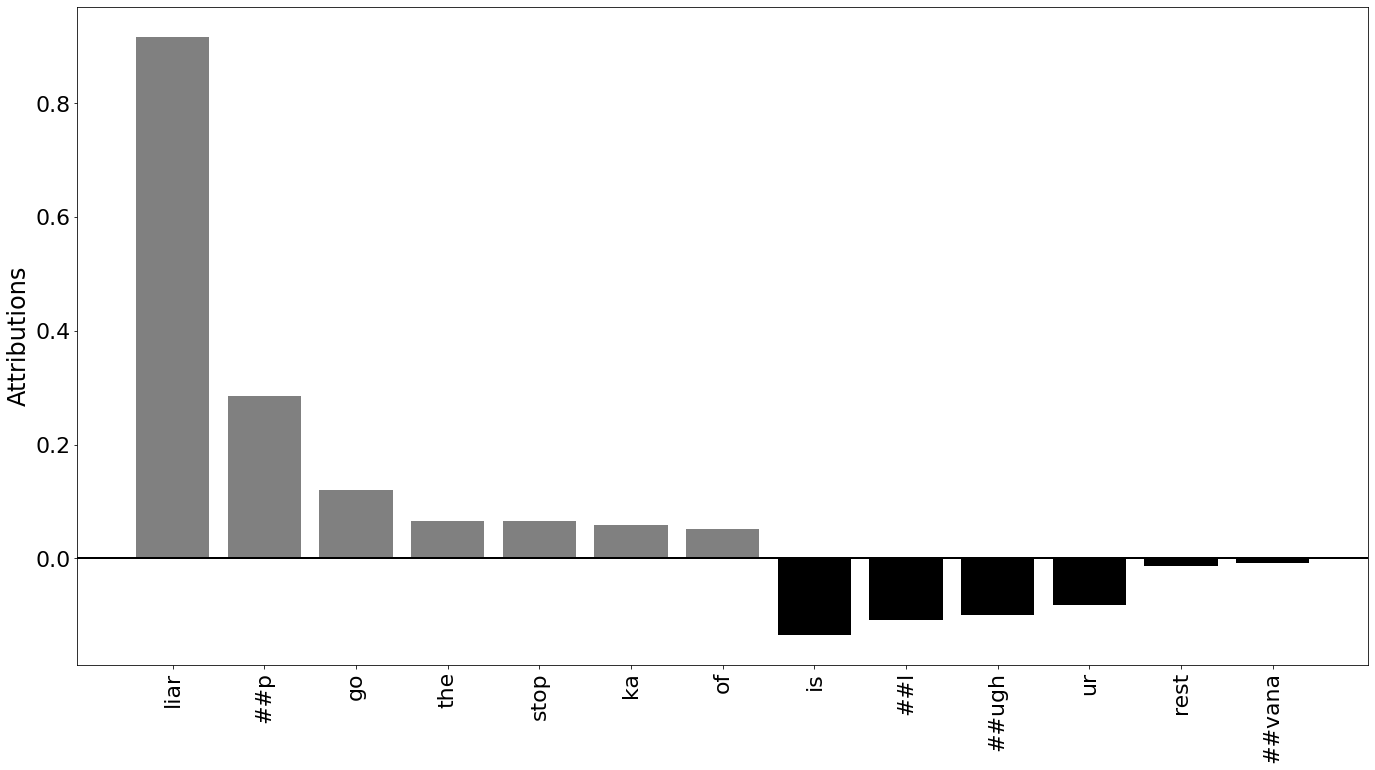

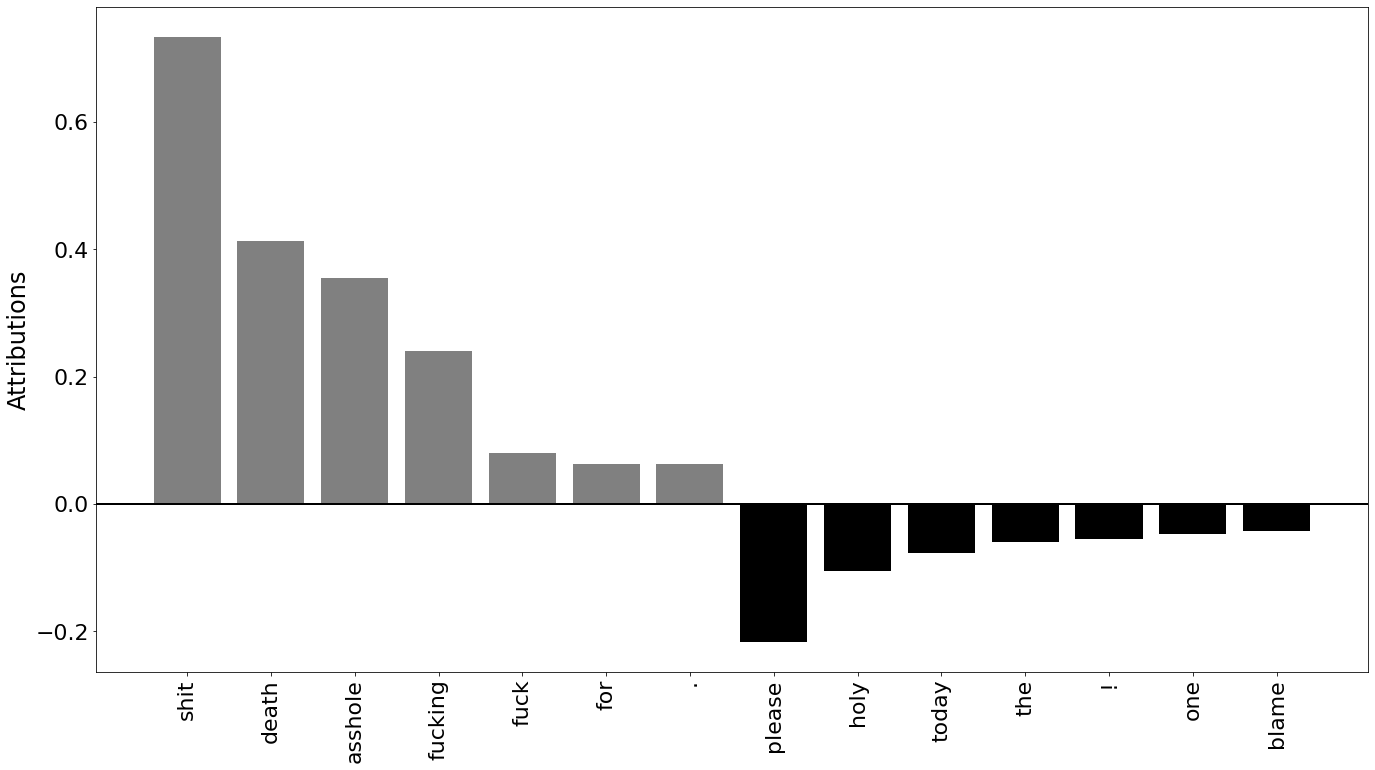

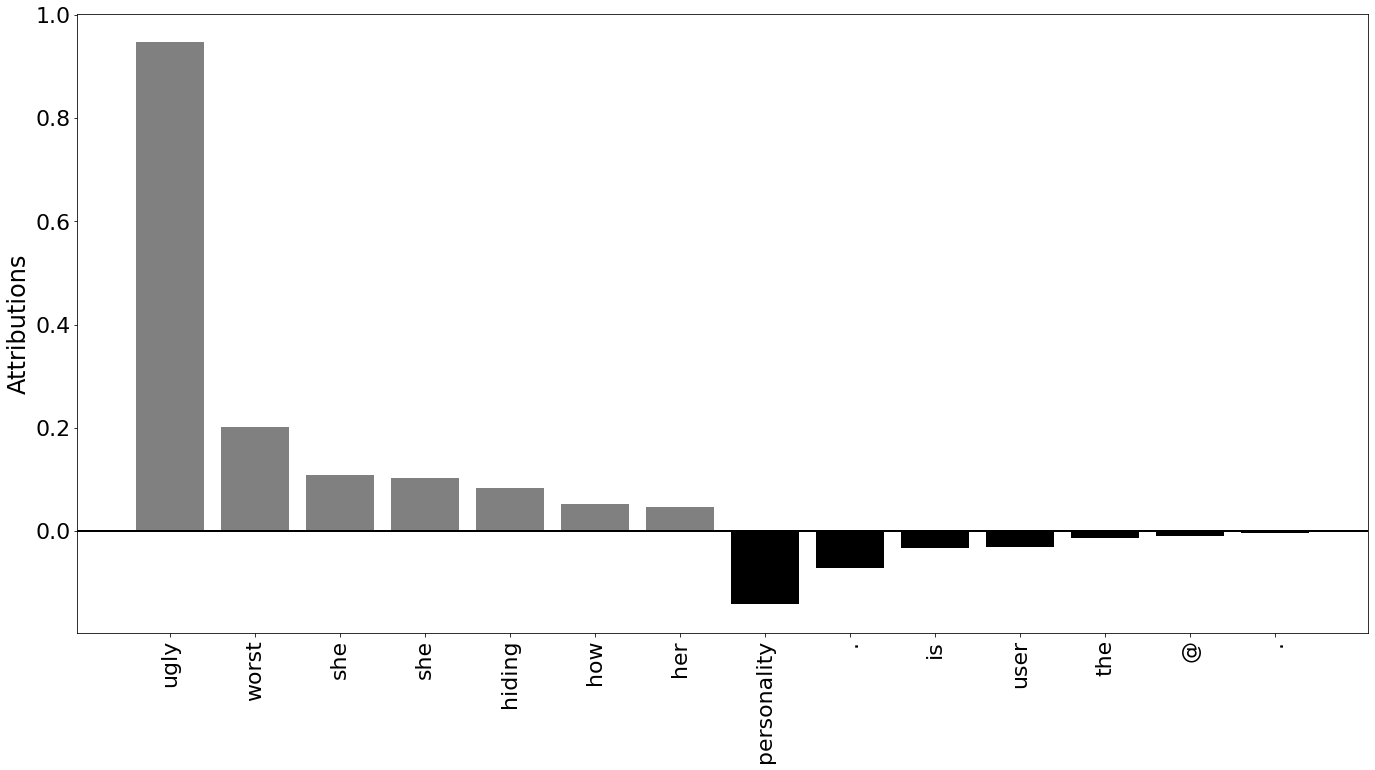

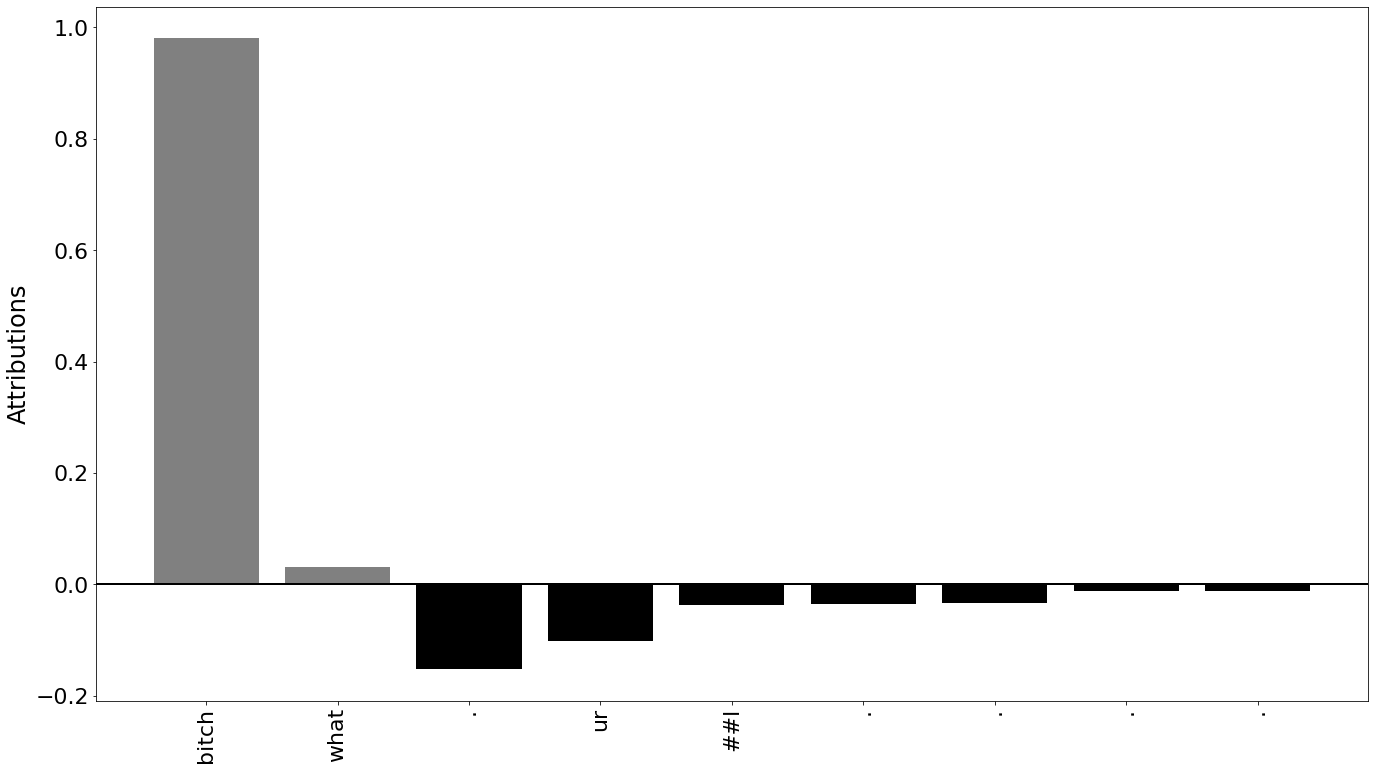

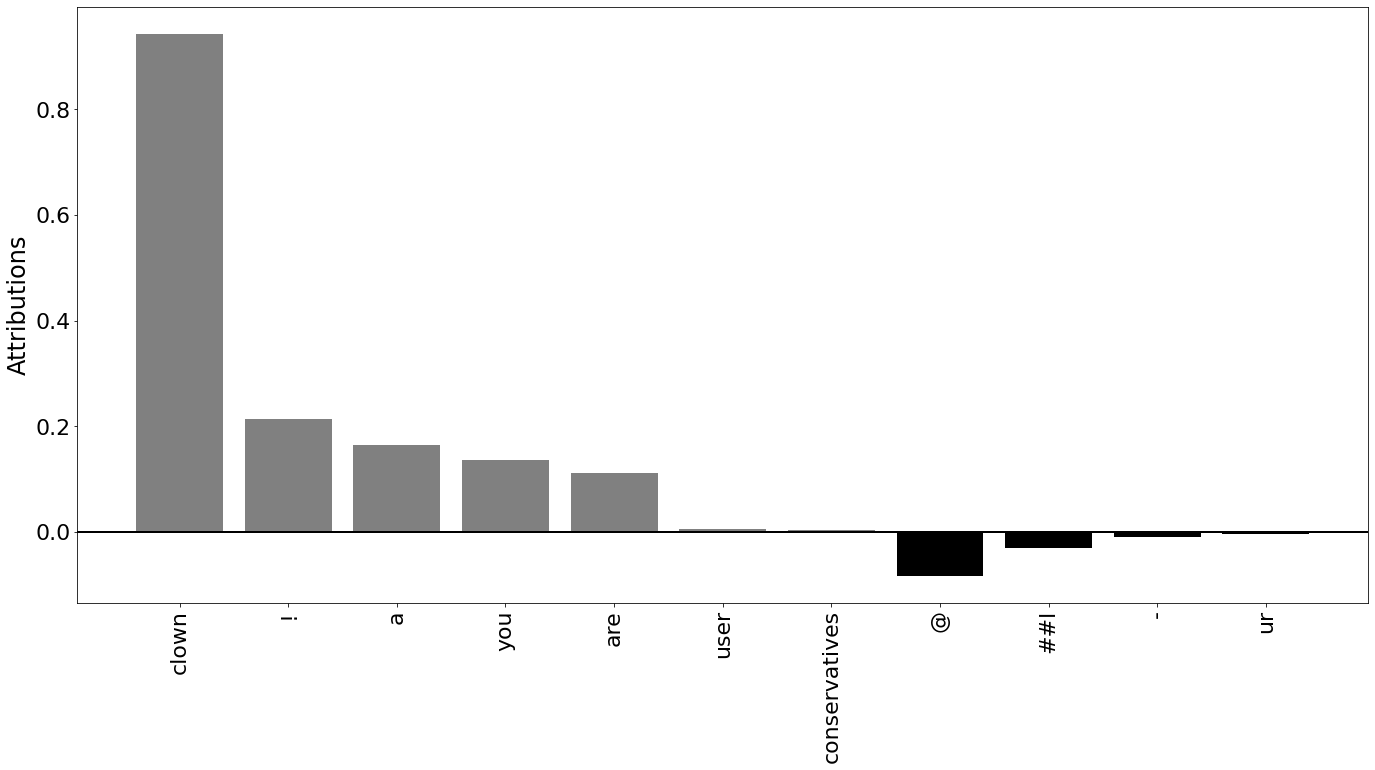

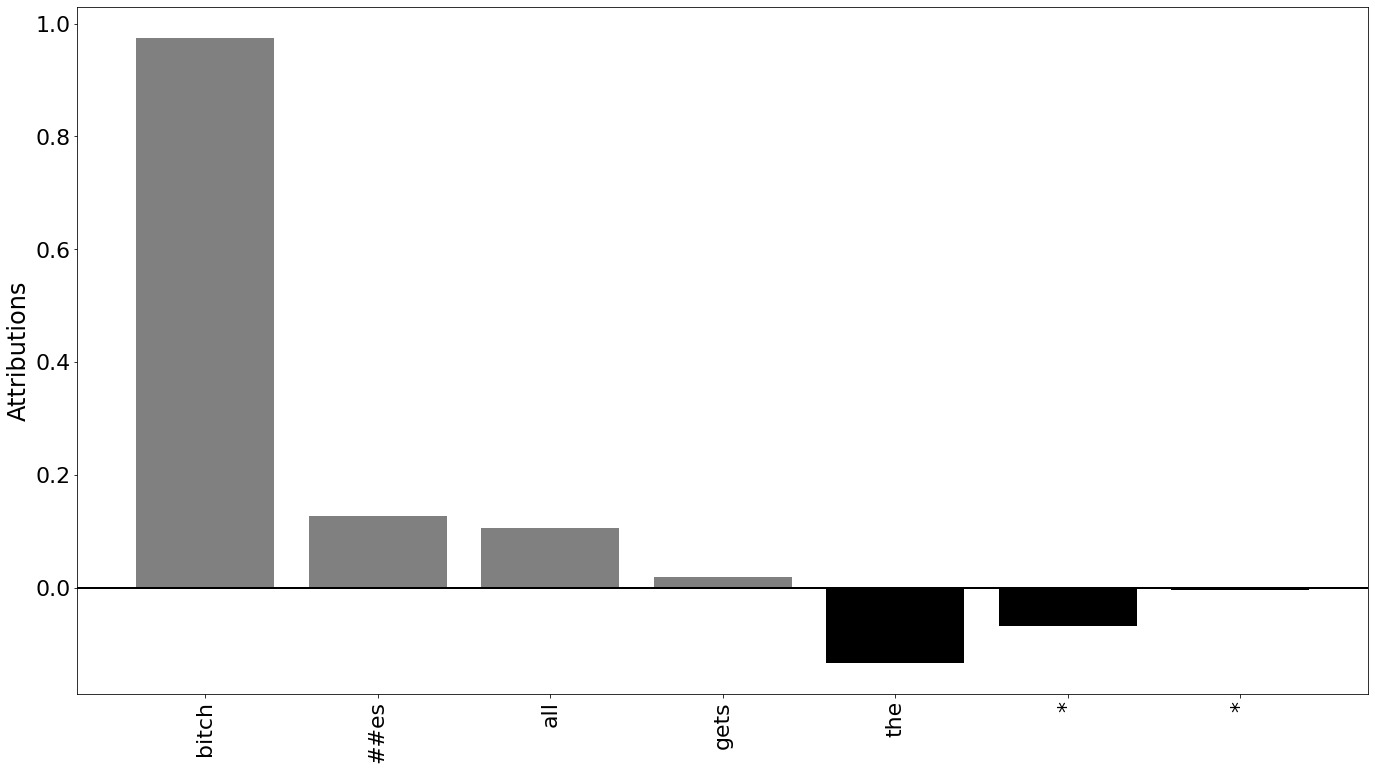

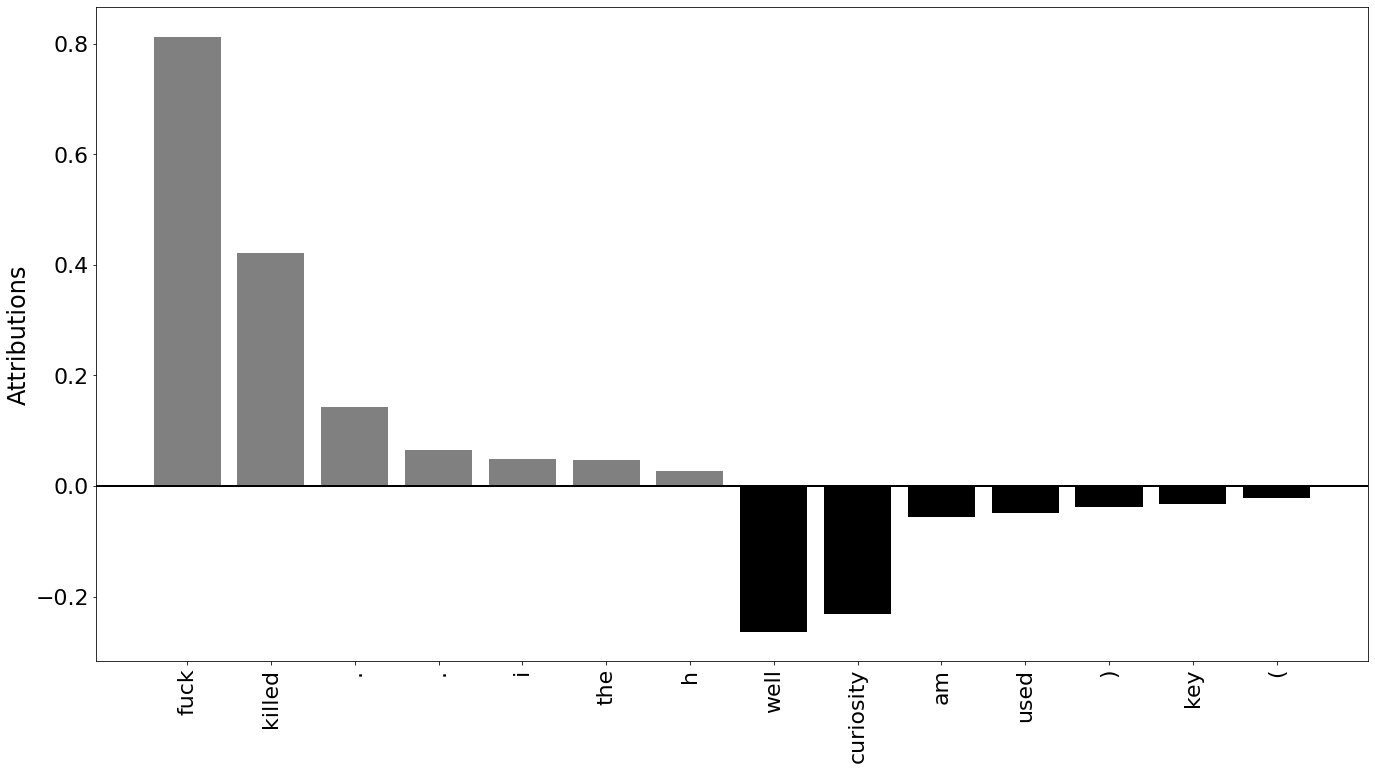

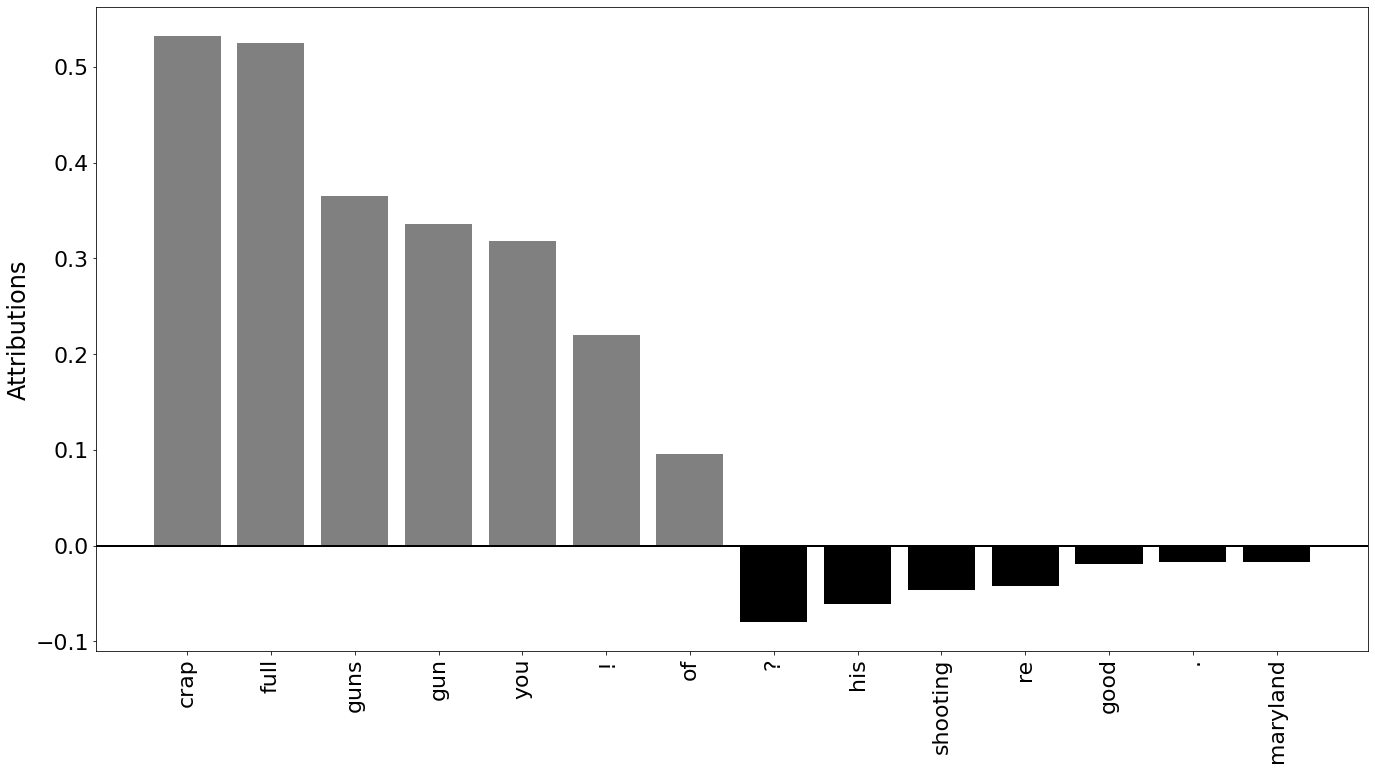

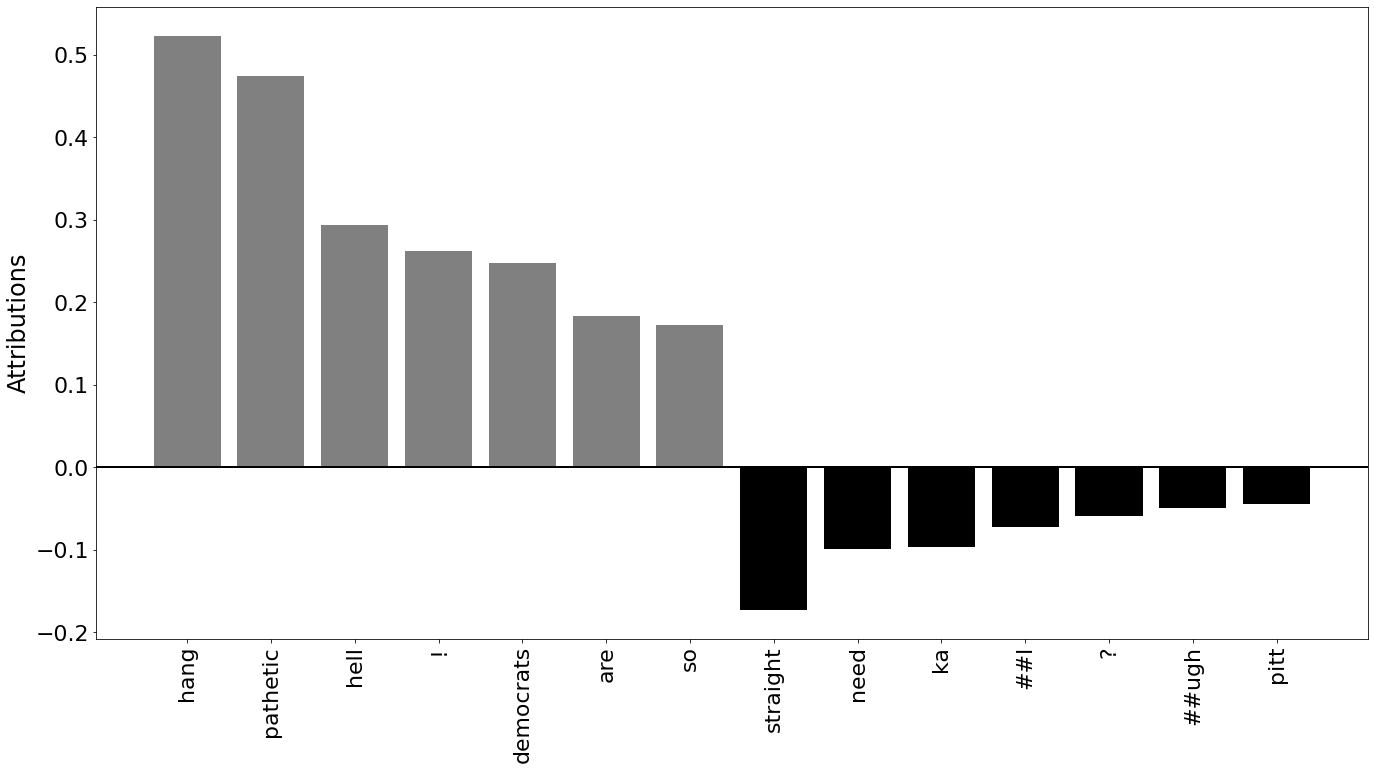

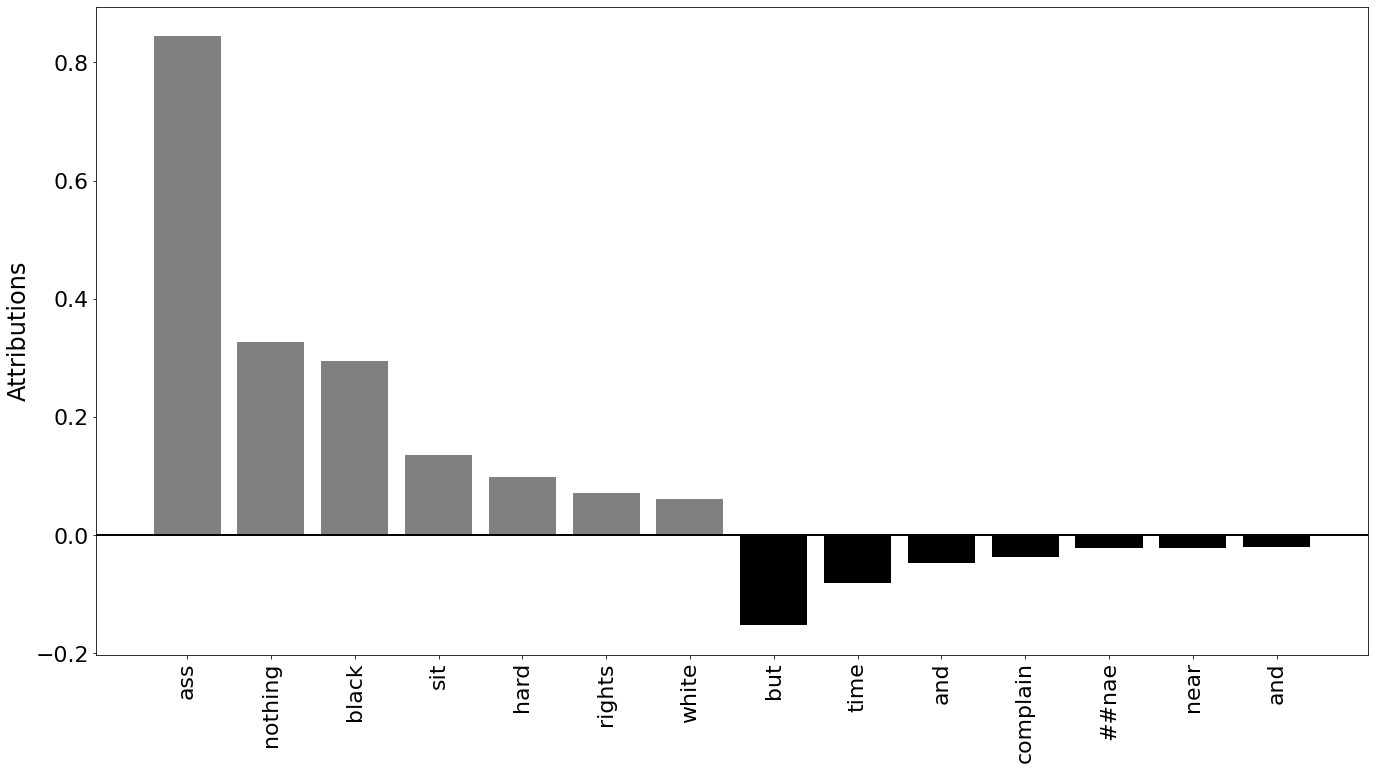

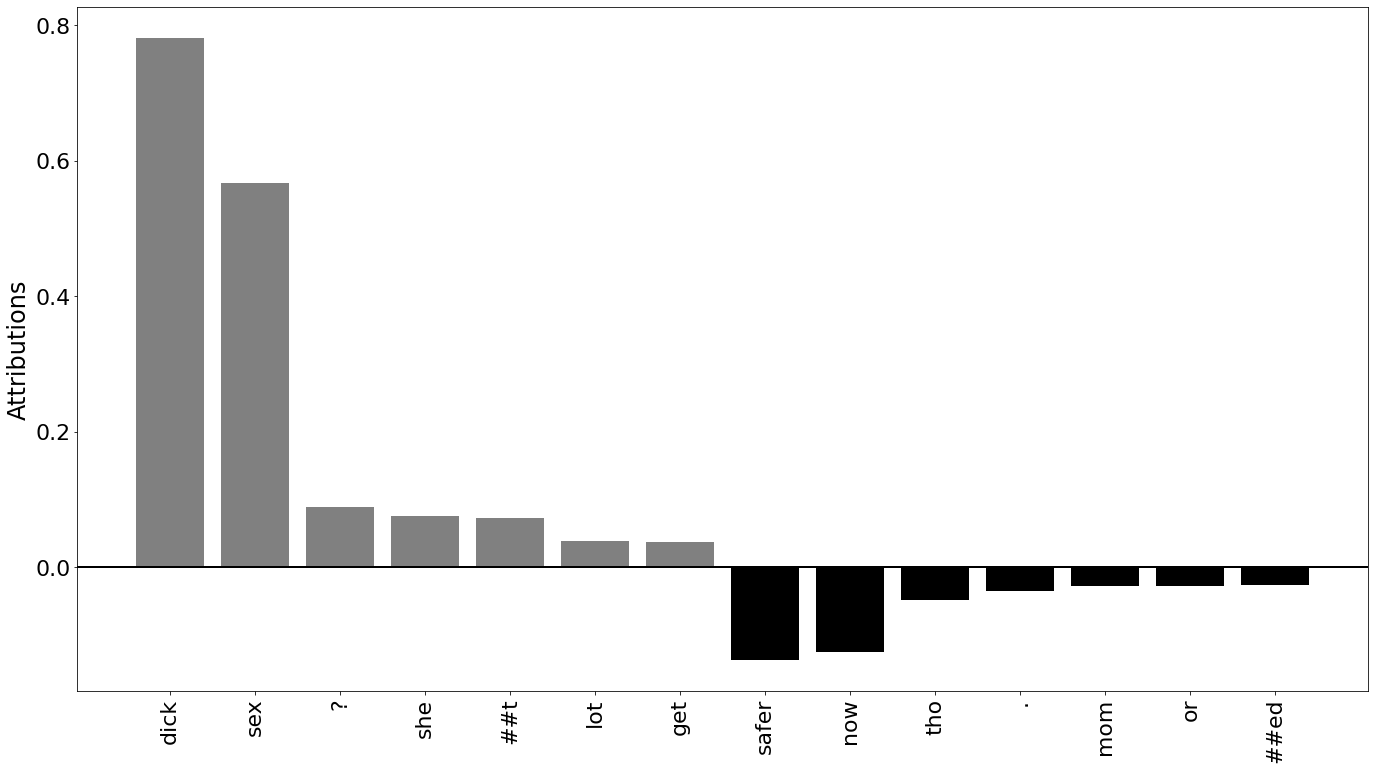

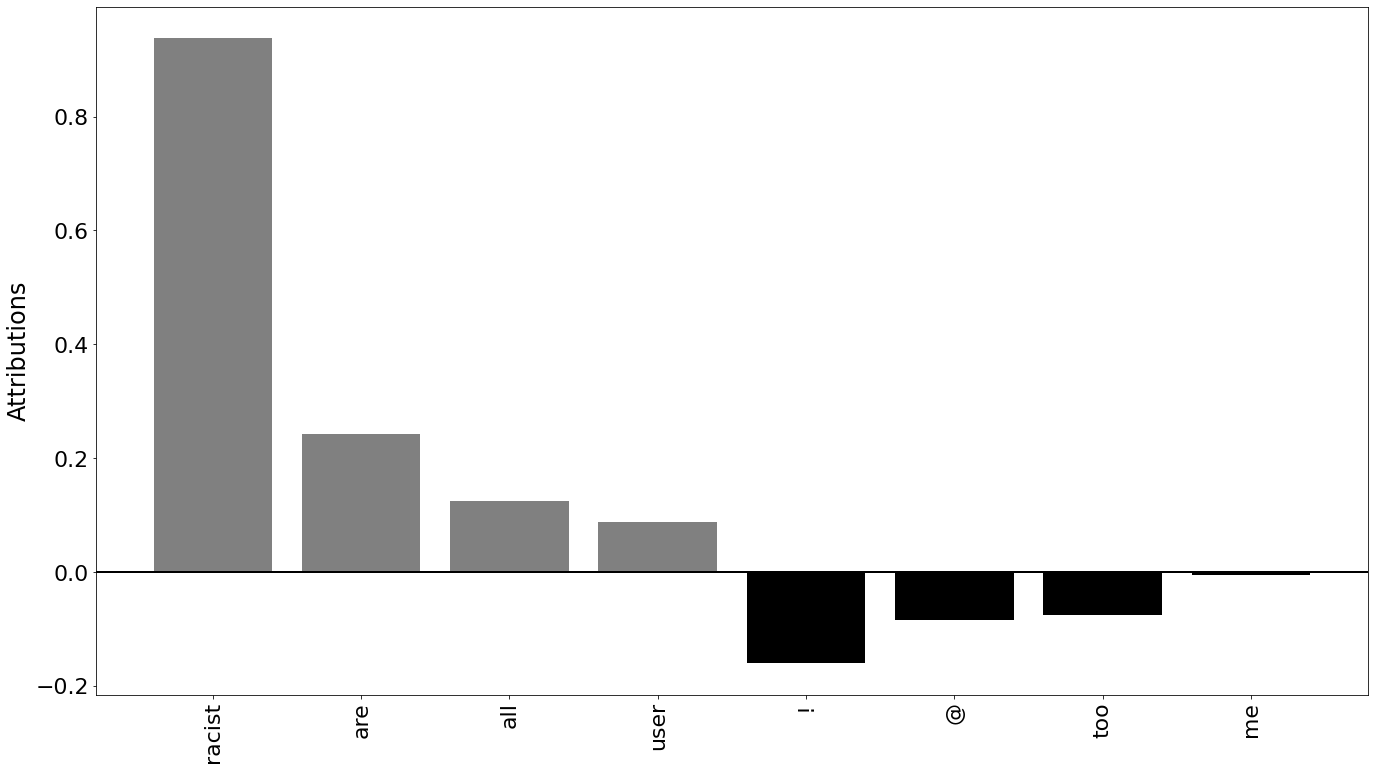

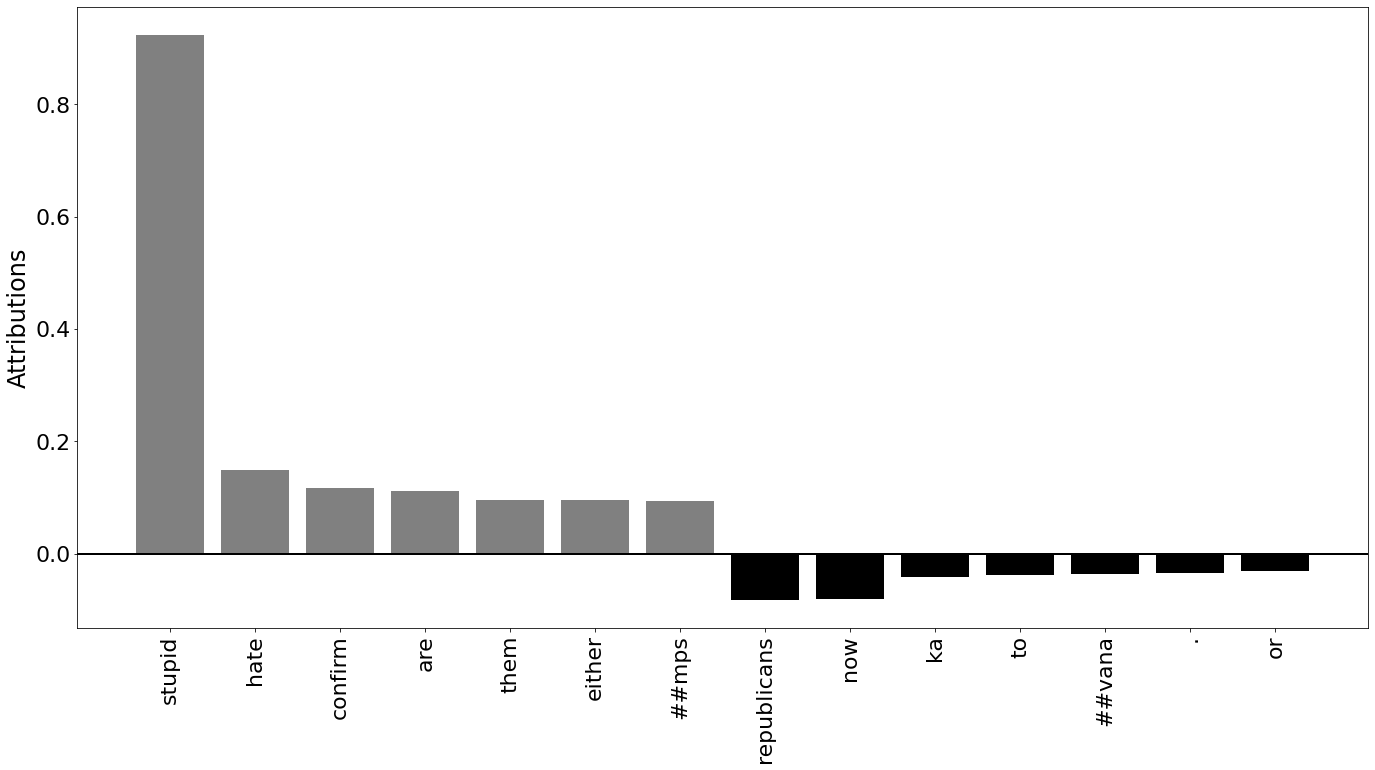

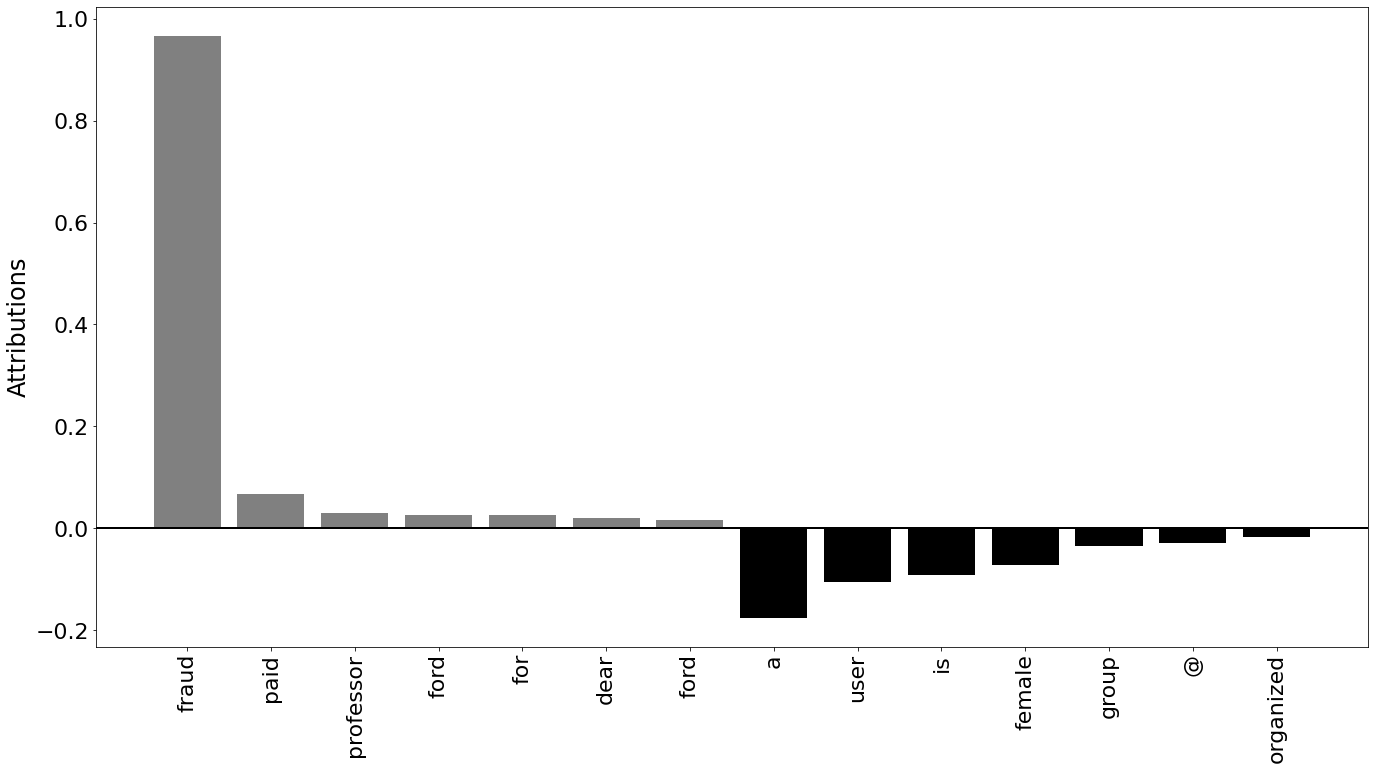

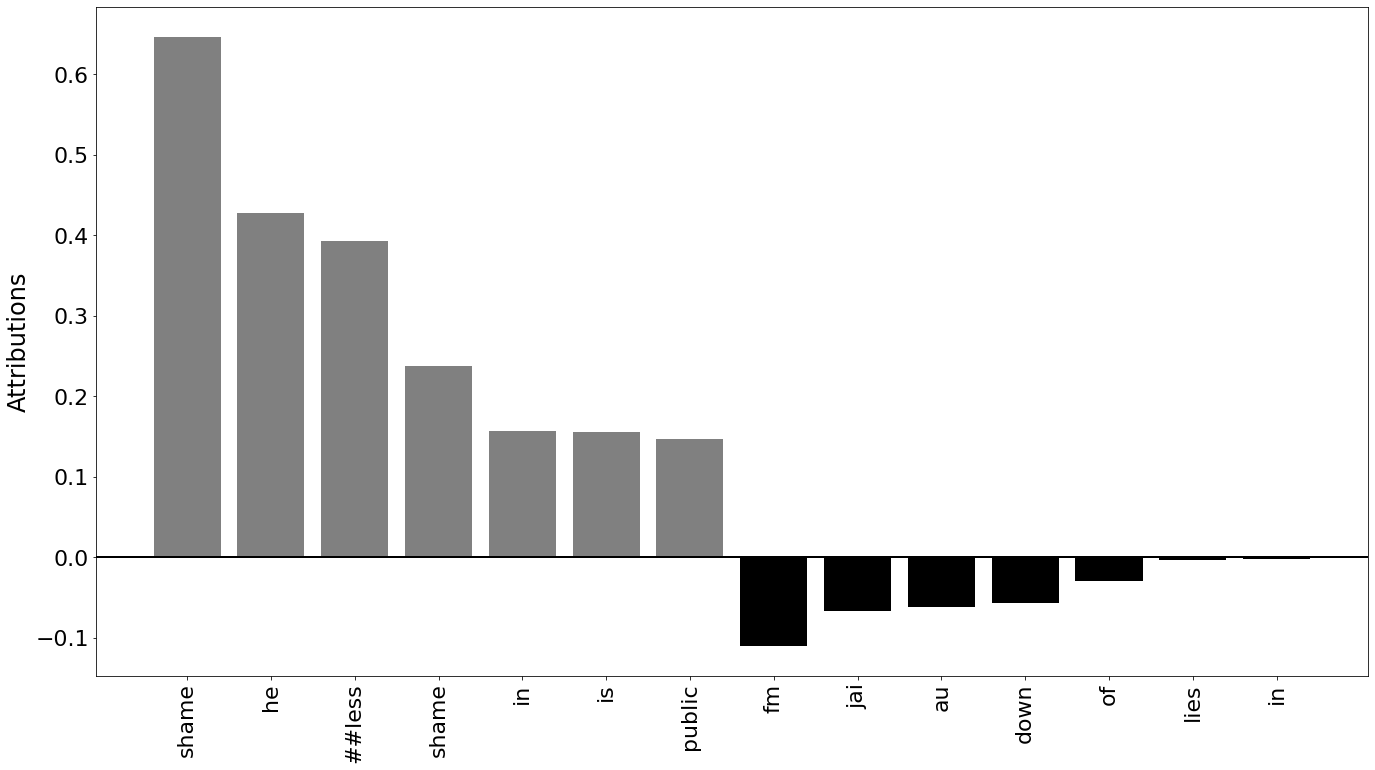

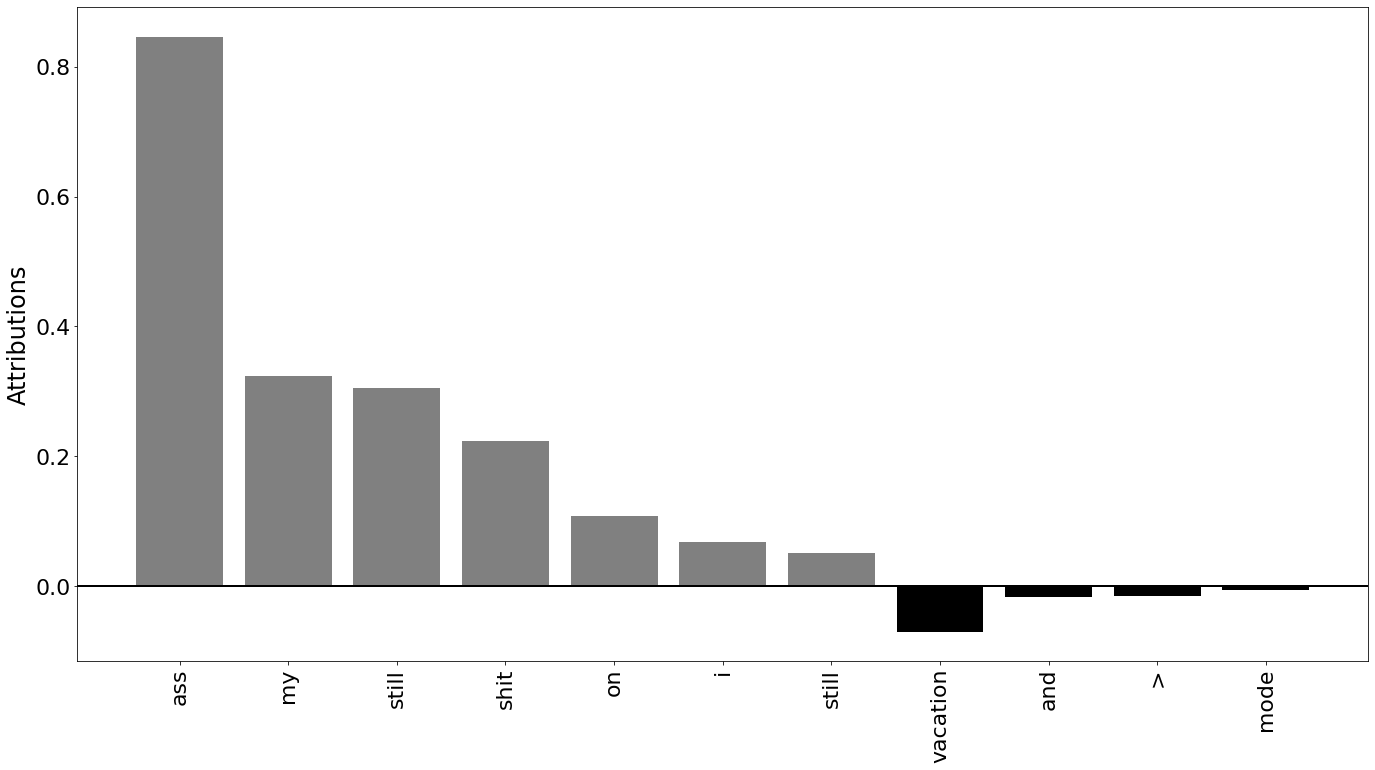

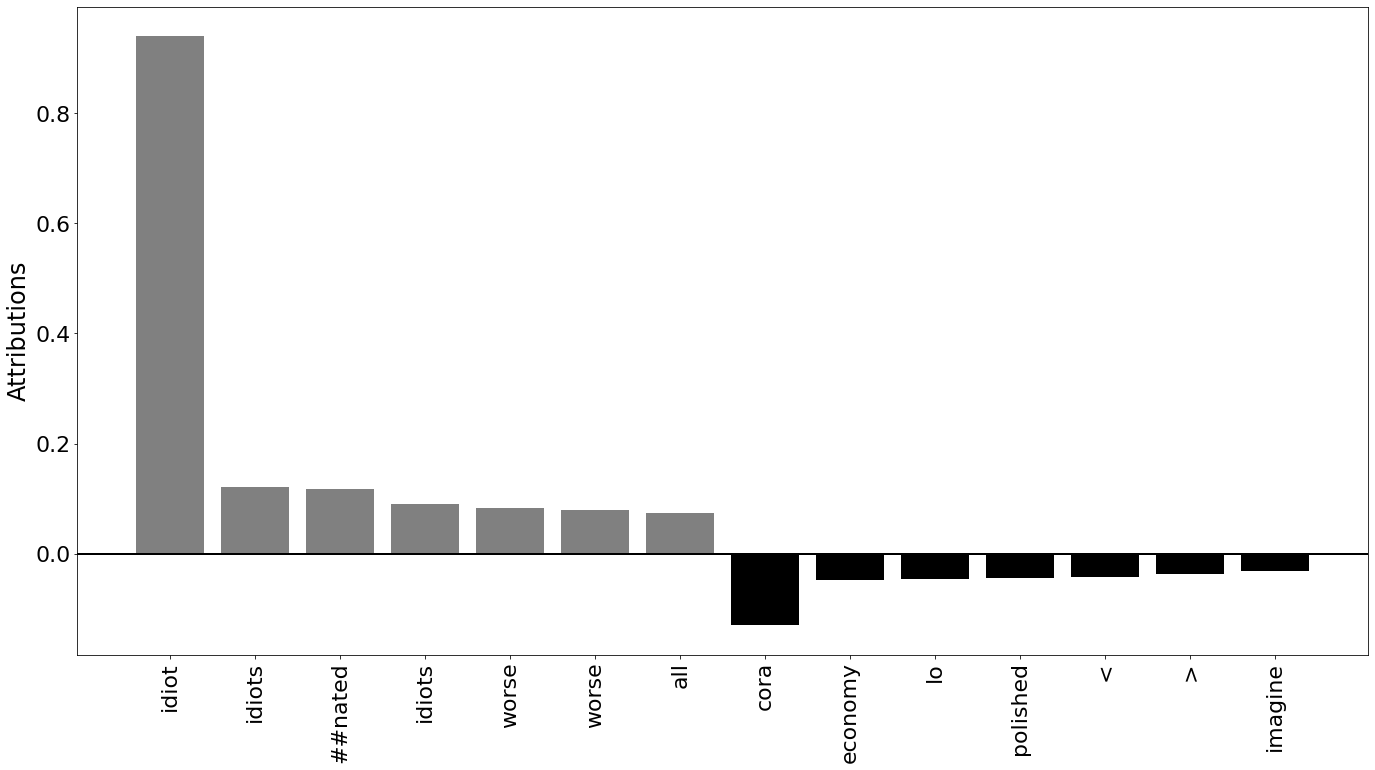

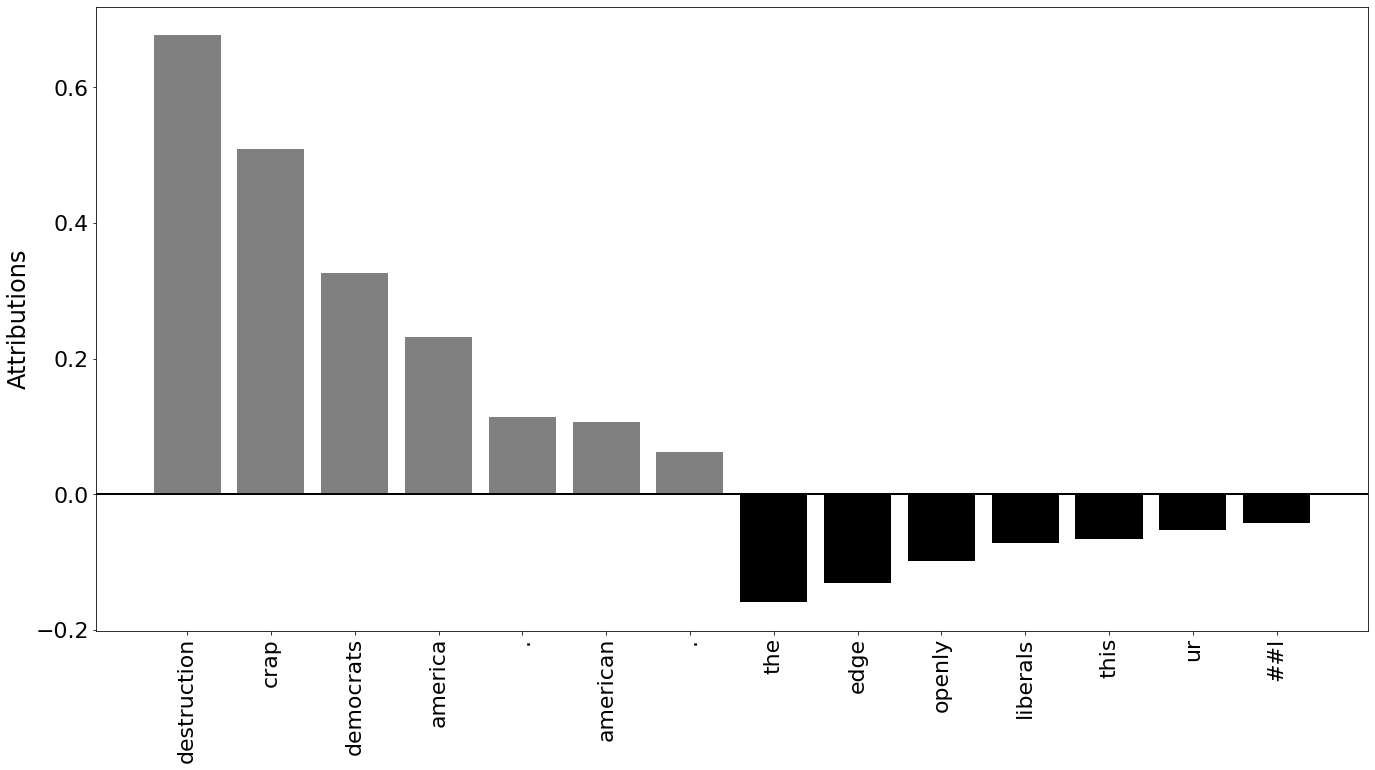

In [ ]:
accurate_tn_indices = get_accurate_predictions("tn_accurate_predictions")
accurate_tp_indices = get_accurate_predictions("tp_accurate_predictions")
index_lists = [accurate_tn_indices, accurate_tp_indices]
prediction_titles = ['Accurate True negative predictions', 'Accurate True positive predictions']
pred_type = ['accurate_tn', 'accurate_tp']

for i_list, title, p_type in zip(index_lists, prediction_titles, pred_type):
  analyze_tweets(i_list, 100, title, p_type)

## Analyze the results

In [26]:
def get_row_by_token_match(token):
  return df.loc[df['Token'] == token]

In [27]:
def majority_attribution(attributions):
  return 'Attributions: ' + str(np.sum(attributions > 0, axis=0)) + ' positive (i.e. contributes to OFF label) out of a total of ' + str(len(attributions)) + ' attributions.'

In [29]:
df = get_dataset('interpret_plots/attributions_accurate_tp')
series = pd.Series(' '.join(df.Token).split()).value_counts()[:40]
print(series)

.          36
ur         22
##l        21
!          18
i          15
you        14
shit       14
the        13
and        13
@          12
a          11
?          11
is         11
fuck       11
are        11
user       10
ass         9
all         8
fucking     8
>           8
<           8
bitch       7
she         7
he          6
to          6
this        6
her         5
who         5
##s         5
your        5
for         5
,           5
my          5
me          5
stupid      4
*           4
of          4
get         4
dick        4
ka          4
dtype: int64


In [ ]:
rows = get_row_by_token_match('gun')
print(rows)
print(majority_attribution(rows.Attribution.values))

    Token  Attribution  Tweet Index
93    gun     0.335961           72
246   gun     0.157504          258
725   gun     0.227204          657
728   gun     0.162180          657
Attributions: 4 positive (i.e. contributes to OFF label) out of a total of 4 attributions.


In [ ]:
unique_value = df["Tweet Index"].nunique()
print(unique_value)

76


In [28]:
def censor_tweet(tweet, words_to_censor, censor):
  for w in words_to_censor:
    tweet = tweet.replace(w, censor)
  return tweet

In [29]:
def analyze_tweet(tweet, true_label):
  input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
  attributions, delta = get_attributions(input_ids, ref_input_ids)
  attributions_sum = summarize_attributions(attributions)
  attributions_sum = attributions_sum.detach().cpu().numpy()
  score = predict(input_ids)
  score_vis = save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta)
  print('\033[1m', 'Visualization For Score', '\033[0m')
  viz.visualize_text([score_vis])

In [70]:
tweet, true_label = get_test_tweet_by_index(72)
print(tweet)

@user @user @user @user then why aren t there so many shootings in virginia ? jacksonville shooter got his guns in maryland ! ! among the poster children for gun control ! what good did that do ? ! you re full of crap .


In [71]:
censored_tweet = censor_tweet(tweet, ['gun'], '')
censored_tweet = censor_tweet(tweet, [' s '], '')
#censored_tweet = censor_tweet(censored_tweet, ['him'], '')
#censored_tweet = censor_tweet(censored_tweet, ['himself'], '')
#censored_tweet = censor_tweet(censored_tweet, ['ll'], 'hell')
#censored_tweet = censor_tweet(censored_tweet, ['t '], 'the ')
analyze_tweet(tweet, true_label)
analyze_tweet(censored_tweet, true_label)

 Visualization For Score 


 Visualization For Score 


In [72]:
censored_tweet = censor_tweet(tweet, ['gun'], 'weapon')
censored_tweet = censor_tweet(tweet, [' s '], ' weapons ')
#censored_tweet = censor_tweet(censored_tweet, ['his'], 'her')
#censored_tweet = censor_tweet(censored_tweet, ['himself'], 'herself')
#censored_tweet = censor_tweet(censored_tweet, ['gunman'], 'shooter')
#censored_tweet = censor_tweet(censored_tweet, ['tshe'], 'the')
#censored_tweet = censor_tweet(censored_tweet, ['shell'], 'hell')
analyze_tweet(censored_tweet, true_label)

 Visualization For Score 


In [46]:
censored_tweet = censor_tweet(tweet, ['fucking'], 'insanely')
analyze_tweet(censored_tweet, true_label)

 Visualization For Score 


##For testing on single tweets

In [ ]:
tweet, true_label = get_test_tweet_by_index(38)
print(tweet)
tweet = tweet.replace('shit', '')
tweet = tweet.replace('fucking', ' ')
tweet = tweet.replace('assholes', ' ')
tweet = tweet.replace('fuckers', ' ')
print(tweet)

ariana asesina ? is that serious ? ! holy shit , please your fucking assholes , do not blame someone for the death of other one . she is sad enough for today , do not you see ? it is not fault of none , he had an overdose and died . end . stop wanting someone to blame , fuckers .
ariana asesina ? is that serious ? ! holy  , please your     , do not blame someone for the death of other one . she is sad enough for today , do not you see ? it is not fault of none , he had an overdose and died . end . stop wanting someone to blame ,   .


In [ ]:
input_ids, ref_input_ids, sep_id, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids, attention_mask, indices, all_tokens = tokenize_tweet(tweet)
attributions, delta = get_attributions(input_ids, ref_input_ids)
attributions_sum = summarize_attributions(attributions)
attributions_sum = attributions_sum.detach().cpu().numpy()

In [ ]:
score = predict(input_ids)
score_vis = save_vis(attributions_sum, score, true_label, tweet, all_tokens, delta)
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

 Visualization For Score 


rap is a form of art ! used to express yourself freely . it does not gv the green light or excuse the behavior of acting like an animal ! she is not in the streets of the bx where violence is a way of living . elevate yourself boo and get on @user level for longevity ! queen


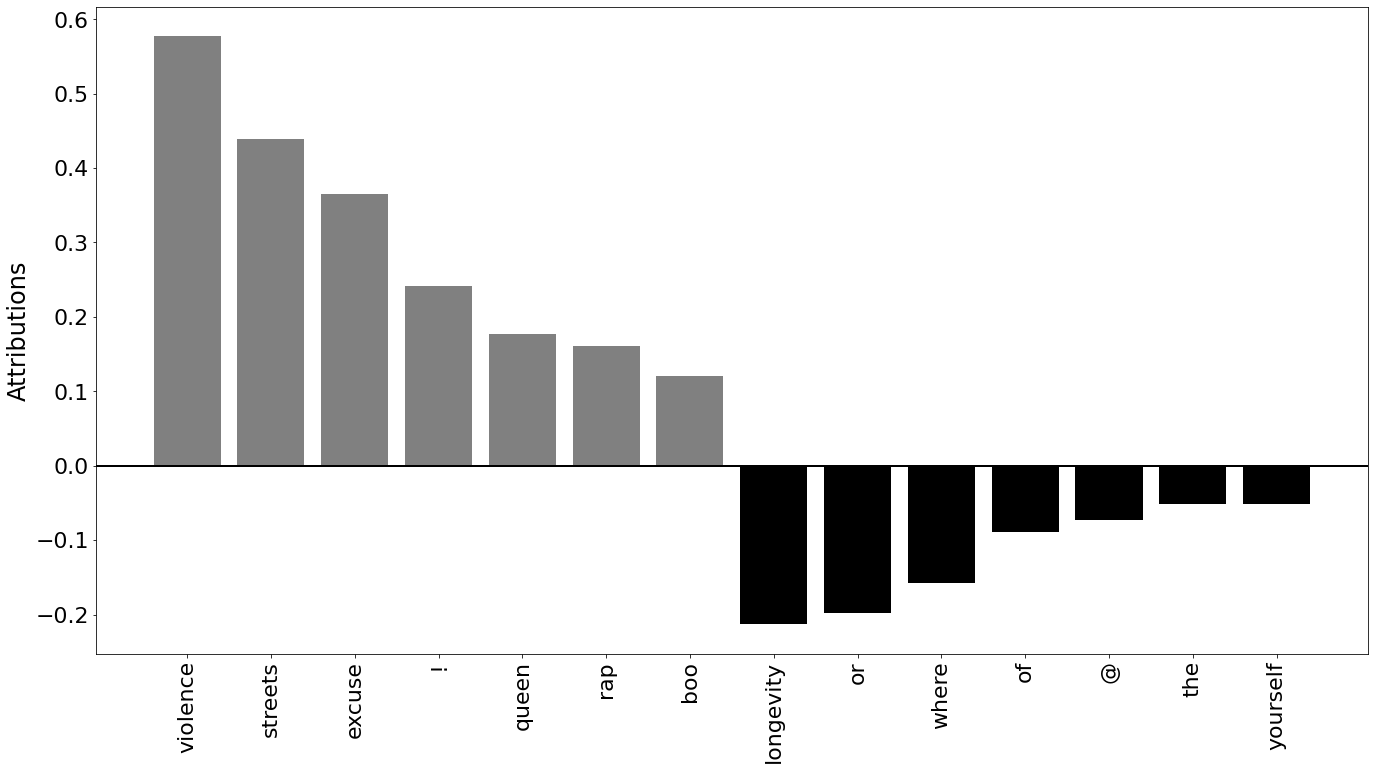

In [ ]:
n_attributions, n_tokens, nr_of_top_tokens = get_n_attributions_and_tokens(7, attributions_sum, np.array(all_tokens))
print(tweet)
plot_top_attributions(nr_of_top_tokens, n_attributions, n_tokens, 'Attributions',  '', 'test_plot_tweet_index_' + str(fp_indices[0]))